# 1.单个极化训练：
读取表格文件，计算18个随机森林模型（6个波段+极化组合*3个输入变量集），过程中直接使用全部数据进行调参，直接得到最优的训练模型

具体描述
读取路径为E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx的表格文件中名为“VOD_Ku_Hpol_Asc_Cleaned_Type1”的sheet，提取该sheet中的以下名称的列：AGB、Hveg、Grass_man、Grass_nat、Shrub_bd、Shrub_be、Shrub_nd、Shrub_ne、Tree_bd、Tree_be、Tree_nd、Tree_ne、LAI、LFMCValue、VOD_Ku_Hpol_Asc、SamplingDate。组成新的dataframe变量（我不确定dataframe变量能否直接用于机器学习训练）后，进行以下处理：
①将AGB列与LFMCValue列逐元素相乘，然后相乘的结果每个元素除以1000，最终计算结果定义为新列，列名为VWC_sample，去除AGB列与LFMCValue列
②读取SamplingDate，提取年信息转为数字后将2020减去它，得到年份差
③将LAI根据下限为0、上限为6进行数据缩放，列名不变
④将VOD_Ku_Hpol_Asc根据下限为0、上限为2进行数据缩放，列名改为VOD
⑤将1‘Tree_bd、Tree_be2’Tree_nd、Tree_ne分别逐元素相加得到新列BoardLeafTree和NeedleLeafTree，同时不删除旧列。
分别初始设置λ_B和λ_N为0.001。结合Hveg以及②中的年份差（Year_diff），计算出新列Hveg_history：Hveg_history = Hveg*（BoardLeafTree*exp(-λ_B*Year_diff)+NeedleLeafTree*exp(-λ_N*Year_diff)+1-BoardLeafTree-NeedleLeafTree）
将Hveg_history按照下限为0、上限为60进行数据缩放，列名不变。
定义随机森林回归模型输入：VOD、Hveg_history、LAI、Grass_man、Grass_nat、Shrub_bd、Shrub_be、Shrub_nd、Shrub_ne、Tree_bd、Tree_be、Tree_nd、Tree_ne列，随机森林回归的因变量为VWC_sample列。

训练时随机种子42的五折交叉验证，过程中同时进行超参数调节。λ_B和λ_N作为超参数，调节范围均为0.001-0.01，步长0.001。

In [1]:
# # Ku波段H极化的VOD，PFT使用原始输入(VOD_Ku_Hpol_Asc_Cleaned_Type1)
# import pandas as pd
# import numpy as np
# import time
# import os
# import joblib
# from datetime import datetime
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
# from sklearn.metrics import mean_squared_error

# # ====================================第一部分：数据的前置处理======================================
# # 读取数据
# start_time_data = time.time()
# file_path = r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx"
# sheet_name = "VOD_Ku_Hpol_Asc_Cleaned_Type1"

# # 要提取的列
# columns_to_extract = [
#     'AGB', 'Hveg', 'Grass_man', 'Grass_nat',
#     'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
#     'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne',
#     'LAI', 'LFMCValue', 'VOD_Ku_Hpol_Asc', 'SamplingDate'
# ]

# # 读取所需列
# df = pd.read_excel(file_path, sheet_name=sheet_name, usecols=columns_to_extract)
# df = df.dropna()

# # 步骤①：计算 VWC_sample
# df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000
# df.drop(['AGB', 'LFMCValue'], axis=1, inplace=True)

# # 步骤②：提取年份差
# df['Year_diff'] = df['SamplingDate'].dt.year.apply(lambda x: 2020 - x)

# # 步骤③：归一化 LAI（范围 0–6）
# df['LAI'] = df['LAI'].clip(0, 6) / 6

# # 步骤④：归一化 VOD_Ku_Hpol_Asc（范围 0–2），改名为 VOD
# df['VOD'] = df['VOD_Ku_Hpol_Asc'].clip(0, 2) / 2
# df.drop(['VOD_Ku_Hpol_Asc'], axis=1, inplace=True)

# # # 步骤⑤：计算 BoardLeafTree 和 NeedleLeafTree
# # df['BoardLeafTree'] = df['Tree_bd'] + df['Tree_be']
# # df['NeedleLeafTree'] = df['Tree_nd'] + df['Tree_ne']

# # # 初始化 lambda
# # lambda_B = 0.001
# # lambda_N = 0.001

# # # 步骤⑥：计算 Hveg_history（指数衰减权重）并归一化（范围 0–60）
# # decay_factor = (
# #     df['BoardLeafTree'] * np.exp(-lambda_B * df['Year_diff']) +
# #     df['NeedleLeafTree'] * np.exp(-lambda_N * df['Year_diff']) +
# #     (1 - df['BoardLeafTree'] - df['NeedleLeafTree'])
# # )
# # df['Hveg_history'] = (df['Hveg'] * decay_factor).clip(0, 60) / 60

# # 输出用于模型的特征和目标列
# feature_columns = [
#     'VOD', 'Hveg', 'LAI',
#     'Grass_man', 'Grass_nat',
#     'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
#     'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
# ]
# X = df[feature_columns]
# y = df['VWC_sample']

# end_time_data = time.time()
# elapsed_time_data = end_time_data - start_time_data
# print(f"数据前置处理总耗时: {elapsed_time_data / 60:.2f} minute")
# # ===============================第二部分：超参数调节——随机网格搜索==================================

# # 先调 RF 模型的超参数
# start_time = time.time()
# # # 使用默认 lambda_B 和 lambda_N 初始化 Hveg_history
# # lambda_B_init = 0.001
# # lambda_N_init = 0.001
# # decay_factor_init = (
# #     df['BoardLeafTree'] * np.exp(-lambda_B_init * df['Year_diff']) +
# #     df['NeedleLeafTree'] * np.exp(-lambda_N_init * df['Year_diff']) +
# #     (1 - df['BoardLeafTree'] - df['NeedleLeafTree'])
# # )
# # X['Hveg_history'] = (df['Hveg'] * decay_factor_init).clip(0, 60) / 60

# X_rf = X.drop(columns=['SamplingDate', 'Year_diff'], errors='ignore').copy()

# print("模型输入特征:",X_rf.columns.tolist())
# # 随机森林超参数搜索
# param_dist = {
#     'n_estimators': [int(x) for x in np.linspace(100, 1000, 10)],
#     'max_features': ['sqrt', 'log2'],
#     'max_depth': [int(x) for x in np.linspace(10, 100, 10)] + [None],
#     'min_samples_split': [2, 4, 6, 8],
#     'min_samples_leaf': [1, 2, 4, 8]
# }

# rf = RandomForestRegressor(random_state=42, n_jobs=-1)
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# random_search = RandomizedSearchCV(
#     rf, param_distributions=param_dist,
#     n_iter=50, cv=kf, scoring='neg_mean_squared_error',
#     random_state=42, n_jobs=-1, verbose=1
# )

# random_search.fit(X_rf, y)
# best_rf = random_search.best_estimator_

# best_score = -random_search.best_score_  
# best_params = random_search.best_params_
# # lambda_range = np.arange(0.001, 0.011, 0.001)

# # best_score = np.inf
# # best_lambdas = {}

# # # 单独进行lambda调参
# # for lambda_B in lambda_range:
# #     for lambda_N in lambda_range:
# #         decay_factor = (
# #             df['BoardLeafTree'] * np.exp(-lambda_B * df['Year_diff']) +
# #             df['NeedleLeafTree'] * np.exp(-lambda_N * df['Year_diff']) +
# #             (1 - df['BoardLeafTree'] - df['NeedleLeafTree'])
# #         )
# #         Hveg_history = (df['Hveg'] * decay_factor).clip(0, 60) / 60
        
# #         X_temp = X.copy()
# #         X_temp['Hveg_history'] = Hveg_history
# #         X_temp_rf = X_temp.drop(columns=['Hveg', 'SamplingDate', 'Year_diff'], errors='ignore')
        
# #         preds = best_rf.predict(X_temp_rf)
# #         mse = mean_squared_error(y, preds)
        
# #         if mse < best_score:
# #             best_score = mse
# #             best_lambdas = {'lambda_B': lambda_B, 'lambda_N': lambda_N}

            
# end_time = time.time()
# elapsed_time = end_time - start_time

# print(f"\n随机网格部分搜索总耗时：{elapsed_time/60:.2f} minute")
# print("最终最佳参数组合：")
# print(best_params)
# print(f"对应的最佳MSE: {best_score:.6f}")   

# # =================================第三部分：超参数调节——网格搜索====================================

# # # 固定 lambda_B 和 lambda_N 为第二部分中得到的最佳值
# # lambda_B_fixed = best_lambdas['lambda_B']
# # lambda_N_fixed = best_lambdas['lambda_N']

# # 只针对 RF 的部分参数进行网格搜索
# n_estimators_grid = list(range(random_search.best_params_['n_estimators'] - 50,
#                                random_search.best_params_['n_estimators'] + 51, 10))
# max_depth_grid = list(range(max(1, (random_search.best_params_['max_depth'] or 10) - 10),
#                             (random_search.best_params_['max_depth'] or 10) + 11, 5))

# # 固定其他超参数
# fixed_params = {
#     'max_features': [best_params['max_features']],
#     'min_samples_split': [best_params['min_samples_split']],
#     'min_samples_leaf': [best_params['min_samples_leaf']]
# }

# # # 初始化记录
# # best_grid_score = np.inf
# # best_grid_params = {}

# # # 重新计算固定的 Hveg_history
# # decay_factor = (
# #     df['BoardLeafTree'] * np.exp(-lambda_B_fixed * df['Year_diff']) +
# #     df['NeedleLeafTree'] * np.exp(-lambda_N_fixed * df['Year_diff']) +
# #     (1 - df['BoardLeafTree'] - df['NeedleLeafTree'])
# # )
# # Hveg_history = (df['Hveg'] * decay_factor).clip(0, 60) / 60

# # # 构造特征集
# X_new = X.copy()
# # X_new['Hveg_history'] = Hveg_history
# X_new_rf = X_new.drop(columns=['SamplingDate', 'Year_diff'], errors='ignore')

# # 定义模型和网格参数
# rf = RandomForestRegressor(random_state=42, n_jobs=-1)
# param_grid = {
#     'n_estimators': n_estimators_grid,
#     'max_depth': max_depth_grid,
#     **fixed_params
# }

# # 执行网格搜索
# start_time_grid = time.time()
# grid_search = GridSearchCV(
#     rf, param_grid=param_grid,
#     cv=3, scoring='neg_mean_squared_error',
#     n_jobs=-1, verbose=1
# )
# grid_search.fit(X_new_rf, y)
# best_grid_score = -grid_search.best_score_
# best_grid_params = grid_search.best_params_
# end_time_grid = time.time()

# # 打印最终结果
# print("\n===================最终网格搜索结果===================")
# print(f"网格搜索总耗时: {(end_time_grid - start_time_grid) / 60:.2f} minute")
# print(f"最优超参数组合: {best_grid_params}")
# print(f"对应的最佳 MSE: {best_grid_score:.6f}")

# # ======================================第四部分：模型保存==========================================

# # # 使用网格搜索得到的最优 lambda 参数
# # lambda_B_opt = best_grid_params['lambda_B']
# # lambda_N_opt = best_grid_params['lambda_N']

# # # 重新计算 Hveg_history
# # decay_factor_opt = (
# #     df['BoardLeafTree'] * np.exp(-lambda_B_opt * df['Year_diff']) +
# #     df['NeedleLeafTree'] * np.exp(-lambda_N_opt * df['Year_diff']) +
# #     (1 - df['BoardLeafTree'] - df['NeedleLeafTree'])
# # )
# # Hveg_history_opt = (df['Hveg'] * decay_factor_opt).clip(0, 60) / 60

# # 构造最终训练特征
# X_final = X.copy()
# # X_final['Hveg_history'] = Hveg_history_opt
# X_final_rf = X_final.drop(columns=['SamplingDate', 'Year_diff'], errors='ignore')
# # X_final_rf.rename(columns={'Hveg_history': 'Hveg'}, inplace=True)

# # 创建并训练最终模型（使用 best_grid_params 中的其他随机森林参数）
# final_model = RandomForestRegressor(
#     n_estimators=best_grid_params['n_estimators'],
#     max_features=best_grid_params['max_features'],
#     max_depth=best_grid_params['max_depth'],
#     min_samples_split=best_grid_params['min_samples_split'],
#     min_samples_leaf=best_grid_params['min_samples_leaf'],
#     random_state=42,
#     n_jobs=-1
# )

# final_model.fit(X_final_rf, y)

# # 保存模型至 model 文件夹
# joblib.dump(final_model, "models/RFR_Ku_Hpol_Type1.pkl")
# print(f"✅ 模型已成功保存")

In [1]:
# Ku波段H极化的VOD输入，不输入树高数据，PFT使用原始输入(VOD_Ku_Hpol_Asc_Cleaned_Type1)，贝试叶斯优化超参数
import pandas as pd
import numpy as np
import time
import random
import os
import joblib
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import optuna
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 设置随机种子保证可重复性
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# ============================== 数据预处理部分 ==============================
def load_and_preprocess_data(file_path, sheet_name):
    """数据加载和预处理函数"""
    print("开始数据加载和预处理...")
    start_time = time.time()
    
    # 定义要提取的列
    columns_to_extract = [
        'AGB', 'SM_Asc', 'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne',
        'LAI', 'LFMC', 'VOD_Ku_Hpol_Asc', 'SamplingDate'
    ]
    
    # 读取数据
    df = pd.read_excel(file_path, sheet_name=sheet_name, usecols=columns_to_extract)
    df = df.dropna()
    
    # 计算VWC_sample
    df['VWC_sample'] = (df['AGB'] * df['LFMC']) / 1000
    df.drop(['AGB', 'LFMC'], axis=1, inplace=True)
    original_count = len(df)
    df = df[df['VWC_sample'] <= 30]  # 过滤VWC＞30
    filtered_count = len(df)
    print(f"  移除VWC_sample > 30的样本: 原始样本数 {original_count}, 过滤后样本数 {filtered_count} (移除 {original_count-filtered_count} 个样本)")    
    # 提取年份差
    df['Year_diff'] = df['SamplingDate'].dt.year.apply(lambda x: 2020 - x)
    
    # 归一化处理
    df['LAI'] = df['LAI'].clip(0, 6) / 6
    df['VOD'] = df['VOD_Ku_Hpol_Asc'].clip(0, 2) / 2
    df.drop(['VOD_Ku_Hpol_Asc'], axis=1, inplace=True)
    df = df.rename(columns={'SM_Asc': 'SM'})
    
    # 定义特征和目标列
    feature_columns = [
        'VOD', 'LAI', 'SM',
        'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
    ]
    
    X = df[feature_columns]
    y = df['VWC_sample']
    
    elapsed_time = (time.time() - start_time) / 60
    print(f"数据预处理完成，耗时: {elapsed_time:.2f} 分钟")
    
    return X, y

# ============================== 模型训练与评估部分 ==============================
def train_and_evaluate(X, y):
    """模型训练与评估主函数"""
    print("\n开始模型训练与评估流程...")
    
    # 1. 数据划分（2:1比例）
    print("划分训练集和测试集...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.333, 
        random_state=SEED,
        shuffle=True
    )
    print(f"训练集样本数: {len(X_train)}, 测试集样本数: {len(X_test)}")
    
    # 2. 贝叶斯优化调参
    print("\n开始贝叶斯优化调参...")
    study = optuna.create_study(
        study_name="VWC_Optimization_KuHpol_Type1",
        direction='minimize',
        sampler=TPESampler(seed=SEED)
    )
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100, show_progress_bar=True)
    
    # 获取最佳参数
    best_params = study.best_params
    print("\n最佳参数组合:")
    for key, value in best_params.items():
        print(f"{key}: {value}")
    print(f"最佳验证RMSE: {study.best_value:.4f}")
    
    # 3. 使用最佳参数训练最终模型
    print("\n训练最终模型...")
    final_model = RandomForestRegressor(
        **best_params,
        random_state=SEED,
        n_jobs=-1
    )
    final_model.fit(X_train, y_train)
    
    # 4. 测试集评估
    print("\n测试集评估...")
    y_pred = final_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    print(f"测试集RMSE: {test_rmse:.4f}")
    print(f"测试集R²: {test_r2:.4f}")
    
    # 5. 可视化预测结果
    plot_results(y_test, y_pred)
    
    # 6. 保存模型
    os.makedirs("models", exist_ok=True)
    model_path = "models/RFR_Ku_Hpol_Type1.pkl"
    joblib.dump(final_model, model_path)
    print(f"\n模型已保存至: {model_path}")
    
    return final_model

# ============================== 辅助函数 ==============================
def objective(trial, X_train, y_train):
    """贝叶斯优化目标函数"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'max_depth': trial.suggest_int('max_depth', 10, 100, step=10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    model = RandomForestRegressor(**params, random_state=SEED, n_jobs=-1)
    
    # 五折交叉验证
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    rmse_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

def plot_results(y_true, y_pred):
    """结果可视化函数"""
    plt.rcParams['font.family'] = 'Times New Roman'

    plt.figure(figsize=(6, 6))
    
    # 计算RMSE指标
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # 绘制散点图
    plt.scatter(
        y_true, y_pred, 
        marker='x',          # 叉形标记
        color='#FF0000',  # 边缘颜色
        linewidths=0.5,        # 边缘线宽
        s=40,                  # 点的大小
        alpha=0.8,
        zorder=2
    )
    
    # 添加1:1参考线（黑色虚线，无标签）
    max_val = max(max(y_true), max(y_pred))
    plt.plot([0, max_val], [0, max_val], 'k--', lw=1.5, alpha=0.7, zorder=1)   
    
    # 设置坐标轴范围和标签
    plt.xlim(0, 30)
    plt.ylim(0, 30)
    plt.xlabel('Insitu VWC (kg/m²)', fontsize=12, fontname='Arial', fontweight='bold')
    plt.ylabel('RF VWC (kg/m²)', fontsize=12, fontname='Arial', fontweight='bold')
    
    # 设置标题
    plt.title('Ku-Band, H-pol', fontsize=16, pad=20, fontweight='bold')
    
    # 添加RMSE指标文本
    plt.text(0.05, 0.95, 
             f'RMSE = {rmse:.3f} kg/m²', 
             transform=plt.gca().transAxes,
             fontsize=12,
             fontweight='bold',
             verticalalignment='top')
    
    # 网格线和样式调整
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_axisbelow(True)
    
    # 调整布局并保存
    plt.tight_layout()
    
    # 保存图像
    os.makedirs("figures", exist_ok=True)
    plot_path = "figures/prediction_results_Ku_Hpol_Type1.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"Prediction plot saved to: {plot_path}")
    plt.close()

# ============================== 主执行流程 ==============================
if __name__ == "__main__":
    # 数据加载与预处理
    file_path = r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx"
    sheet_name = "VOD_Ku_Hpol_Asc_Cleaned_Type1"
    X, y = load_and_preprocess_data(file_path, sheet_name)
    
    # 模型训练与评估
    model = train_and_evaluate(X, y)

开始数据加载和预处理...


[I 2025-07-22 11:05:18,923] A new study created in memory with name: VWC_Optimization_KuHpol_Type1


  移除VWC_sample > 30的样本: 原始样本数 27785, 过滤后样本数 27677 (移除 108 个样本)
数据预处理完成，耗时: 0.76 分钟

开始模型训练与评估流程...
划分训练集和测试集...
训练集样本数: 18460, 测试集样本数: 9217

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-22 11:05:29,616] Trial 0 finished with value: 1.5643889730984206 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.5643889730984206.
[I 2025-07-22 11:05:43,656] Trial 1 finished with value: 1.5755416163139984 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.5643889730984206.
[I 2025-07-22 11:05:51,840] Trial 2 finished with value: 1.5699814754687782 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.5643889730984206.
[I 2025-07-22 11:06:00,576] Trial 3 finished with value: 1.5892798372968286 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sa

In [3]:
# # Ku波段H极化的VOD输入，不输入树高数据，PFT使用原始输入(VOD_Ku_Hpol_Asc_Cleaned_Type2)，贝试叶斯优化超参数
# import pandas as pd
# import numpy as np
# import time
# import random
# import os
# import joblib
# from datetime import datetime
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import KFold, cross_val_score
# import optuna
# from optuna.samplers import TPESampler
# from sklearn.metrics import mean_squared_error

# SEED = 42
# random.seed(SEED)
# np.random.seed(SEED)
# # ====================================第一部分：数据的前置处理======================================
# # 读取数据
# start_time_data = time.time()
# file_path = r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx"
# sheet_name = "VOD_Ku_Hpol_Asc_Cleaned_Type2"

# # 要提取的列
# columns_to_extract = [
#     'AGB', 'SM_Asc', 'Grass',
#     'Shrub_b', 'Shrub_n',
#     'Tree_b', 'Tree_n',
#     'LAI', 'LFMCValue', 'VOD_Ku_Hpol_Asc', 'SamplingDate'
# ]

# # 读取所需列
# df = pd.read_excel(file_path, sheet_name=sheet_name, usecols=columns_to_extract)
# df = df.dropna()

# # 步骤①：计算 VWC_sample
# df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000
# df.drop(['AGB', 'LFMCValue'], axis=1, inplace=True)

# # 步骤②：提取年份差
# df['Year_diff'] = df['SamplingDate'].dt.year.apply(lambda x: 2020 - x)

# # 步骤③：归一化 LAI（范围 0–6）
# df['LAI'] = df['LAI'].clip(0, 6) / 6

# # 步骤④：归一化 VOD_Ku_Hpol_Asc（范围 0–2），改名为 VOD
# df['VOD'] = df['VOD_Ku_Hpol_Asc'].clip(0, 2) / 2
# df.drop(['VOD_Ku_Hpol_Asc'], axis=1, inplace=True)

# df = df.rename(columns={'SM_Asc': 'SM'})

# # 输出用于模型的特征和目标列（暂时去除静态变量Hveg）
# feature_columns = [
#     'VOD', 'LAI', 'SM', 'Grass',
#     'Shrub_b', 'Shrub_n',
#     'Tree_b', 'Tree_n'
# ]
# X = df[feature_columns]
# y = df['VWC_sample']

# end_time_data = time.time()
# elapsed_time_data = end_time_data - start_time_data
# print(f"数据前置处理总耗时: {elapsed_time_data / 60:.2f} minute")

# # ===============================第二部分：超参数调节——贝叶斯优化==================================
# X_rf = X.drop(columns=['SamplingDate', 'Year_diff'], errors='ignore').copy()
# # 定义贝叶斯优化目标函数（RMSE）
# def objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
#         'max_depth': trial.suggest_int('max_depth', 10, 100),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
#         'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
#     }
    
#     model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
    
#     # 手动实现交叉验证计算RMSE
#     kf = KFold(n_splits=5, shuffle=True, random_state=42)
#     rmse_scores = []
    
#     for train_idx, val_idx in kf.split(X_rf):
#         X_train, X_val = X_rf.iloc[train_idx], X_rf.iloc[val_idx]
#         y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_val)
#         rmse = np.sqrt(mean_squared_error(y_val, y_pred))  # 计算RMSE
#         rmse_scores.append(rmse)
    
#     return np.mean(rmse_scores)

# # 执行贝叶斯优化
# start_time = time.time()
# sampler = TPESampler(seed=SEED)
# study = optuna.create_study(study_name="VWC_Optimization_KuHpol_Type2",direction='minimize',sampler=sampler)
# study.optimize(objective, n_trials=100, show_progress_bar=True)

# # 获取最佳参数和分数
# best_params = study.best_params
# best_score = study.best_value

# end_time = time.time()
# elapsed_time = end_time - start_time

# print(f"\n贝叶斯优化总耗时：{elapsed_time/60:.2f} minute")
# print("最终最佳参数组合：")
# print(best_params)
# print(f"对应的最佳MSE: {best_score:.6f}")

# # ======================================第三部分：模型保存==========================================
# # 构造最终训练特征
# X_final = X.copy()
# X_final_rf = X_final.drop(columns=['SamplingDate', 'Year_diff'], errors='ignore')

# # 创建并训练最终模型（使用 best_grid_params 中的其他随机森林参数）
# final_model = RandomForestRegressor(
#     n_estimators=best_params['n_estimators'],
#     max_features=best_params['max_features'],
#     max_depth=best_params['max_depth'],
#     min_samples_split=best_params['min_samples_split'],
#     min_samples_leaf=best_params['min_samples_leaf'],
#     bootstrap=best_params['bootstrap'],
#     random_state=42,
#     n_jobs=-1
# )

# final_model.fit(X_final_rf, y)

# # 保存模型至 model 文件夹
# joblib.dump(final_model, "models/RFR_Ku_Hpol_Type2.pkl")
# print(f"模型已成功保存")


In [4]:
# # Ku波段H极化的VOD输入，不输入树高数据，PFT使用原始输入(VOD_Ku_Hpol_Asc_Cleaned_Type3)，贝试叶斯优化超参数
# import pandas as pd
# import numpy as np
# import time
# import random
# import os
# import joblib
# from datetime import datetime
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import KFold, cross_val_score
# import optuna
# from optuna.samplers import TPESampler
# from sklearn.metrics import mean_squared_error

# SEED = 42
# random.seed(SEED)
# np.random.seed(SEED)
# # ====================================第一部分：数据的前置处理======================================
# # 读取数据
# start_time_data = time.time()
# file_path = r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx"
# sheet_name = "VOD_Ku_Hpol_Asc_Cleaned_Type3"

# # 要提取的列
# columns_to_extract = [
#     'AGB', 'SM_Asc', 'Grass',
#     'Shrub','Tree',
#     'LAI', 'LFMCValue', 'VOD_Ku_Hpol_Asc', 'SamplingDate'
# ]

# # 读取所需列
# df = pd.read_excel(file_path, sheet_name=sheet_name, usecols=columns_to_extract)
# df = df.dropna()

# # 步骤①：计算 VWC_sample
# df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000
# df.drop(['AGB', 'LFMCValue'], axis=1, inplace=True)

# # 步骤②：提取年份差
# df['Year_diff'] = df['SamplingDate'].dt.year.apply(lambda x: 2020 - x)

# # 步骤③：归一化 LAI（范围 0–6）
# df['LAI'] = df['LAI'].clip(0, 6) / 6

# # 步骤④：归一化 VOD_Ku_Hpol_Asc（范围 0–2），改名为 VOD
# df['VOD'] = df['VOD_Ku_Hpol_Asc'].clip(0, 2) / 2
# df.drop(['VOD_Ku_Hpol_Asc'], axis=1, inplace=True)

# df = df.rename(columns={'SM_Asc': 'SM'})

# # 输出用于模型的特征和目标列（暂时去除静态变量Hveg）
# feature_columns = [
#     'VOD', 'LAI', 'SM', 'Grass',
#     'Shrub', 'Tree'
# ]
# X = df[feature_columns]
# y = df['VWC_sample']

# end_time_data = time.time()
# elapsed_time_data = end_time_data - start_time_data
# print(f"数据前置处理总耗时: {elapsed_time_data / 60:.2f} minute")

# # ===============================第二部分：超参数调节——贝叶斯优化==================================
# X_rf = X.drop(columns=['SamplingDate', 'Year_diff'], errors='ignore').copy()
# # 定义贝叶斯优化目标函数（RMSE）
# def objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
#         'max_depth': trial.suggest_int('max_depth', 10, 100),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
#         'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
#     }
    
#     model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
    
#     # 手动实现交叉验证计算RMSE
#     kf = KFold(n_splits=5, shuffle=True, random_state=42)
#     rmse_scores = []
    
#     for train_idx, val_idx in kf.split(X_rf):
#         X_train, X_val = X_rf.iloc[train_idx], X_rf.iloc[val_idx]
#         y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_val)
#         rmse = np.sqrt(mean_squared_error(y_val, y_pred))  # 计算RMSE
#         rmse_scores.append(rmse)
    
#     return np.mean(rmse_scores)

# # 执行贝叶斯优化
# start_time = time.time()
# sampler = TPESampler(seed=SEED)
# study = optuna.create_study(study_name="VWC_Optimization_KuHpol_Type3",direction='minimize',sampler=sampler)
# study.optimize(objective, n_trials=100, show_progress_bar=True)

# # 获取最佳参数和分数
# best_params = study.best_params
# best_score = study.best_value

# end_time = time.time()
# elapsed_time = end_time - start_time

# print(f"\n贝叶斯优化总耗时：{elapsed_time/60:.2f} minute")
# print("最终最佳参数组合：")
# print(best_params)
# print(f"对应的最佳MSE: {best_score:.6f}")

# # ======================================第三部分：模型保存==========================================
# # 构造最终训练特征
# X_final = X.copy()
# X_final_rf = X_final.drop(columns=['SamplingDate', 'Year_diff'], errors='ignore')

# # 创建并训练最终模型（使用 best_grid_params 中的其他随机森林参数）
# final_model = RandomForestRegressor(
#     n_estimators=best_params['n_estimators'],
#     max_features=best_params['max_features'],
#     max_depth=best_params['max_depth'],
#     min_samples_split=best_params['min_samples_split'],
#     min_samples_leaf=best_params['min_samples_leaf'],
#     bootstrap=best_params['bootstrap'],
#     random_state=42,
#     n_jobs=-1
# )

# final_model.fit(X_final_rf, y)

# # 保存模型至 model 文件夹
# joblib.dump(final_model, "models/RFR_Ku_Hpol_Type3.pkl")
# print(f"模型已成功保存")


In [2]:
# Ku波段V极化的VOD输入，不输入树高数据，PFT使用原始输入(VOD_Ku_Vpol_Asc_Cleaned_Type1)，贝试叶斯优化超参数
import pandas as pd
import numpy as np
import time
import random
import os
import joblib
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import optuna
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 设置随机种子保证可重复性
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# ============================== 数据预处理部分 ==============================
def load_and_preprocess_data(file_path, sheet_name):
    """数据加载和预处理函数"""
    print("开始数据加载和预处理...")
    start_time = time.time()
    
    # 定义要提取的列
    columns_to_extract = [
        'AGB', 'SM_Asc', 'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne',
        'LAI', 'LFMC', 'VOD_Ku_Vpol_Asc', 'SamplingDate'
    ]
    
    # 读取数据
    df = pd.read_excel(file_path, sheet_name=sheet_name, usecols=columns_to_extract)
    df = df.dropna()
    
    # 计算VWC_sample
    df['VWC_sample'] = (df['AGB'] * df['LFMC']) / 1000
    df.drop(['AGB', 'LFMC'], axis=1, inplace=True)
    original_count = len(df)
    df = df[df['VWC_sample'] <= 30]  # 过滤VWC＞30
    filtered_count = len(df)
    print(f"  移除VWC_sample > 30的样本: 原始样本数 {original_count}, 过滤后样本数 {filtered_count} (移除 {original_count-filtered_count} 个样本)")        
    # 提取年份差
    df['Year_diff'] = df['SamplingDate'].dt.year.apply(lambda x: 2020 - x)
    
    # 归一化处理
    df['LAI'] = df['LAI'].clip(0, 6) / 6
    df['VOD'] = df['VOD_Ku_Vpol_Asc'].clip(0, 2) / 2
    df.drop(['VOD_Ku_Vpol_Asc'], axis=1, inplace=True)
    df = df.rename(columns={'SM_Asc': 'SM'})
    
    # 定义特征和目标列
    feature_columns = [
        'VOD', 'LAI', 'SM',
        'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
    ]
    
    X = df[feature_columns]
    y = df['VWC_sample']
    
    elapsed_time = (time.time() - start_time) / 60
    print(f"数据预处理完成，耗时: {elapsed_time:.2f} 分钟")
    
    return X, y

# ============================== 模型训练与评估部分 ==============================
def train_and_evaluate(X, y):
    """模型训练与评估主函数"""
    print("\n开始模型训练与评估流程...")
    
    # 1. 数据划分（2:1比例）
    print("划分训练集和测试集...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.333, 
        random_state=SEED,
        shuffle=True
    )
    print(f"训练集样本数: {len(X_train)}, 测试集样本数: {len(X_test)}")
    
    # 2. 贝叶斯优化调参
    print("\n开始贝叶斯优化调参...")
    study = optuna.create_study(
        study_name="VWC_Optimization_KuVpol_Type1",
        direction='minimize',
        sampler=TPESampler(seed=SEED)
    )
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100, show_progress_bar=True)
    
    # 获取最佳参数
    best_params = study.best_params
    print("\n最佳参数组合:")
    for key, value in best_params.items():
        print(f"{key}: {value}")
    print(f"最佳验证RMSE: {study.best_value:.4f}")
    
    # 3. 使用最佳参数训练最终模型
    print("\n训练最终模型...")
    final_model = RandomForestRegressor(
        **best_params,
        random_state=SEED,
        n_jobs=-1
    )
    final_model.fit(X_train, y_train)
    
    # 4. 测试集评估
    print("\n测试集评估...")
    y_pred = final_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    print(f"测试集RMSE: {test_rmse:.4f}")
    print(f"测试集R²: {test_r2:.4f}")
    
    # 5. 可视化预测结果
    plot_results(y_test, y_pred)
    
    # 6. 保存模型
    os.makedirs("models", exist_ok=True)
    model_path = "models/RFR_Ku_Vpol_Type1.pkl"
    joblib.dump(final_model, model_path)
    print(f"\n模型已保存至: {model_path}")
    
    return final_model

# ============================== 辅助函数 ==============================
def objective(trial, X_train, y_train):
    """贝叶斯优化目标函数"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'max_depth': trial.suggest_int('max_depth', 10, 100, step=10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    model = RandomForestRegressor(**params, random_state=SEED, n_jobs=-1)
    
    # 五折交叉验证
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    rmse_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

def plot_results(y_true, y_pred):
    """结果可视化函数"""
    plt.rcParams['font.family'] = 'Times New Roman'

    plt.figure(figsize=(6, 6))
    
    # 计算RMSE指标
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # 绘制散点图
    plt.scatter(
        y_true, y_pred, 
        marker='x',          # 叉形标记
        color='#FF0000',  # 边缘颜色
        linewidths=0.5,        # 边缘线宽
        s=40,                  # 点的大小
        alpha=0.8,
        zorder=2
    )
    
    # 添加1:1参考线（黑色虚线，无标签）
    max_val = max(max(y_true), max(y_pred))
    plt.plot([0, max_val], [0, max_val], 'k--', lw=1.5, alpha=0.7, zorder=1)   
    
    # 设置坐标轴范围和标签
    plt.xlim(0, 30)
    plt.ylim(0, 30)
    plt.xlabel('Insitu VWC (kg/m²)', fontsize=12, fontname='Arial', fontweight='bold')
    plt.ylabel('RF VWC (kg/m²)', fontsize=12, fontname='Arial', fontweight='bold')
    
    # 设置标题
    plt.title('Ku-Band, V-pol', fontsize=16, pad=20, fontweight='bold')
    
    # 添加RMSE指标文本
    plt.text(0.05, 0.95, 
             f'RMSE = {rmse:.3f} kg/m²', 
             transform=plt.gca().transAxes,
             fontsize=12,
             fontweight='bold',
             verticalalignment='top')
    
    # 网格线和样式调整
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_axisbelow(True)
    
    # 调整布局并保存
    plt.tight_layout()
    
    # 保存图像
    os.makedirs("figures", exist_ok=True)
    plot_path = "figures/prediction_results_Ku_Vpol_Type1.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"Prediction plot saved to: {plot_path}")
    plt.close()

# ============================== 主执行流程 ==============================
if __name__ == "__main__":
    # 数据加载与预处理
    file_path = r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx"
    sheet_name = "VOD_Ku_Vpol_Asc_Cleaned_Type1"
    X, y = load_and_preprocess_data(file_path, sheet_name)
    
    # 模型训练与评估
    model = train_and_evaluate(X, y)

开始数据加载和预处理...


[I 2025-07-22 11:29:58,190] A new study created in memory with name: VWC_Optimization_KuVpol_Type1


  移除VWC_sample > 30的样本: 原始样本数 19625, 过滤后样本数 19533 (移除 92 个样本)
数据预处理完成，耗时: 0.76 分钟

开始模型训练与评估流程...
划分训练集和测试集...
训练集样本数: 13028, 测试集样本数: 6505

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-22 11:30:06,611] Trial 0 finished with value: 1.6691323384413228 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.6691323384413228.
[I 2025-07-22 11:30:17,745] Trial 1 finished with value: 1.6818190928805865 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.6691323384413228.
[I 2025-07-22 11:30:23,848] Trial 2 finished with value: 1.6755394027939066 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.6691323384413228.
[I 2025-07-22 11:30:31,333] Trial 3 finished with value: 1.7016507998405994 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sa

In [3]:
# X波段H极化的VOD输入，不输入树高数据，PFT使用原始输入(VOD_X_Hpol_Asc_Cleaned_Type1)，贝试叶斯优化超参数
import pandas as pd
import numpy as np
import time
import random
import os
import joblib
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import optuna
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 设置随机种子保证可重复性
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# ============================== 数据预处理部分 ==============================
def load_and_preprocess_data(file_path, sheet_name):
    """数据加载和预处理函数"""
    print("开始数据加载和预处理...")
    start_time = time.time()
    
    # 定义要提取的列
    columns_to_extract = [
        'AGB', 'SM_Asc', 'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne',
        'LAI', 'LFMC', 'VOD_X_Hpol_Asc', 'SamplingDate'
    ]
    
    # 读取数据
    df = pd.read_excel(file_path, sheet_name=sheet_name, usecols=columns_to_extract)
    df = df.dropna()
    
    # 计算VWC_sample
    df['VWC_sample'] = (df['AGB'] * df['LFMC']) / 1000
    df.drop(['AGB', 'LFMC'], axis=1, inplace=True)
    original_count = len(df)
    df = df[df['VWC_sample'] <= 30]  # 过滤VWC＞30
    filtered_count = len(df)
    print(f"  移除VWC_sample > 30的样本: 原始样本数 {original_count}, 过滤后样本数 {filtered_count} (移除 {original_count-filtered_count} 个样本)")        
    # 提取年份差
    df['Year_diff'] = df['SamplingDate'].dt.year.apply(lambda x: 2020 - x)
    
    # 归一化处理
    df['LAI'] = df['LAI'].clip(0, 6) / 6
    df['VOD'] = df['VOD_X_Hpol_Asc'].clip(0, 2) / 2
    df.drop(['VOD_X_Hpol_Asc'], axis=1, inplace=True)
    df = df.rename(columns={'SM_Asc': 'SM'})
    
    # 定义特征和目标列
    feature_columns = [
        'VOD', 'LAI', 'SM',
        'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
    ]
    
    X = df[feature_columns]
    y = df['VWC_sample']
    
    elapsed_time = (time.time() - start_time) / 60
    print(f"数据预处理完成，耗时: {elapsed_time:.2f} 分钟")
    
    return X, y

# ============================== 模型训练与评估部分 ==============================
def train_and_evaluate(X, y):
    """模型训练与评估主函数"""
    print("\n开始模型训练与评估流程...")
    
    # 1. 数据划分（2:1比例）
    print("划分训练集和测试集...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.333, 
        random_state=SEED,
        shuffle=True
    )
    print(f"训练集样本数: {len(X_train)}, 测试集样本数: {len(X_test)}")
    
    # 2. 贝叶斯优化调参
    print("\n开始贝叶斯优化调参...")
    study = optuna.create_study(
        study_name="VWC_Optimization_XHpol_Type1",
        direction='minimize',
        sampler=TPESampler(seed=SEED)
    )
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100, show_progress_bar=True)
    
    # 获取最佳参数
    best_params = study.best_params
    print("\n最佳参数组合:")
    for key, value in best_params.items():
        print(f"{key}: {value}")
    print(f"最佳验证RMSE: {study.best_value:.4f}")
    
    # 3. 使用最佳参数训练最终模型
    print("\n训练最终模型...")
    final_model = RandomForestRegressor(
        **best_params,
        random_state=SEED,
        n_jobs=-1
    )
    final_model.fit(X_train, y_train)
    
    # 4. 测试集评估
    print("\n测试集评估...")
    y_pred = final_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    print(f"测试集RMSE: {test_rmse:.4f}")
    print(f"测试集R²: {test_r2:.4f}")
    
    # 5. 可视化预测结果
    plot_results(y_test, y_pred)
    
    # 6. 保存模型
    os.makedirs("models", exist_ok=True)
    model_path = "models/RFR_X_Hpol_Type1.pkl"
    joblib.dump(final_model, model_path)
    print(f"\n模型已保存至: {model_path}")
    
    return final_model

# ============================== 辅助函数 ==============================
def objective(trial, X_train, y_train):
    """贝叶斯优化目标函数"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'max_depth': trial.suggest_int('max_depth', 10, 100, step=10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    model = RandomForestRegressor(**params, random_state=SEED, n_jobs=-1)
    
    # 五折交叉验证
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    rmse_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

def plot_results(y_true, y_pred):
    """结果可视化函数"""
    plt.rcParams['font.family'] = 'Times New Roman'

    plt.figure(figsize=(6, 6))
    
    # 计算RMSE指标
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # 绘制散点图
    plt.scatter(
        y_true, y_pred, 
        marker='x',          # 叉形标记
        color='#FF0000',  # 边缘颜色
        linewidths=0.5,        # 边缘线宽
        s=40,                  # 点的大小
        alpha=0.8,
        zorder=2
    )
    
    # 添加1:1参考线（黑色虚线，无标签）
    max_val = max(max(y_true), max(y_pred))
    plt.plot([0, max_val], [0, max_val], 'k--', lw=1.5, alpha=0.7, zorder=1)   
    
    # 设置坐标轴范围和标签
    plt.xlim(0, 30)
    plt.ylim(0, 30)
    plt.xlabel('Insitu VWC (kg/m²)', fontsize=12, fontname='Arial', fontweight='bold')
    plt.ylabel('RF VWC (kg/m²)', fontsize=12, fontname='Arial', fontweight='bold')
    
    # 设置标题
    plt.title('X-Band, H-pol', fontsize=16, pad=20, fontweight='bold')
    
    # 添加RMSE指标文本
    plt.text(0.05, 0.95, 
             f'RMSE = {rmse:.3f} kg/m²', 
             transform=plt.gca().transAxes,
             fontsize=12,
             fontweight='bold',
             verticalalignment='top')
    
    # 网格线和样式调整
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_axisbelow(True)
    
    # 调整布局并保存
    plt.tight_layout()
    
    # 保存图像
    os.makedirs("figures", exist_ok=True)
    plot_path = "figures/prediction_results_X_Hpol_Type1.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"Prediction plot saved to: {plot_path}")
    plt.close()

# ============================== 主执行流程 ==============================
if __name__ == "__main__":
    # 数据加载与预处理
    file_path = r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx"
    sheet_name = "VOD_X_Hpol_Asc_Cleaned_Type1"
    X, y = load_and_preprocess_data(file_path, sheet_name)
    
    # 模型训练与评估
    model = train_and_evaluate(X, y)


开始数据加载和预处理...


[I 2025-07-22 11:45:29,265] A new study created in memory with name: VWC_Optimization_XHpol_Type1


  移除VWC_sample > 30的样本: 原始样本数 28284, 过滤后样本数 28151 (移除 133 个样本)
数据预处理完成，耗时: 0.84 分钟

开始模型训练与评估流程...
划分训练集和测试集...
训练集样本数: 18776, 测试集样本数: 9375

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-22 11:45:40,349] Trial 0 finished with value: 1.585260687243395 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.585260687243395.
[I 2025-07-22 11:45:54,469] Trial 1 finished with value: 1.6001972577399024 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.585260687243395.
[I 2025-07-22 11:46:02,531] Trial 2 finished with value: 1.594359173151909 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.585260687243395.
[I 2025-07-22 11:46:11,283] Trial 3 finished with value: 1.6176198785185736 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_samples

In [4]:
# X波段V极化的VOD输入，不输入树高数据，PFT使用原始输入(VOD_X_Vpol_Asc_Cleaned_Type1)，贝试叶斯优化超参数
import pandas as pd
import numpy as np
import time
import random
import os
import joblib
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import optuna
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 设置随机种子保证可重复性
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# ============================== 数据预处理部分 ==============================
def load_and_preprocess_data(file_path, sheet_name):
    """数据加载和预处理函数"""
    print("开始数据加载和预处理...")
    start_time = time.time()
    
    # 定义要提取的列
    columns_to_extract = [
        'AGB', 'SM_Asc', 'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne',
        'LAI', 'LFMC', 'VOD_X_Vpol_Asc', 'SamplingDate'
    ]
    
    # 读取数据
    df = pd.read_excel(file_path, sheet_name=sheet_name, usecols=columns_to_extract)
    df = df.dropna()
    
    # 计算VWC_sample
    df['VWC_sample'] = (df['AGB'] * df['LFMC']) / 1000
    df.drop(['AGB', 'LFMC'], axis=1, inplace=True)
    original_count = len(df)
    df = df[df['VWC_sample'] <= 30]  # 过滤VWC＞30
    filtered_count = len(df)
    print(f"  移除VWC_sample > 30的样本: 原始样本数 {original_count}, 过滤后样本数 {filtered_count} (移除 {original_count-filtered_count} 个样本)")        
    # 提取年份差
    df['Year_diff'] = df['SamplingDate'].dt.year.apply(lambda x: 2020 - x)
    
    # 归一化处理
    df['LAI'] = df['LAI'].clip(0, 6) / 6
    df['VOD'] = df['VOD_X_Vpol_Asc'].clip(0, 2) / 2
    df.drop(['VOD_X_Vpol_Asc'], axis=1, inplace=True)
    df = df.rename(columns={'SM_Asc': 'SM'})
    
    # 定义特征和目标列
    feature_columns = [
        'VOD', 'LAI', 'SM',
        'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
    ]
    
    X = df[feature_columns]
    y = df['VWC_sample']
    
    elapsed_time = (time.time() - start_time) / 60
    print(f"数据预处理完成，耗时: {elapsed_time:.2f} 分钟")
    
    return X, y

# ============================== 模型训练与评估部分 ==============================
def train_and_evaluate(X, y):
    """模型训练与评估主函数"""
    print("\n开始模型训练与评估流程...")
    
    # 1. 数据划分（2:1比例）
    print("划分训练集和测试集...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.333, 
        random_state=SEED,
        shuffle=True
    )
    print(f"训练集样本数: {len(X_train)}, 测试集样本数: {len(X_test)}")
    
    # 2. 贝叶斯优化调参
    print("\n开始贝叶斯优化调参...")
    study = optuna.create_study(
        study_name="VWC_Optimization_XVpol_Type1",
        direction='minimize',
        sampler=TPESampler(seed=SEED)
    )
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100, show_progress_bar=True)
    
    # 获取最佳参数
    best_params = study.best_params
    print("\n最佳参数组合:")
    for key, value in best_params.items():
        print(f"{key}: {value}")
    print(f"最佳验证RMSE: {study.best_value:.4f}")
    
    # 3. 使用最佳参数训练最终模型
    print("\n训练最终模型...")
    final_model = RandomForestRegressor(
        **best_params,
        random_state=SEED,
        n_jobs=-1
    )
    final_model.fit(X_train, y_train)
    
    # 4. 测试集评估
    print("\n测试集评估...")
    y_pred = final_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    print(f"测试集RMSE: {test_rmse:.4f}")
    print(f"测试集R²: {test_r2:.4f}")
    
    # 5. 可视化预测结果
    plot_results(y_test, y_pred)
    
    # 6. 保存模型
    os.makedirs("models", exist_ok=True)
    model_path = "models/RFR_X_Vpol_Type1.pkl"
    joblib.dump(final_model, model_path)
    print(f"\n模型已保存至: {model_path}")
    
    return final_model

# ============================== 辅助函数 ==============================
def objective(trial, X_train, y_train):
    """贝叶斯优化目标函数"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'max_depth': trial.suggest_int('max_depth', 10, 100, step=10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    model = RandomForestRegressor(**params, random_state=SEED, n_jobs=-1)
    
    # 五折交叉验证
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    rmse_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

def plot_results(y_true, y_pred):
    """结果可视化函数"""
    plt.rcParams['font.family'] = 'Times New Roman'

    plt.figure(figsize=(6, 6))
    
    # 计算RMSE指标
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # 绘制散点图
    plt.scatter(
        y_true, y_pred, 
        marker='x',          # 叉形标记
        color='#FF0000',  # 边缘颜色
        linewidths=0.5,        # 边缘线宽
        s=40,                  # 点的大小
        alpha=0.8,
        zorder=2
    )
    
    # 添加1:1参考线（黑色虚线，无标签）
    max_val = max(max(y_true), max(y_pred))
    plt.plot([0, max_val], [0, max_val], 'k--', lw=1.5, alpha=0.7, zorder=1)   
    
    # 设置坐标轴范围和标签
    plt.xlim(0, 30)
    plt.ylim(0, 30)
    plt.xlabel('Insitu VWC (kg/m²)', fontsize=12, fontname='Arial', fontweight='bold')
    plt.ylabel('RF VWC (kg/m²)', fontsize=12, fontname='Arial', fontweight='bold')
    
    # 设置标题
    plt.title('X-Band, V-pol', fontsize=16, pad=20, fontweight='bold')
    
    # 添加RMSE指标文本
    plt.text(0.05, 0.95, 
             f'RMSE = {rmse:.3f} kg/m²', 
             transform=plt.gca().transAxes,
             fontsize=12,
             fontweight='bold',
             verticalalignment='top')
    
    # 网格线和样式调整
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_axisbelow(True)
    
    # 调整布局并保存
    plt.tight_layout()
    
    # 保存图像
    os.makedirs("figures", exist_ok=True)
    plot_path = "figures/prediction_results_X_Vpol_Type1.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"Prediction plot saved to: {plot_path}")
    plt.close()

# ============================== 主执行流程 ==============================
if __name__ == "__main__":
    # 数据加载与预处理
    file_path = r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx"
    sheet_name = "VOD_X_Vpol_Asc_Cleaned_Type1"
    X, y = load_and_preprocess_data(file_path, sheet_name)
    
    # 模型训练与评估
    model = train_and_evaluate(X, y)


开始数据加载和预处理...


[I 2025-07-22 12:49:36,398] A new study created in memory with name: VWC_Optimization_XVpol_Type1


  移除VWC_sample > 30的样本: 原始样本数 24750, 过滤后样本数 24628 (移除 122 个样本)
数据预处理完成，耗时: 0.76 分钟

开始模型训练与评估流程...
划分训练集和测试集...
训练集样本数: 16426, 测试集样本数: 8202

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-22 12:49:45,988] Trial 0 finished with value: 1.632632507174907 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.632632507174907.
[I 2025-07-22 12:49:58,232] Trial 1 finished with value: 1.6509346072562792 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.632632507174907.
[I 2025-07-22 12:50:05,532] Trial 2 finished with value: 1.6431425242407491 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.632632507174907.
[I 2025-07-22 12:50:13,663] Trial 3 finished with value: 1.672737631566298 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_samples

In [5]:
# C波段H极化的VOD输入，不输入树高数据，PFT使用原始输入(VOD_C_Hpol_Asc_Cleaned_Type1)，贝试叶斯优化超参数
import pandas as pd
import numpy as np
import time
import random
import os
import joblib
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import optuna
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 设置随机种子保证可重复性
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# ============================== 数据预处理部分 ==============================
def load_and_preprocess_data(file_path, sheet_name):
    """数据加载和预处理函数"""
    print("开始数据加载和预处理...")
    start_time = time.time()
    
    # 定义要提取的列
    columns_to_extract = [
        'AGB', 'SM_Asc', 'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne',
        'LAI', 'LFMCValue', 'VOD_C_Hpol_Asc', 'SamplingDate'
    ]
    
    # 读取数据
    df = pd.read_excel(file_path, sheet_name=sheet_name, usecols=columns_to_extract)
    df = df.dropna()
    
    # 计算VWC_sample
    df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000
    df.drop(['AGB', 'LFMCValue'], axis=1, inplace=True)
    original_count = len(df)
    df = df[df['VWC_sample'] <= 30]  # 过滤VWC＞30
    filtered_count = len(df)
    print(f"  移除VWC_sample > 30的样本: 原始样本数 {original_count}, 过滤后样本数 {filtered_count} (移除 {original_count-filtered_count} 个样本)")        
    # 提取年份差
    df['Year_diff'] = df['SamplingDate'].dt.year.apply(lambda x: 2020 - x)
    
    # 归一化处理
    df['LAI'] = df['LAI'].clip(0, 6) / 6
    df['VOD'] = df['VOD_C_Hpol_Asc'].clip(0, 2) / 2
    df.drop(['VOD_C_Hpol_Asc'], axis=1, inplace=True)
    df = df.rename(columns={'SM_Asc': 'SM'})
    
    # 定义特征和目标列
    feature_columns = [
        'VOD', 'LAI', 'SM',
        'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
    ]
    
    X = df[feature_columns]
    y = df['VWC_sample']
    
    elapsed_time = (time.time() - start_time) / 60
    print(f"数据预处理完成，耗时: {elapsed_time:.2f} 分钟")
    
    return X, y

# ============================== 模型训练与评估部分 ==============================
def train_and_evaluate(X, y):
    """模型训练与评估主函数"""
    print("\n开始模型训练与评估流程...")
    
    # 1. 数据划分（2:1比例）
    print("划分训练集和测试集...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.333, 
        random_state=SEED,
        shuffle=True
    )
    print(f"训练集样本数: {len(X_train)}, 测试集样本数: {len(X_test)}")
    
    # 2. 贝叶斯优化调参
    print("\n开始贝叶斯优化调参...")
    study = optuna.create_study(
        study_name="VWC_Optimization_CHpol_Type1",
        direction='minimize',
        sampler=TPESampler(seed=SEED)
    )
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100, show_progress_bar=True)
    
    # 获取最佳参数
    best_params = study.best_params
    print("\n最佳参数组合:")
    for key, value in best_params.items():
        print(f"{key}: {value}")
    print(f"最佳验证RMSE: {study.best_value:.4f}")
    
    # 3. 使用最佳参数训练最终模型
    print("\n训练最终模型...")
    final_model = RandomForestRegressor(
        **best_params,
        random_state=SEED,
        n_jobs=-1
    )
    final_model.fit(X_train, y_train)
    
    # 4. 测试集评估
    print("\n测试集评估...")
    y_pred = final_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    print(f"测试集RMSE: {test_rmse:.4f}")
    print(f"测试集R²: {test_r2:.4f}")
    
    # 5. 可视化预测结果
    plot_results(y_test, y_pred)
    
    # 6. 保存模型
    os.makedirs("models", exist_ok=True)
    model_path = "models/RFR_C_Hpol_Type1.pkl"
    joblib.dump(final_model, model_path)
    print(f"\n模型已保存至: {model_path}")
    
    return final_model

# ============================== 辅助函数 ==============================
def objective(trial, X_train, y_train):
    """贝叶斯优化目标函数"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'max_depth': trial.suggest_int('max_depth', 10, 100, step=10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    model = RandomForestRegressor(**params, random_state=SEED, n_jobs=-1)
    
    # 五折交叉验证
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    rmse_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

def plot_results(y_true, y_pred):
    """结果可视化函数"""
    plt.rcParams['font.family'] = 'Times New Roman'

    plt.figure(figsize=(6, 6))
    
    # 计算RMSE指标
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # 绘制散点图
    plt.scatter(
        y_true, y_pred, 
        marker='x',          # 叉形标记
        color='#FF0000',  # 边缘颜色
        linewidths=0.5,        # 边缘线宽
        s=40,                  # 点的大小
        alpha=0.8,
        zorder=2
    )
    
    # 添加1:1参考线（黑色虚线，无标签）
    max_val = max(max(y_true), max(y_pred))
    plt.plot([0, max_val], [0, max_val], 'k--', lw=1.5, alpha=0.7, zorder=1)   
    
    # 设置坐标轴范围和标签
    plt.xlim(0, 30)
    plt.ylim(0, 30)
    plt.xlabel('Insitu VWC (kg/m²)', fontsize=12, fontname='Arial', fontweight='bold')
    plt.ylabel('RF VWC (kg/m²)', fontsize=12, fontname='Arial', fontweight='bold')
    
    # 设置标题
    plt.title('C-Band, H-pol', fontsize=16, pad=20, fontweight='bold')
    
    # 添加RMSE指标文本
    plt.text(0.05, 0.95, 
             f'RMSE = {rmse:.3f} kg/m²', 
             transform=plt.gca().transAxes,
             fontsize=12,
             fontweight='bold',
             verticalalignment='top')
    
    # 网格线和样式调整
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_axisbelow(True)
    
    # 调整布局并保存
    plt.tight_layout()
    
    # 保存图像
    os.makedirs("figures", exist_ok=True)
    plot_path = "figures/prediction_results_C_Hpol_Type1.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"Prediction plot saved to: {plot_path}")
    plt.close()

# ============================== 主执行流程 ==============================
if __name__ == "__main__":
    # 数据加载与预处理
    file_path = r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx"
    sheet_name = "VOD_C_Hpol_Asc_Cleaned_Type1"
    X, y = load_and_preprocess_data(file_path, sheet_name)
    
    # 模型训练与评估
    model = train_and_evaluate(X, y)


开始数据加载和预处理...


[I 2025-07-22 13:10:23,206] A new study created in memory with name: VWC_Optimization_CHpol_Type1


  移除VWC_sample > 30的样本: 原始样本数 28201, 过滤后样本数 28077 (移除 124 个样本)
数据预处理完成，耗时: 0.95 分钟

开始模型训练与评估流程...
划分训练集和测试集...
训练集样本数: 18727, 测试集样本数: 9350

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-22 13:10:33,710] Trial 0 finished with value: 1.5738885923755563 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.5738885923755563.
[I 2025-07-22 13:10:47,727] Trial 1 finished with value: 1.5865897112235763 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.5738885923755563.
[I 2025-07-22 13:10:55,805] Trial 2 finished with value: 1.5839096647634314 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.5738885923755563.
[I 2025-07-22 13:11:04,294] Trial 3 finished with value: 1.604260760651605 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sam

In [6]:
# C波段V极化的VOD输入，不输入树高数据，PFT使用原始输入(VOD_C_Vpol_Asc_Cleaned_Type1)，贝试叶斯优化超参数
import pandas as pd
import numpy as np
import time
import random
import os
import joblib
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import optuna
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 设置随机种子保证可重复性
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# ============================== 数据预处理部分 ==============================
def load_and_preprocess_data(file_path, sheet_name):
    """数据加载和预处理函数"""
    print("开始数据加载和预处理...")
    start_time = time.time()
    
    # 定义要提取的列
    columns_to_extract = [
        'AGB', 'SM_Asc', 'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne',
        'LAI', 'LFMCValue', 'VOD_C_Vpol_Asc', 'SamplingDate'
    ]
    
    # 读取数据
    df = pd.read_excel(file_path, sheet_name=sheet_name, usecols=columns_to_extract)
    df = df.dropna()
    
    # 计算VWC_sample
    df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000
    df.drop(['AGB', 'LFMCValue'], axis=1, inplace=True)
    original_count = len(df)
    df = df[df['VWC_sample'] <= 30]  # 过滤VWC＞30
    filtered_count = len(df)
    print(f"  移除VWC_sample > 30的样本: 原始样本数 {original_count}, 过滤后样本数 {filtered_count} (移除 {original_count-filtered_count} 个样本)")        
    # 提取年份差
    df['Year_diff'] = df['SamplingDate'].dt.year.apply(lambda x: 2020 - x)
    
    # 归一化处理
    df['LAI'] = df['LAI'].clip(0, 6) / 6
    df['VOD'] = df['VOD_C_Vpol_Asc'].clip(0, 2) / 2
    df.drop(['VOD_C_Vpol_Asc'], axis=1, inplace=True)
    df = df.rename(columns={'SM_Asc': 'SM'})
    
    # 定义特征和目标列
    feature_columns = [
        'VOD', 'LAI', 'SM',
        'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
    ]
    
    X = df[feature_columns]
    y = df['VWC_sample']
    
    elapsed_time = (time.time() - start_time) / 60
    print(f"数据预处理完成，耗时: {elapsed_time:.2f} 分钟")
    
    return X, y

# ============================== 模型训练与评估部分 ==============================
def train_and_evaluate(X, y):
    """模型训练与评估主函数"""
    print("\n开始模型训练与评估流程...")
    
    # 1. 数据划分（2:1比例）
    print("划分训练集和测试集...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.333, 
        random_state=SEED,
        shuffle=True
    )
    print(f"训练集样本数: {len(X_train)}, 测试集样本数: {len(X_test)}")
    
    # 2. 贝叶斯优化调参
    print("\n开始贝叶斯优化调参...")
    study = optuna.create_study(
        study_name="VWC_Optimization_CVpol_Type1",
        direction='minimize',
        sampler=TPESampler(seed=SEED)
    )
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100, show_progress_bar=True)
    
    # 获取最佳参数
    best_params = study.best_params
    print("\n最佳参数组合:")
    for key, value in best_params.items():
        print(f"{key}: {value}")
    print(f"最佳验证RMSE: {study.best_value:.4f}")
    
    # 3. 使用最佳参数训练最终模型
    print("\n训练最终模型...")
    final_model = RandomForestRegressor(
        **best_params,
        random_state=SEED,
        n_jobs=-1
    )
    final_model.fit(X_train, y_train)
    
    # 4. 测试集评估
    print("\n测试集评估...")
    y_pred = final_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    print(f"测试集RMSE: {test_rmse:.4f}")
    print(f"测试集R²: {test_r2:.4f}")
    
    # 5. 可视化预测结果
    plot_results(y_test, y_pred)
    
    # 6. 保存模型
    os.makedirs("models", exist_ok=True)
    model_path = "models/RFR_C_Vpol_Type1.pkl"
    joblib.dump(final_model, model_path)
    print(f"\n模型已保存至: {model_path}")
    
    return final_model

# ============================== 辅助函数 ==============================
def objective(trial, X_train, y_train):
    """贝叶斯优化目标函数"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'max_depth': trial.suggest_int('max_depth', 10, 100, step=10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    model = RandomForestRegressor(**params, random_state=SEED, n_jobs=-1)
    
    # 五折交叉验证
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    rmse_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

def plot_results(y_true, y_pred):
    """结果可视化函数"""
    plt.rcParams['font.family'] = 'Times New Roman'

    plt.figure(figsize=(6, 6))
    
    # 计算RMSE指标
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # 绘制散点图
    plt.scatter(
        y_true, y_pred, 
        marker='x',          # 叉形标记
        color='#FF0000',  # 边缘颜色
        linewidths=0.5,        # 边缘线宽
        s=40,                  # 点的大小
        alpha=0.8,
        zorder=2
    )
    
    # 添加1:1参考线（黑色虚线，无标签）
    max_val = max(max(y_true), max(y_pred))
    plt.plot([0, max_val], [0, max_val], 'k--', lw=1.5, alpha=0.7, zorder=1)   
    
    # 设置坐标轴范围和标签
    plt.xlim(0, 30)
    plt.ylim(0, 30)
    plt.xlabel('Insitu VWC (kg/m²)', fontsize=12, fontname='Arial', fontweight='bold')
    plt.ylabel('RF VWC (kg/m²)', fontsize=12, fontname='Arial', fontweight='bold')
    
    # 设置标题
    plt.title('C-Band, V-pol', fontsize=16, pad=20, fontweight='bold')
    
    # 添加RMSE指标文本
    plt.text(0.05, 0.95, 
             f'RMSE = {rmse:.3f} kg/m²', 
             transform=plt.gca().transAxes,
             fontsize=12,
             fontweight='bold',
             verticalalignment='top')
    
    # 网格线和样式调整
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_axisbelow(True)
    
    # 调整布局并保存
    plt.tight_layout()
    
    # 保存图像
    os.makedirs("figures", exist_ok=True)
    plot_path = "figures/prediction_results_C_Vpol_Type1.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"Prediction plot saved to: {plot_path}")
    plt.close()

# ============================== 主执行流程 ==============================
if __name__ == "__main__":
    # 数据加载与预处理
    file_path = r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx"
    sheet_name = "VOD_C_Vpol_Asc_Cleaned_Type1"
    X, y = load_and_preprocess_data(file_path, sheet_name)
    
    # 模型训练与评估
    model = train_and_evaluate(X, y)


开始数据加载和预处理...


[I 2025-07-22 13:32:50,992] A new study created in memory with name: VWC_Optimization_CVpol_Type1


  移除VWC_sample > 30的样本: 原始样本数 23059, 过滤后样本数 22941 (移除 118 个样本)
数据预处理完成，耗时: 0.96 分钟

开始模型训练与评估流程...
划分训练集和测试集...
训练集样本数: 15301, 测试集样本数: 7640

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-22 13:32:59,988] Trial 0 finished with value: 1.5798257913747404 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.5798257913747404.
[I 2025-07-22 13:33:11,271] Trial 1 finished with value: 1.5979093207759019 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.5798257913747404.
[I 2025-07-22 13:33:17,947] Trial 2 finished with value: 1.5875633034390373 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.5798257913747404.
[I 2025-07-22 13:33:25,275] Trial 3 finished with value: 1.6239490694582615 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sa

# 2. 补充，每个波段/极化组合的消融实验（废除，变量越多效果越好）

# 3. 补充，极化组合尝试

In [7]:
# Ku波段H、V极化的VOD输入，不输入树高数据，PFT使用原始输入(VOD_Ku_HVpol_Asc_Cleaned_Type1)，贝试叶斯优化超参数
import pandas as pd
import numpy as np
import time
import random
import os
import joblib
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import optuna
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 设置随机种子保证可重复性
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# ============================== 数据预处理部分 ==============================
def load_and_preprocess_data(file_path, sheet_name):
    """数据加载和预处理函数"""
    print("开始数据加载和预处理...")
    start_time = time.time()
    
    # 定义要提取的列
    columns_to_extract = [
        'AGB', 'SM_Asc', 'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne',
        'LAI', 'LFMCValue', 'VOD_Ku_Hpol_Asc', 'VOD_Ku_Vpol_Asc', 'SamplingDate'
    ]
    
    # 读取数据
    df = pd.read_excel(file_path, sheet_name=sheet_name, usecols=columns_to_extract)
    df = df.dropna()
    
    # 计算VWC_sample
    df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000
    df.drop(['AGB', 'LFMCValue'], axis=1, inplace=True)
    original_count = len(df)
    df = df[df['VWC_sample'] <= 30]  # 过滤VWC＞30
    filtered_count = len(df)
    print(f"  移除VWC_sample > 30的样本: 原始样本数 {original_count}, 过滤后样本数 {filtered_count} (移除 {original_count-filtered_count} 个样本)")        
    # 提取年份差
    df['Year_diff'] = df['SamplingDate'].dt.year.apply(lambda x: 2020 - x)
    
    # 归一化处理
    df['LAI'] = df['LAI'].clip(0, 6) / 6
    df['VOD-Hpol'] = df['VOD_Ku_Hpol_Asc'].clip(0, 2) / 2
    df.drop(['VOD_Ku_Hpol_Asc'], axis=1, inplace=True)
    df['VOD-Vpol'] = df['VOD_Ku_Vpol_Asc'].clip(0, 2) / 2
    df.drop(['VOD_Ku_Vpol_Asc'], axis=1, inplace=True)    
    df = df.rename(columns={'SM_Asc': 'SM'})
    
    # 定义特征和目标列
    feature_columns = [
        'VOD-Hpol', 'VOD-Vpol', 'LAI', 'SM',
        'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
    ]
    
    X = df[feature_columns]
    y = df['VWC_sample']
    
    elapsed_time = (time.time() - start_time) / 60
    print(f"数据预处理完成，耗时: {elapsed_time:.2f} 分钟")
    
    return X, y

# ============================== 模型训练与评估部分 ==============================
def train_and_evaluate(X, y):
    """模型训练与评估主函数"""
    print("\n开始模型训练与评估流程...")
    
    # 1. 数据划分（2:1比例）
    print("划分训练集和测试集...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.333, 
        random_state=SEED,
        shuffle=True
    )
    print(f"训练集样本数: {len(X_train)}, 测试集样本数: {len(X_test)}")
    
    # 2. 贝叶斯优化调参
    print("\n开始贝叶斯优化调参...")
    study = optuna.create_study(
        study_name="VWC_Optimization_KuHVpol_Type1",
        direction='minimize',
        sampler=TPESampler(seed=SEED)
    )
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100, show_progress_bar=True)
    
    # 获取最佳参数
    best_params = study.best_params
    print("\n最佳参数组合:")
    for key, value in best_params.items():
        print(f"{key}: {value}")
    print(f"最佳验证RMSE: {study.best_value:.4f}")
    
    # 3. 使用最佳参数训练最终模型
    print("\n训练最终模型...")
    final_model = RandomForestRegressor(
        **best_params,
        random_state=SEED,
        n_jobs=-1
    )
    final_model.fit(X_train, y_train)
    
    # 4. 测试集评估
    print("\n测试集评估...")
    y_pred = final_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    print(f"测试集RMSE: {test_rmse:.4f}")
    print(f"测试集R²: {test_r2:.4f}")
    
    # 5. 可视化预测结果
    plot_results(y_test, y_pred)
    
    # 6. 保存模型
    os.makedirs("models", exist_ok=True)
    model_path = "models/RFR_Ku_HVpol_Type1.pkl"
    joblib.dump(final_model, model_path)
    print(f"\n模型已保存至: {model_path}")
    
    return final_model

# ============================== 辅助函数 ==============================
def objective(trial, X_train, y_train):
    """贝叶斯优化目标函数"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'max_depth': trial.suggest_int('max_depth', 10, 100, step=10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    model = RandomForestRegressor(**params, random_state=SEED, n_jobs=-1)
    
    # 五折交叉验证
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    rmse_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

def plot_results(y_true, y_pred):
    """结果可视化函数"""
    plt.rcParams['font.family'] = 'Times New Roman'

    plt.figure(figsize=(6, 6))
    
    # 计算RMSE指标
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # 绘制散点图
    plt.scatter(
        y_true, y_pred, 
        marker='x',          # 叉形标记
        color='#FF0000',  # 边缘颜色
        linewidths=0.5,        # 边缘线宽
        s=40,                  # 点的大小
        alpha=0.8,
        zorder=2
    )
    
    # 添加1:1参考线（黑色虚线，无标签）
    max_val = max(max(y_true), max(y_pred))
    plt.plot([0, max_val], [0, max_val], 'k--', lw=1.5, alpha=0.7, zorder=1)   
    
    # 设置坐标轴范围和标签
    plt.xlim(0, 30)
    plt.ylim(0, 30)
    plt.xlabel('Insitu VWC (kg/m²)', fontsize=12, fontname='Arial', fontweight='bold')
    plt.ylabel('RF VWC (kg/m²)', fontsize=12, fontname='Arial', fontweight='bold')
    
    # 设置标题
    plt.title('Ku-Band, H-pol + V-pol', fontsize=16, pad=20, fontweight='bold')
    
    # 添加RMSE指标文本
    plt.text(0.05, 0.95, 
             f'RMSE = {rmse:.3f} kg/m²', 
             transform=plt.gca().transAxes,
             fontsize=12,
             fontweight='bold',
             verticalalignment='top')
    
    # 网格线和样式调整
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_axisbelow(True)
    
    # 调整布局并保存
    plt.tight_layout()
    
    # 保存图像
    os.makedirs("figures", exist_ok=True)
    plot_path = "figures/prediction_results_Ku_HVpol_Type1.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"Prediction plot saved to: {plot_path}")
    plt.close()

# ============================== 主执行流程 ==============================
if __name__ == "__main__":
    # 数据加载与预处理
    file_path = r"E:\Matlab\EX2025\AuxiliaryData\VWC_DualPol_ML_Data.xlsx"
    sheet_name = "VOD_Ku_HVpol_Asc_Cleaned_Type1"
    X, y = load_and_preprocess_data(file_path, sheet_name)
    
    # 模型训练与评估
    model = train_and_evaluate(X, y)


开始数据加载和预处理...


[I 2025-07-22 13:52:12,466] A new study created in memory with name: VWC_Optimization_KuHVpol_Type1


  移除VWC_sample > 30的样本: 原始样本数 19522, 过滤后样本数 19435 (移除 87 个样本)
数据预处理完成，耗时: 0.61 分钟

开始模型训练与评估流程...
划分训练集和测试集...
训练集样本数: 12963, 测试集样本数: 6472

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-22 13:52:21,096] Trial 0 finished with value: 1.6472891703872041 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.6472891703872041.
[I 2025-07-22 13:52:32,704] Trial 1 finished with value: 1.670045581261326 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.6472891703872041.
[I 2025-07-22 13:52:39,663] Trial 2 finished with value: 1.6612118262338078 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.6472891703872041.
[I 2025-07-22 13:52:47,407] Trial 3 finished with value: 1.7041164613070805 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sam

In [8]:
# X波段H、V极化的VOD输入，不输入树高数据，PFT使用原始输入(VOD_X_HVpol_Asc_Cleaned_Type1)，贝试叶斯优化超参数
import pandas as pd
import numpy as np
import time
import random
import os
import joblib
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import optuna
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 设置随机种子保证可重复性
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# ============================== 数据预处理部分 ==============================
def load_and_preprocess_data(file_path, sheet_name):
    """数据加载和预处理函数"""
    print("开始数据加载和预处理...")
    start_time = time.time()
    
    # 定义要提取的列
    columns_to_extract = [
        'AGB', 'SM_Asc', 'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne',
        'LAI', 'LFMCValue', 'VOD_X_Hpol_Asc', 'VOD_X_Vpol_Asc', 'SamplingDate'
    ]
    
    # 读取数据
    df = pd.read_excel(file_path, sheet_name=sheet_name, usecols=columns_to_extract)
    df = df.dropna()
    
    # 计算VWC_sample
    df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000
    df.drop(['AGB', 'LFMCValue'], axis=1, inplace=True)
    original_count = len(df)
    df = df[df['VWC_sample'] <= 30]  # 过滤VWC＞30
    filtered_count = len(df)
    print(f"  移除VWC_sample > 30的样本: 原始样本数 {original_count}, 过滤后样本数 {filtered_count} (移除 {original_count-filtered_count} 个样本)")        
    # 提取年份差
    df['Year_diff'] = df['SamplingDate'].dt.year.apply(lambda x: 2020 - x)
    
    # 归一化处理
    df['LAI'] = df['LAI'].clip(0, 6) / 6
    df['VOD-Hpol'] = df['VOD_X_Hpol_Asc'].clip(0, 2) / 2
    df.drop(['VOD_X_Hpol_Asc'], axis=1, inplace=True)
    df['VOD-Vpol'] = df['VOD_X_Vpol_Asc'].clip(0, 2) / 2
    df.drop(['VOD_X_Vpol_Asc'], axis=1, inplace=True)    
    df = df.rename(columns={'SM_Asc': 'SM'})
    
    # 定义特征和目标列
    feature_columns = [
        'VOD-Hpol', 'VOD-Vpol', 'LAI', 'SM',
        'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
    ]
    
    X = df[feature_columns]
    y = df['VWC_sample']
    
    elapsed_time = (time.time() - start_time) / 60
    print(f"数据预处理完成，耗时: {elapsed_time:.2f} 分钟")
    
    return X, y

# ============================== 模型训练与评估部分 ==============================
def train_and_evaluate(X, y):
    """模型训练与评估主函数"""
    print("\n开始模型训练与评估流程...")
    
    # 1. 数据划分（2:1比例）
    print("划分训练集和测试集...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.333, 
        random_state=SEED,
        shuffle=True
    )
    print(f"训练集样本数: {len(X_train)}, 测试集样本数: {len(X_test)}")
    
    # 2. 贝叶斯优化调参
    print("\n开始贝叶斯优化调参...")
    study = optuna.create_study(
        study_name="VWC_Optimization_XHVpol_Type1",
        direction='minimize',
        sampler=TPESampler(seed=SEED)
    )
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100, show_progress_bar=True)
    
    # 获取最佳参数
    best_params = study.best_params
    print("\n最佳参数组合:")
    for key, value in best_params.items():
        print(f"{key}: {value}")
    print(f"最佳验证RMSE: {study.best_value:.4f}")
    
    # 3. 使用最佳参数训练最终模型
    print("\n训练最终模型...")
    final_model = RandomForestRegressor(
        **best_params,
        random_state=SEED,
        n_jobs=-1
    )
    final_model.fit(X_train, y_train)
    
    # 4. 测试集评估
    print("\n测试集评估...")
    y_pred = final_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    print(f"测试集RMSE: {test_rmse:.4f}")
    print(f"测试集R²: {test_r2:.4f}")
    
    # 5. 可视化预测结果
    plot_results(y_test, y_pred)
    
    # 6. 保存模型
    os.makedirs("models", exist_ok=True)
    model_path = "models/RFR_X_HVpol_Type1.pkl"
    joblib.dump(final_model, model_path)
    print(f"\n模型已保存至: {model_path}")
    
    return final_model

# ============================== 辅助函数 ==============================
def objective(trial, X_train, y_train):
    """贝叶斯优化目标函数"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'max_depth': trial.suggest_int('max_depth', 10, 100, step=10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    model = RandomForestRegressor(**params, random_state=SEED, n_jobs=-1)
    
    # 五折交叉验证
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    rmse_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

def plot_results(y_true, y_pred):
    """结果可视化函数"""
    plt.rcParams['font.family'] = 'Times New Roman'

    plt.figure(figsize=(6, 6))
    
    # 计算RMSE指标
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # 绘制散点图
    plt.scatter(
        y_true, y_pred, 
        marker='x',          # 叉形标记
        color='#FF0000',  # 边缘颜色
        linewidths=0.5,        # 边缘线宽
        s=40,                  # 点的大小
        alpha=0.8,
        zorder=2
    )
    
    # 添加1:1参考线（黑色虚线，无标签）
    max_val = max(max(y_true), max(y_pred))
    plt.plot([0, max_val], [0, max_val], 'k--', lw=1.5, alpha=0.7, zorder=1)   
    
    # 设置坐标轴范围和标签
    plt.xlim(0, 30)
    plt.ylim(0, 30)
    plt.xlabel('Insitu VWC (kg/m²)', fontsize=12, fontname='Arial', fontweight='bold')
    plt.ylabel('RF VWC (kg/m²)', fontsize=12, fontname='Arial', fontweight='bold')
    
    # 设置标题
    plt.title('X-Band, H-pol + V-pol', fontsize=16, pad=20, fontweight='bold')
    
    # 添加RMSE指标文本
    plt.text(0.05, 0.95, 
             f'RMSE = {rmse:.3f} kg/m²', 
             transform=plt.gca().transAxes,
             fontsize=12,
             fontweight='bold',
             verticalalignment='top')
    
    # 网格线和样式调整
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_axisbelow(True)
    
    # 调整布局并保存
    plt.tight_layout()
    
    # 保存图像
    os.makedirs("figures", exist_ok=True)
    plot_path = "figures/prediction_results_X_HVpol_Type1.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"Prediction plot saved to: {plot_path}")
    plt.close()

# ============================== 主执行流程 ==============================
if __name__ == "__main__":
    # 数据加载与预处理
    file_path = r"E:\Matlab\EX2025\AuxiliaryData\VWC_DualPol_ML_Data.xlsx"
    sheet_name = "VOD_X_HVpol_Asc_Cleaned_Type1"
    X, y = load_and_preprocess_data(file_path, sheet_name)
    
    # 模型训练与评估
    model = train_and_evaluate(X, y)

开始数据加载和预处理...


[I 2025-07-22 14:14:05,547] A new study created in memory with name: VWC_Optimization_XHVpol_Type1


  移除VWC_sample > 30的样本: 原始样本数 24750, 过滤后样本数 24628 (移除 122 个样本)
数据预处理完成，耗时: 0.65 分钟

开始模型训练与评估流程...
划分训练集和测试集...
训练集样本数: 16426, 测试集样本数: 8202

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-22 14:14:16,074] Trial 0 finished with value: 1.638130306284135 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.638130306284135.
[I 2025-07-22 14:14:29,490] Trial 1 finished with value: 1.6628526600696385 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.638130306284135.
[I 2025-07-22 14:14:37,414] Trial 2 finished with value: 1.6529988908338982 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.638130306284135.
[I 2025-07-22 14:14:45,918] Trial 3 finished with value: 1.6914205432653944 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sample

In [9]:
# C波段H、V极化的VOD输入，不输入树高数据，PFT使用原始输入(VOD_C_HVpol_Asc_Cleaned_Type1)，贝试叶斯优化超参数
import pandas as pd
import numpy as np
import time
import random
import os
import joblib
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import optuna
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 设置随机种子保证可重复性
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# ============================== 数据预处理部分 ==============================
def load_and_preprocess_data(file_path, sheet_name):
    """数据加载和预处理函数"""
    print("开始数据加载和预处理...")
    start_time = time.time()
    
    # 定义要提取的列
    columns_to_extract = [
        'AGB', 'SM_Asc', 'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne',
        'LAI', 'LFMCValue', 'VOD_C_Hpol_Asc', 'VOD_C_Vpol_Asc', 'SamplingDate'
    ]
    
    # 读取数据
    df = pd.read_excel(file_path, sheet_name=sheet_name, usecols=columns_to_extract)
    df = df.dropna()
    
    # 计算VWC_sample
    df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000
    df.drop(['AGB', 'LFMCValue'], axis=1, inplace=True)
    original_count = len(df)
    df = df[df['VWC_sample'] <= 30]  # 过滤VWC＞30
    filtered_count = len(df)
    print(f"  移除VWC_sample > 30的样本: 原始样本数 {original_count}, 过滤后样本数 {filtered_count} (移除 {original_count-filtered_count} 个样本)")        
    # 提取年份差
    df['Year_diff'] = df['SamplingDate'].dt.year.apply(lambda x: 2020 - x)
    
    # 归一化处理
    df['LAI'] = df['LAI'].clip(0, 6) / 6
    df['VOD-Hpol'] = df['VOD_C_Hpol_Asc'].clip(0, 2) / 2
    df.drop(['VOD_C_Hpol_Asc'], axis=1, inplace=True)
    df['VOD-Vpol'] = df['VOD_C_Vpol_Asc'].clip(0, 2) / 2
    df.drop(['VOD_C_Vpol_Asc'], axis=1, inplace=True)    
    df = df.rename(columns={'SM_Asc': 'SM'})
    
    # 定义特征和目标列
    feature_columns = [
        'VOD-Hpol', 'VOD-Vpol', 'LAI', 'SM',
        'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
    ]
    
    X = df[feature_columns]
    y = df['VWC_sample']
    
    elapsed_time = (time.time() - start_time) / 60
    print(f"数据预处理完成，耗时: {elapsed_time:.2f} 分钟")
    
    return X, y

# ============================== 模型训练与评估部分 ==============================
def train_and_evaluate(X, y):
    """模型训练与评估主函数"""
    print("\n开始模型训练与评估流程...")
    
    # 1. 数据划分（2:1比例）
    print("划分训练集和测试集...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.333, 
        random_state=SEED,
        shuffle=True
    )
    print(f"训练集样本数: {len(X_train)}, 测试集样本数: {len(X_test)}")
    
    # 2. 贝叶斯优化调参
    print("\n开始贝叶斯优化调参...")
    study = optuna.create_study(
        study_name="VWC_Optimization_CHVpol_Type1",
        direction='minimize',
        sampler=TPESampler(seed=SEED)
    )
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100, show_progress_bar=True)
    
    # 获取最佳参数
    best_params = study.best_params
    print("\n最佳参数组合:")
    for key, value in best_params.items():
        print(f"{key}: {value}")
    print(f"最佳验证RMSE: {study.best_value:.4f}")
    
    # 3. 使用最佳参数训练最终模型
    print("\n训练最终模型...")
    final_model = RandomForestRegressor(
        **best_params,
        random_state=SEED,
        n_jobs=-1
    )
    final_model.fit(X_train, y_train)
    
    # 4. 测试集评估
    print("\n测试集评估...")
    y_pred = final_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    print(f"测试集RMSE: {test_rmse:.4f}")
    print(f"测试集R²: {test_r2:.4f}")
    
    # 5. 可视化预测结果
    plot_results(y_test, y_pred)
    
    # 6. 保存模型
    os.makedirs("models", exist_ok=True)
    model_path = "models/RFR_C_HVpol_Type1.pkl"
    joblib.dump(final_model, model_path)
    print(f"\n模型已保存至: {model_path}")
    
    return final_model

# ============================== 辅助函数 ==============================
def objective(trial, X_train, y_train):
    """贝叶斯优化目标函数"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'max_depth': trial.suggest_int('max_depth', 10, 100, step=10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    model = RandomForestRegressor(**params, random_state=SEED, n_jobs=-1)
    
    # 五折交叉验证
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    rmse_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

def plot_results(y_true, y_pred):
    """结果可视化函数"""
    plt.rcParams['font.family'] = 'Times New Roman'

    plt.figure(figsize=(6, 6))
    
    # 计算RMSE指标
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # 绘制散点图
    plt.scatter(
        y_true, y_pred, 
        marker='x',          # 叉形标记
        color='#FF0000',  # 边缘颜色
        linewidths=0.5,        # 边缘线宽
        s=40,                  # 点的大小
        alpha=0.8,
        zorder=2
    )
    
    # 添加1:1参考线（黑色虚线，无标签）
    max_val = max(max(y_true), max(y_pred))
    plt.plot([0, max_val], [0, max_val], 'k--', lw=1.5, alpha=0.7, zorder=1)   
    
    # 设置坐标轴范围和标签
    plt.xlim(0, 30)
    plt.ylim(0, 30)
    plt.xlabel('Insitu VWC (kg/m²)', fontsize=12, fontname='Arial', fontweight='bold')
    plt.ylabel('RF VWC (kg/m²)', fontsize=12, fontname='Arial', fontweight='bold')
    
    # 设置标题
    plt.title('C-Band, H-pol + V-pol', fontsize=16, pad=20, fontweight='bold')
    
    # 添加RMSE指标文本
    plt.text(0.05, 0.95, 
             f'RMSE = {rmse:.3f} kg/m²', 
             transform=plt.gca().transAxes,
             fontsize=12,
             fontweight='bold',
             verticalalignment='top')
    
    # 网格线和样式调整
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_axisbelow(True)
    
    # 调整布局并保存
    plt.tight_layout()
    
    # 保存图像
    os.makedirs("figures", exist_ok=True)
    plot_path = "figures/prediction_results_C_HVpol_Type1.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"Prediction plot saved to: {plot_path}")
    plt.close()

# ============================== 主执行流程 ==============================
if __name__ == "__main__":
    # 数据加载与预处理
    file_path = r"E:\Matlab\EX2025\AuxiliaryData\VWC_DualPol_ML_Data.xlsx"
    sheet_name = "VOD_C_HVpol_Asc_Cleaned_Type1"
    X, y = load_and_preprocess_data(file_path, sheet_name)
    
    # 模型训练与评估
    model = train_and_evaluate(X, y)


开始数据加载和预处理...


[I 2025-07-22 14:33:12,257] A new study created in memory with name: VWC_Optimization_CHVpol_Type1


  移除VWC_sample > 30的样本: 原始样本数 23049, 过滤后样本数 22933 (移除 116 个样本)
数据预处理完成，耗时: 0.64 分钟

开始模型训练与评估流程...
划分训练集和测试集...
训练集样本数: 15296, 测试集样本数: 7637

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-22 14:33:21,837] Trial 0 finished with value: 1.593414985020057 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.593414985020057.
[I 2025-07-22 14:33:34,306] Trial 1 finished with value: 1.6122616130249408 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.593414985020057.
[I 2025-07-22 14:33:41,659] Trial 2 finished with value: 1.605101469018559 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.593414985020057.
[I 2025-07-22 14:33:49,650] Trial 3 finished with value: 1.64282755908962 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_samples_l

# 1'. 1的简化版代码：9个模型组合，并且绘制精度图示（箱线图，但是保存需要用在绘制的数据，并且单独绘制箱线图）

## 1'.1:原始模型（一级标题1：VOD、SM、PFT、LAI）的集合化版本（输入变量归一化）

In [1]:
# 9模型集合训练代码
import pandas as pd
import numpy as np
import time
import random
import os
import joblib
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import optuna
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib.gridspec as gridspec

# 设置随机种子保证可重复性
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# 存储所有模型的测试结果
all_model_results = []

def load_and_preprocess_data(file_path, sheet_name, vod_columns):
    """数据加载函数 - 返回处理后的特征和目标"""
    print(f"加载数据: {sheet_name}...")
    start_time = time.time()
    
    # 仅读取必要列
    base_columns = [
        'AGB', 'SM_Asc', 'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne',
        'LAI', 'LFMCValue', 'SamplingDate'
    ]
    columns_to_extract = base_columns + vod_columns
    
    # 读取数据（保留原始索引）
    df = pd.read_excel(file_path, sheet_name=sheet_name, usecols=columns_to_extract)
    
    # 计算VWC_sample并过滤
    df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000
    df = df[df['VWC_sample'] <= 30]
    
    # 特征工程
    df['Year_diff'] = df['SamplingDate'].dt.year.apply(lambda x: 2020 - x)
    df['LAI'] = df['LAI'].clip(0, 6) / 6
    df = df.rename(columns={'SM_Asc': 'SM'})
    
    # 处理VOD列
    vod_features = []
    for i, col in enumerate(vod_columns):
        feature_name = 'VOD' if len(vod_columns) == 1 else f'VOD-{"H" if i == 0 else "V"}pol'
        df[feature_name] = df[col].clip(0, 2) / 2
        df = df.drop(col, axis=1)
        vod_features.append(feature_name)
    
    # 定义特征和目标列
    feature_columns = vod_features + [
        'LAI', 'SM',
        'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
    ]
    
    X = df[feature_columns]
    y = df['VWC_sample']
    
    print(f"数据预处理完成, 耗时: {(time.time()-start_time)/60:.2f}分钟")
    return X, y, df.index  # 返回处理后的索引

def objective(trial, X_train, y_train):
    """贝叶斯优化目标函数"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'max_depth': trial.suggest_int('max_depth', 10, 100, step=10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    model = RandomForestRegressor(**params, random_state=SEED, n_jobs=-1)
    
    # 五折交叉验证
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    rmse_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

def plot_results(y_true, y_pred, title, filename):
    """结果可视化函数"""
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.figure(figsize=(6, 6))
    
    # 计算RMSE指标
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # 绘制散点图
    plt.scatter(
        y_true, y_pred,
        marker='x',  # 叉形标记
        color='#FF0000',  # 边缘颜色
        linewidths=0.5,  # 边缘线宽
        s=40,  # 点的大小
        alpha=0.8,
        zorder=2
    )
    
    # 添加1:1参考线
    max_val = max(max(y_true), max(y_pred))
    plt.plot([0, max_val], [0, max_val], 'k--', lw=1.5, alpha=0.7, zorder=1)
    
    # 设置坐标轴范围和标签
    plt.xlim(0, 30)
    plt.ylim(0, 30)
    plt.xlabel('Insitu VWC (kg/m2)', fontsize=12, fontname='Arial', fontweight='bold')
    plt.ylabel('RF VWC (kg/m2)', fontsize=12, fontname='Arial', fontweight='bold')
    
    # 设置标题
    plt.title(title, fontsize=16, pad=20, fontweight='bold')
    
    # 添加RMSE指标文本
    plt.text(0.05, 0.95,
             f'RMSE = {rmse:.3f} kg/m²',
             transform=plt.gca().transAxes,
             fontsize=12,
             fontweight='bold',
             verticalalignment='top')
    
    # 网格线和样式调整
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_axisbelow(True)
    plt.tight_layout()
    
    # 保存图像
    os.makedirs("figures", exist_ok=True)
    plot_path = f"figures/{filename}.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"预测图保存至: {plot_path}")
    plt.close()

def plot_residual_boxplots():
    """绘制所有模型的残差箱线图（翻转90°）"""
    print("\n绘制残差箱线图...")
    
    # 检查是否有结果数据
    if not all_model_results:
        print("警告: 没有模型结果数据可用")
        return
    
    # 准备数据
    residuals_data = []
    model_labels = []
    
    # 收集每个模型的残差（预测值 - 实际值）
    for result in all_model_results:
        band = result['band']
        pol = result['polarization']
        residuals = result['y_pred'] - result['y_test']
        residuals_data.append(residuals)
        model_labels.append(f"{band}-{pol}")
    
    # 创建图形
    plt.figure(figsize=(12, 10))
    
    # 创建水平箱线图（翻转90°）
    boxprops = dict(linestyle='-', linewidth=1.5, color='blue')
    medianprops = dict(linestyle='-', linewidth=2.5, color='red')
    whiskerprops = dict(linestyle='-', linewidth=1.5, color='black')
    capprops = dict(linestyle='-', linewidth=1.5, color='black')
    
    # 绘制箱线图（不显示离群点）
    bplot = plt.boxplot(
        residuals_data,
        vert=False,  # 水平箱线图
        patch_artist=True,
        showfliers=False,  # 不显示离群点
        boxprops=boxprops,
        medianprops=medianprops,
        whiskerprops=whiskerprops,
        capprops=capprops
    )
    
    # 设置箱体填充颜色
    for patch in bplot['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)
    
    # 设置坐标轴标签
    plt.yticks(range(1, len(model_labels)+1), model_labels, fontsize=12)
    plt.xlabel('预测值与实测值之差 (kg/m²)', fontsize=14, fontweight='bold')
    plt.ylabel('模型', fontsize=14, fontweight='bold')
    
    # 添加标题
    plt.title('各模型预测值与实测值差异分布（测试集）', fontsize=16, fontweight='bold', pad=20)
    
    # 添加零参考线
    plt.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
    
    # 添加网格
    plt.grid(True, axis='x', linestyle='--', alpha=0.3)
    
    # 添加箱线图说明
    plt.text(0.95, 0.02, 
             "箱体: 25%-75%分位数\n中线: 中位数\n须线: 非异常值范围",
             transform=plt.gca().transAxes,
             fontsize=10,
             horizontalalignment='right',
             verticalalignment='bottom',
             bbox=dict(facecolor='white', alpha=0.8))
    
    # 调整布局
    plt.tight_layout()
    
    # 保存图像
    boxplot_path = "figures/residual_boxplots.png"
    plt.savefig(boxplot_path, dpi=300, bbox_inches='tight')
    print(f"残差箱线图保存至: {boxplot_path}")
    plt.close()

def train_and_evaluate_model(config):
    """通用模型训练与评估函数"""
    # 配置参数
    band = config['band']
    polarization = config['polarization']
    file_path = config['file_path']
    sheet_name = config['sheet_name']
    vod_columns = config['vod_columns']
    filename_suffix = f"{band}_{polarization.replace('+', '')}_Type1"
    
    print(f"\n{'='*50}")
    print(f"开始训练 {band}波段 {polarization} 极化模型")
    print(f"{'='*50}")
    
    # 1. 数据加载与预处理
    X, y, processed_indices = load_and_preprocess_data(file_path, sheet_name, vod_columns)
    
    # 2. 数据划分 (保留原始索引)
    X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
        X, y, processed_indices,
        test_size=0.333,
        random_state=SEED,
        shuffle=True
    )
    
    # 3. 贝叶斯优化调参
    print("\n开始贝叶斯优化调参...")
    study = optuna.create_study(
        study_name=f"VWC_Optimization_{filename_suffix}",
        direction='minimize',
        sampler=TPESampler(seed=SEED)
    )
    
    study.optimize(lambda trial: objective(trial, X_train, y_train), 
                   n_trials=100, show_progress_bar=True)
    
    # 获取最佳参数
    best_params = study.best_params
    print("\n最佳参数组合:")
    for key, value in best_params.items():
        print(f"{key}: {value}")
    print(f"最佳验证RMSE: {study.best_value:.4f}")
    
    # 4. 使用最佳参数训练最终模型
    print("\n训练最终模型...")
    final_model = RandomForestRegressor(
        **best_params,
        random_state=SEED,
        n_jobs=-1
    )
    final_model.fit(X_train, y_train)
    
    # 5. 测试集评估
    print("\n测试集评估...")
    y_pred = final_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"测试集 RMSE: {test_rmse:.4f}")
    
    # 6. 保存测试集对应原始行
    test_data_dir = "test_data"
    os.makedirs(test_data_dir, exist_ok=True)

    # 读取原始表格（仅测试集对应行）
    test_rows = pd.read_excel(
        file_path, 
        sheet_name=sheet_name,
        usecols=None,  # 读取所有列
    ).loc[test_idx]
    test_rows['y_pred'] = y_pred

    # 保存精简数据集
    test_data_path = f"{test_data_dir}/test_rows_{filename_suffix}.csv"
    test_rows.to_csv(test_data_path, index=False)
    print(f"测试集对应原始行已保存至: {test_data_path}") 
    
    # 7. 可视化预测结果
    plot_results(y_test, y_pred, 
                f"{band}-Band, {polarization}", 
                f"prediction_results_{filename_suffix}")
    
    # 8. 保存模型
    os.makedirs("models", exist_ok=True)
    model_path = f"models/RFR_{filename_suffix}.pkl"
    joblib.dump(final_model, model_path)
    print(f"模型已保存至: {model_path}")
    
    # 9. 存储结果用于汇总
    all_model_results.append({
        'band': band,
        'polarization': polarization,
        'rmse': test_rmse,
        'r2': r2_score(y_test, y_pred),
        'test_data_path': test_data_path,  # 保存路径引用
        'n_samples': len(y_test)
    })
    
    return final_model

if __name__ == "__main__":
    # 定义9种实验配置
    experiments = [
        # Ku波段实验
        {
            'band': 'Ku',
            'polarization': 'H-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx",
            'sheet_name': "VOD_Ku_Hpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_Ku_Hpol_Asc']
        },
        {
            'band': 'Ku',
            'polarization': 'V-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx",
            'sheet_name': "VOD_Ku_Vpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_Ku_Vpol_Asc']
        },
        {
            'band': 'Ku',
            'polarization': 'H+V-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_DualPol_ML_Data.xlsx",
            'sheet_name': "VOD_Ku_HVpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_Ku_Hpol_Asc', 'VOD_Ku_Vpol_Asc']
        },
        
        # X波段实验
        {
            'band': 'X',
            'polarization': 'H-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx",
            'sheet_name': "VOD_X_Hpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_X_Hpol_Asc']
        },
        {
            'band': 'X',
            'polarization': 'V-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx",
            'sheet_name': "VOD_X_Vpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_X_Vpol_Asc']
        },
        {
            'band': 'X',
            'polarization': 'H+V-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_DualPol_ML_Data.xlsx",
            'sheet_name': "VOD_X_HVpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_X_Hpol_Asc', 'VOD_X_Vpol_Asc']
        },
        
        # C波段实验
        {
            'band': 'C',
            'polarization': 'H-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx",
            'sheet_name': "VOD_C_Hpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_C_Hpol_Asc']
        },
        {
            'band': 'C',
            'polarization': 'V-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx",
            'sheet_name': "VOD_C_Vpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_C_Vpol_Asc']
        },
        {
            'band': 'C',
            'polarization': 'H+V-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_DualPol_ML_Data.xlsx",
            'sheet_name': "VOD_C_HVpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_C_Hpol_Asc', 'VOD_C_Vpol_Asc']
        }
    ]
    
    # 依次训练所有模型
    for exp_config in experiments:
        train_and_evaluate_model(exp_config)
        print("\n" + "="*50 + "\n")
    
    # 绘制残差箱线图（测试集结果）
    plot_residual_boxplots()


开始训练 Ku波段 H-pol 极化模型
加载数据: VOD_Ku_Hpol_Asc_Cleaned_Type1...


[I 2025-08-06 18:43:10,642] A new study created in memory with name: VWC_Optimization_Ku_H-pol_Type1


数据预处理完成, 耗时: 0.81分钟

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-06 18:43:22,269] Trial 0 finished with value: 1.5898112781053682 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.5898112781053682.
[I 2025-08-06 18:43:36,428] Trial 1 finished with value: 1.5985057785846046 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.5898112781053682.
[I 2025-08-06 18:43:45,032] Trial 2 finished with value: 1.5932855335899831 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.5898112781053682.
[I 2025-08-06 18:43:55,166] Trial 3 finished with value: 1.6150382749854741 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sa

[I 2025-08-06 19:14:44,495] A new study created in memory with name: VWC_Optimization_Ku_V-pol_Type1


数据预处理完成, 耗时: 0.67分钟

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-06 19:14:54,088] Trial 0 finished with value: 1.7106993228654588 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.7106993228654588.
[I 2025-08-06 19:15:06,758] Trial 1 finished with value: 1.7189695647650791 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.7106993228654588.
[I 2025-08-06 19:15:14,069] Trial 2 finished with value: 1.716444418078406 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.7106993228654588.
[I 2025-08-06 19:15:22,450] Trial 3 finished with value: 1.7448172711053105 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sam

[I 2025-08-06 19:42:00,959] A new study created in memory with name: VWC_Optimization_Ku_HV-pol_Type1


数据预处理完成, 耗时: 0.31分钟

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-06 19:42:12,041] Trial 0 finished with value: 1.7192680229934532 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.7192680229934532.
[I 2025-08-06 19:42:26,767] Trial 1 finished with value: 1.740560346992983 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.7192680229934532.
[I 2025-08-06 19:42:34,830] Trial 2 finished with value: 1.7307440509954748 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.7192680229934532.
[I 2025-08-06 19:42:44,044] Trial 3 finished with value: 1.771201573010994 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_samp

[I 2025-08-06 19:56:00,972] A new study created in memory with name: VWC_Optimization_X_H-pol_Type1


数据预处理完成, 耗时: 0.62分钟

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-06 19:56:12,567] Trial 0 finished with value: 1.6400834829794122 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.6400834829794122.
[I 2025-08-06 19:56:26,790] Trial 1 finished with value: 1.6477707281458112 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.6400834829794122.
[I 2025-08-06 19:56:35,351] Trial 2 finished with value: 1.641453892932629 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.6400834829794122.
[I 2025-08-06 19:56:44,067] Trial 3 finished with value: 1.6622127812170067 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sam

[I 2025-08-06 21:09:51,528] A new study created in memory with name: VWC_Optimization_X_V-pol_Type1


数据预处理完成, 耗时: 0.59分钟

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-06 21:10:01,306] Trial 0 finished with value: 1.643389132029521 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.643389132029521.
[I 2025-08-06 21:10:13,612] Trial 1 finished with value: 1.6549963127568965 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.643389132029521.
[I 2025-08-06 21:10:20,501] Trial 2 finished with value: 1.65043834507873 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.643389132029521.
[I 2025-08-06 21:10:28,494] Trial 3 finished with value: 1.6781699895673892 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_samples_

[I 2025-08-06 21:20:45,053] A new study created in memory with name: VWC_Optimization_X_HV-pol_Type1


数据预处理完成, 耗时: 0.38分钟

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-06 21:20:52,032] Trial 0 finished with value: 1.653069555355966 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.653069555355966.
[I 2025-08-06 21:21:01,224] Trial 1 finished with value: 1.6679103756344993 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.653069555355966.
[I 2025-08-06 21:21:06,213] Trial 2 finished with value: 1.6609179431805277 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.653069555355966.
[I 2025-08-06 21:21:11,140] Trial 3 finished with value: 1.6967705571573966 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sample

[I 2025-08-06 21:33:43,343] A new study created in memory with name: VWC_Optimization_C_H-pol_Type1


数据预处理完成, 耗时: 0.55分钟

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-06 21:33:50,525] Trial 0 finished with value: 1.6039604955112612 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.6039604955112612.
[I 2025-08-06 21:33:59,893] Trial 1 finished with value: 1.6136255326229054 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.6039604955112612.
[I 2025-08-06 21:34:05,216] Trial 2 finished with value: 1.6098904545072628 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.6039604955112612.
[I 2025-08-06 21:34:11,233] Trial 3 finished with value: 1.6318854789959787 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sa

[I 2025-08-06 21:49:29,881] A new study created in memory with name: VWC_Optimization_C_V-pol_Type1


数据预处理完成, 耗时: 0.52分钟

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-06 21:49:35,806] Trial 0 finished with value: 1.6306517807485008 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.6306517807485008.
[I 2025-08-06 21:49:43,402] Trial 1 finished with value: 1.642287580418202 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.6306517807485008.
[I 2025-08-06 21:49:47,750] Trial 2 finished with value: 1.6371317781878922 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.6306517807485008.
[I 2025-08-06 21:49:52,964] Trial 3 finished with value: 1.6663713825838022 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sam

[I 2025-08-06 21:56:51,070] A new study created in memory with name: VWC_Optimization_C_HV-pol_Type1


数据预处理完成, 耗时: 0.37分钟

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-06 21:56:57,870] Trial 0 finished with value: 1.6176963528576778 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.6176963528576778.
[I 2025-08-06 21:57:06,618] Trial 1 finished with value: 1.6335156436602027 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.6176963528576778.
[I 2025-08-06 21:57:11,402] Trial 2 finished with value: 1.6254313423481341 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.6176963528576778.
[I 2025-08-06 21:57:16,983] Trial 3 finished with value: 1.663152567062428 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sam

KeyError: 'y_pred'

Loading test set predictions...
Loaded: Ku-Band,H-Pol (8851 samples)
Loaded: Ku-Band,V-Pol (6252 samples)
Loaded: X-Band,H-Pol (9005 samples)
Loaded: X-Band,V-Pol (7917 samples)
Loaded: C-Band,H-Pol (8984 samples)
Loaded: C-Band,V-Pol (7361 samples)
Loaded: Ku-Band,Dual-Pol (H/V) (6209 samples)
Loaded: X-Band,Dual-Pol (H/V) (7917 samples)
Loaded: C-Band,Dual-Pol (H/V) (7357 samples)

Plotting residual boxplots...
Residual boxplot saved to: figures/residual_boxplots.png


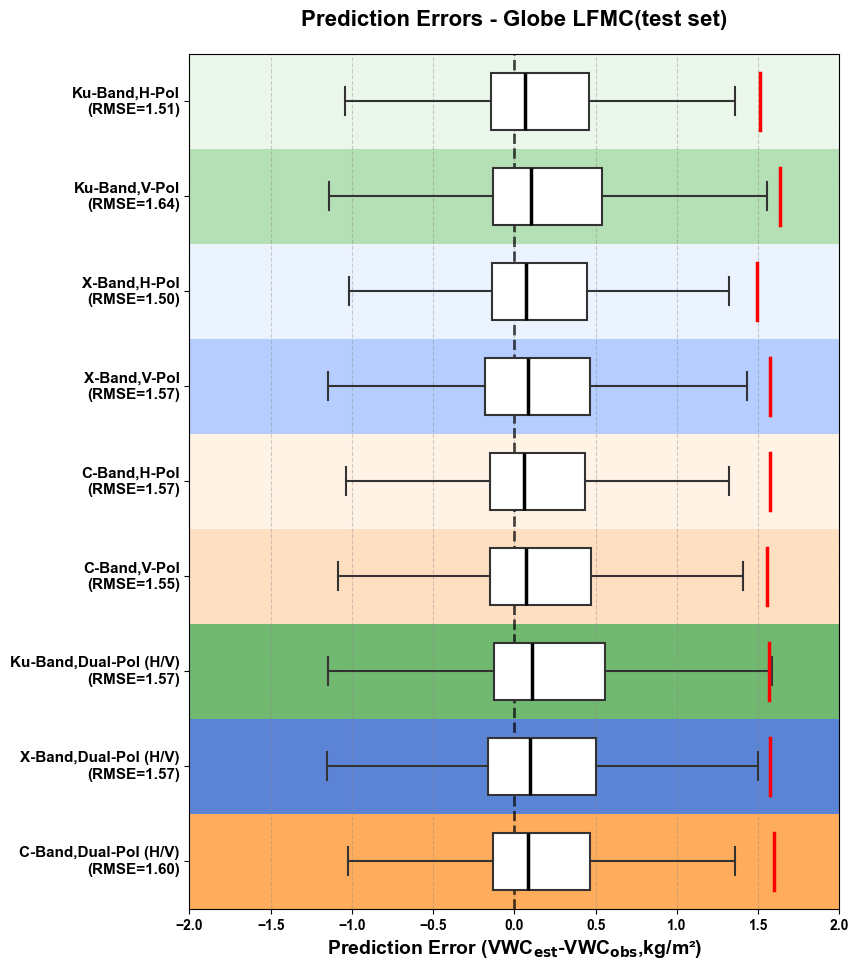

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# 设置全局字体（加粗）
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'

# 存储所有模型的测试结果
all_model_results = []

# 1. 按照您要求的顺序定义模型：从上方开始是Ku单极化，然后是X单极化、C单极化，最后是双极化
model_configs = [
    # Ku波段单极化
    {"label": "Ku-Band,H-Pol", "file": "test_data/test_rows_Ku_H-pol_Type1.csv", 
     "band": "Ku", "pol": "H", "color": "#e6f5e6"},
    {"label": "Ku-Band,V-Pol", "file": "test_data/test_rows_Ku_V-pol_Type1.csv", 
     "band": "Ku", "pol": "V", "color": "#a3d8a3"},
    
    # X波段单极化
    {"label": "X-Band,H-Pol", "file": "test_data/test_rows_X_H-pol_Type1.csv", 
     "band": "X", "pol": "H", "color": "#e6f0ff"},
    {"label": "X-Band,V-Pol", "file": "test_data/test_rows_X_V-pol_Type1.csv", 
     "band": "X", "pol": "V", "color": "#a3c2ff"},
    
    # C波段单极化
    {"label": "C-Band,H-Pol", "file": "test_data/test_rows_C_H-pol_Type1.csv", 
     "band": "C", "pol": "H", "color": "#fff0e0"},
    {"label": "C-Band,V-Pol", "file": "test_data/test_rows_C_V-pol_Type1.csv", 
     "band": "C", "pol": "V", "color": "#ffd8b3"},
    
    # 双极化
    {"label": "Ku-Band,Dual-Pol (H/V)", "file": "test_data/test_rows_Ku_HV-pol_Type1.csv", 
     "band": "Ku", "pol": "HV", "color": "#4da64d"},
    {"label": "X-Band,Dual-Pol (H/V)", "file": "test_data/test_rows_X_HV-pol_Type1.csv", 
     "band": "X", "pol": "HV", "color": "#3366cc"},
    {"label": "C-Band,Dual-Pol (H/V)", "file": "test_data/test_rows_C_HV-pol_Type1.csv", 
     "band": "C", "pol": "HV", "color": "#ff9933"}
]

# 2. 加载所有测试结果
print("Loading test set predictions...")
for config in model_configs:
    file_path = config["file"]
    if os.path.exists(file_path):
        # 读取CSV文件
        df = pd.read_csv(file_path)
        
        # 正确计算VWC_sample：使用AGB和LFMCValue列
        if 'AGB' in df.columns and 'LFMCValue' in df.columns:
            df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000
        # 如果原始测试集已经包含VWC_sample则直接使用
        elif 'VWC_sample' in df.columns:
            pass
        else:
            print(f"Warning: Missing required columns in {file_path}")
            continue
        
        # 计算残差（预测值 - 实际值）
        residuals = df['y_pred'] - df['VWC_sample']
        
        # 保存结果
        all_model_results.append({
            'label': config["label"],
            'residuals': residuals,
            'n_samples': len(residuals),
            'color': config["color"]
        })
        print(f"Loaded: {config['label']} ({len(residuals)} samples)")
    else:
        print(f"Warning: File not found - {file_path}")

# 3. 绘制残差箱线图
print("\nPlotting residual boxplots...")

# 准备绘图数据
residuals_data = [result['residuals'] for result in all_model_results]
plot_labels = [result['label'] for result in all_model_results]
background_colors = [result['color'] for result in all_model_results]

# 计算每个模型的RMSE
rmse_values = []
for residuals in residuals_data:
    rmse = np.sqrt(np.mean(np.square(residuals)))
    rmse_values.append(rmse)

# 创建图形（增加高度以容纳所有标签）
plt.figure(figsize=(10, 9.5))  # 增加高度到9.5英寸
ax = plt.gca()

# 设置y轴位置（从上方开始）
y_positions = list(range(len(all_model_results), 0, -1))

# 添加彩色背景条 - 完全覆盖无间隙
# 创建连续背景条而不是单独间隔
for i in range(len(y_positions)):
    # 计算当前条带的上边界和下边界
    ymin = y_positions[i] - 0.5
    ymax = y_positions[i] + 0.5
    
    # 创建连续背景条（无间隙）
    ax.axhspan(
        ymin = ymin, 
        ymax = ymax, 
        facecolor=background_colors[i], 
        alpha=0.8, 
        edgecolor='none',  # 移除边缘线
        zorder=0
    )

# 创建水平箱线图样式（白色箱体）
boxprops = dict(linestyle='-', linewidth=1.5, color='#333333')  # 暗色边框
medianprops = dict(linestyle='-', linewidth=2.5, color='black')   # 黑色中线
whiskerprops = dict(linestyle='-', linewidth=1.5, color='#333333')  # 暗色须线
capprops = dict(linestyle='-', linewidth=1.5, color='#333333')  # 暗色帽子

# 绘制箱线图（使用正确的y位置）
bplot = plt.boxplot(
    residuals_data,
    positions=y_positions,  # 关键：从顶部开始
    vert=False,            # 水平箱线图
    patch_artist=True,    # 允许填充颜色
    showfliers=False,     # 不显示离群点
    boxprops=boxprops,
    medianprops=medianprops,
    whiskerprops=whiskerprops,
    capprops=capprops,
    zorder=3,             # 确保箱线图在背景上层
    widths=0.6            # 增大箱体宽度以匹配背景
)

# 设置箱体填充为白色
for patch in bplot['boxes']:
    patch.set_facecolor('white')
    patch.set_alpha(1.0)  # 完全不透明

# 在每个模型位置添加RMSE红线（与中位线相同长度）
for i, (rmse, y_pos) in enumerate(zip(rmse_values, y_positions)):
    plt.plot(
        [rmse, rmse],  # x位置（RMSE值）
        [y_pos - 0.3, y_pos + 0.3],  # y位置（与中位线相同长度）
        color='red',  # 红色实线
        linewidth=2.5,  # 线宽
        linestyle='-',  # 实线
        zorder=4  # 在箱线图上层
    )

# 创建新的纵轴标签（包含RMSE值）
new_labels = []
for i, (label, rmse) in enumerate(zip(plot_labels, rmse_values)):
    # 格式化为：Ku-Band,H-Pol\n(RMSE=1.51)
    new_label = f"{label}\n(RMSE={rmse:.2f}kg/m²)"
    new_labels.append(new_label)

# 设置y轴刻度和标签（使用新的包含RMSE的标签）
plt.yticks(y_positions, new_labels, fontsize=11)

# 关键：调整纵轴标签垂直居中
# 获取y轴刻度标签对象
ytick_labels = ax.get_yticklabels()
for label in ytick_labels:
    label.set_verticalalignment('center')  # 垂直居中
    label.set_horizontalalignment('right')  # 水平右对齐

plt.xlabel(r'Prediction Error (VWC$_{\mathrm{est}}$-VWC$_{\mathrm{obs}}$,kg/m²)', fontsize=14, fontweight='bold')

# 关键：设置y轴范围完全覆盖背景条
plt.ylim(min(y_positions) - 0.5, max(y_positions) + 0.5)
plt.xlim(-2, 2)
# 添加标题
plt.title('Prediction Errors - Globe LFMC(test set)', fontsize=16, fontweight='bold', pad=20)

# 添加零参考线
plt.axvline(x=0, color='black', linestyle='--', linewidth=2, alpha=0.7, zorder=2)

# 添加网格线（仅水平方向）
ax.grid(True, axis='x', linestyle='--', color='#888888', alpha=0.4)
ax.grid(False, axis='y')  # 关闭垂直方向的网格线

# 调整布局 - 增加左侧边距以容纳新标签
plt.subplots_adjust(top=0.95, bottom=0.05, left=0.25)

# 保存图像
os.makedirs("figures", exist_ok=True)
boxplot_path = "figures/residual_boxplots.png"
plt.savefig(boxplot_path, dpi=300, bbox_inches='tight')
print(f"Residual boxplot saved to: {boxplot_path}")
plt.show()

## 1'.2 再次尝试 只加入静态数据树高(VOD、SM、PFT、LAI、Hveg)（输入变量归一化）

In [2]:
# 9模型集合训练代码（添加Hveg变量）
import pandas as pd
import numpy as np
import time
import random
import os
import joblib
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import optuna
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib.gridspec as gridspec

# 设置随机种子保证可重复性
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# 存储所有模型的测试结果
all_model_results = []

def load_and_preprocess_data(file_path, sheet_name, vod_columns):
    """数据加载函数 - 返回处理后的特征和目标（添加Hveg变量）"""
    print(f"加载数据: {sheet_name}...")
    start_time = time.time()
    
    # 添加Hveg到基础列
    base_columns = [
        'AGB', 'SM_Asc', 'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne',
        'LAI', 'LFMCValue', 'SamplingDate', 'Hveg'  # 添加Hveg列
    ]
    columns_to_extract = base_columns + vod_columns
    
    # 读取数据（保留原始索引）
    df = pd.read_excel(file_path, sheet_name=sheet_name, usecols=columns_to_extract)
    
    # 计算VWC_sample并过滤
    df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000
    df = df[df['VWC_sample'] <= 30]
    
    # 特征工程
    df['Year_diff'] = df['SamplingDate'].dt.year.apply(lambda x: 2020 - x)
    df['LAI'] = clip(df['LAI'].clip(0, 6) / 6
    # 添加Hveg归一化（除以40，不进行裁剪）
    df['Hveg'] = df['Hveg'].clip(0, 40) / 40
    df = df.rename(columns={'SM_Asc': 'SM'})
    
    # 处理VOD列
    vod_features = []
    for i, col in enumerate(vod_columns):
        feature_name = 'VOD' if len(vod_columns) == 1 else f'VOD-{"H" if i == 0 else "V"}pol'
        df[feature_name] = df[col].clip(0, 2) / 2
        df = df.drop(col, axis=1)
        vod_features.append(feature_name)
    
    # 定义特征和目标列（添加Hveg变量）
    feature_columns = vod_features + [
        'LAI', 'SM', 'Hveg',  # 添加Hveg变量
        'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
    ]
    
    X = df[feature_columns]
    y = df['VWC_sample']
    
    print(f"数据预处理完成, 耗时: {(time.time()-start_time)/60:.2f}分钟")
    return X, y, df.index  # 返回处理后的索引

def objective(trial, X_train, y_train):
    """贝叶斯优化目标函数"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'max_depth': trial.suggest_int('max_depth', 10, 100, step=10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    model = RandomForestRegressor(**params, random_state=SEED, n_jobs=-1)
    
    # 五折交叉验证
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    rmse_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

def plot_results(y_true, y_pred, title, filename):
    """结果可视化函数（添加Hveg标识）"""
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.figure(figsize=(6, 6))
    
    # 计算RMSE指标
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # 绘制散点图
    plt.scatter(
        y_true, y_pred,
        marker='x',  # 叉形标记
        color='#FF0000',  # 边缘颜色
        linewidths=0.5,  # 边缘线宽
        s=40,  # 点的大小
        alpha=0.8,
        zorder=2
    )
    
    # 添加1:1参考线
    max_val = max(max(y_true), max(y_pred))
    plt.plot([0, max_val], [0, max_val], 'k--', lw=1.5, alpha=0.7, zorder=1)
    
    # 设置坐标轴范围和标签
    plt.xlim(0, 30)
    plt.ylim(0, 30)
    plt.xlabel('Insitu VWC (kg/m2)', fontsize=12, fontname='Arial', fontweight='bold')
    plt.ylabel('RF VWC (kg/m2)', fontsize=12, fontname='Arial', fontweight='bold')
    
    # 设置标题（添加Hveg标识）
    plt.title(title + " (Hveg Added)", fontsize=16, pad=20, fontweight='bold')  # 添加标识
    
    # 添加RMSE指标文本
    plt.text(0.05, 0.95,
             f'RMSE = {rmse:.3f} kg/m²',
             transform=plt.gca().transAxes,
             fontsize=12,
             fontweight='bold',
             verticalalignment='top')
    
    # 网格线和样式调整
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_axisbelow(True)
    plt.tight_layout()
    
    # 保存图像（添加后缀）
    os.makedirs("figures", exist_ok=True)
    plot_path = f"figures/{filename}_AddHveg.png"  # 添加后缀
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"预测图保存至: {plot_path}")
    plt.close()

def plot_residual_boxplots():
    """绘制所有模型的残差箱线图（翻转90°）"""
    print("\n绘制残差箱线图...")
    
    # 检查是否有结果数据
    if not all_model_results:
        print("警告: 没有模型结果数据可用")
        return
    
    # 准备数据
    residuals_data = []
    model_labels = []
    
    # 收集每个模型的残差（预测值 - 实际值）
    for result in all_model_results:
        band = result['band']
        pol = result['polarization']
        residuals = result['y_pred'] - result['y_test']
        residuals_data.append(residuals)
        model_labels.append(f"{band}-{pol}")
    
    # 创建图形
    plt.figure(figsize=(12, 10))
    
    # 创建水平箱线图（翻转90°）
    boxprops = dict(linestyle='-', linewidth=1.5, color='blue')
    medianprops = dict(linestyle='-', linewidth=2.5, color='red')
    whiskerprops = dict(linestyle='-', linewidth=1.5, color='black')
    capprops = dict(linestyle='-', linewidth=1.5, color='black')
    
    # 绘制箱线图（不显示离群点）
    bplot = plt.boxplot(
        residuals_data,
        vert=False,  # 水平箱线图
        patch_artist=True,
        showfliers=False,  # 不显示离群点
        boxprops=boxprops,
        medianprops=medianprops,
        whiskerprops=whiskerprops,
        capprops=capprops
    )
    
    # 设置箱体填充颜色
    for patch in bplot['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)
    
    # 设置坐标轴标签
    plt.yticks(range(1, len(model_labels)+1), model_labels, fontsize=12)
    plt.xlabel('预测值与实测值之差 (kg/m²)', fontsize=14, fontweight='bold')
    plt.ylabel('模型', fontsize=14, fontweight='bold')
    
    # 添加标题
    plt.title('各模型预测值与实测值差异分布（测试集）Hveg Added', fontsize=16, fontweight='bold', pad=20)  # 添加标识
    
    # 添加零参考线
    plt.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
    
    # 添加网格
    plt.grid(True, axis='x', linestyle='--', alpha=0.3)
    
    # 添加箱线图说明
    plt.text(0.95, 0.02, 
             "箱体: 25%-75%分位数\n中线: 中位数\n须线: 非异常值范围",
             transform=plt.gca().transAxes,
             fontsize=10,
             horizontalalignment='right',
             verticalalignment='bottom',
             bbox=dict(facecolor='white', alpha=0.8))
    
    # 调整布局
    plt.tight_layout()
    
    # 保存图像（添加后缀）
    boxplot_path = "figures/residual_boxplots_AddHveg.png"  # 添加后缀
    plt.savefig(boxplot_path, dpi=300, bbox_inches='tight')
    print(f"残差箱线图保存至: {boxplot_path}")
    plt.close()

def train_and_evaluate_model(config):
    """通用模型训练与评估函数（添加Hveg后缀）"""
    # 配置参数
    band = config['band']
    polarization = config['polarization']
    file_path = config['file_path']
    sheet_name = config['sheet_name']
    vod_columns = config['vod_columns']
    filename_suffix = f"{band}_{polarization.replace('+', '')}_Type1"
    
    print(f"\n{'='*50}")
    print(f"开始训练 {band}波段 {polarization} 极化模型（添加Hveg变量）")  # 添加说明
    print(f"{'='*50}")
    
    # 1. 数据加载与预处理
    X, y, processed_indices = load_and_preprocess_data(file_path, sheet_name, vod_columns)
    
    # 2. 数据划分 (保留原始索引)
    X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
        X, y, processed_indices,
        test_size=0.333,
        random_state=SEED,
        shuffle=True
    )
    
    # 3. 贝叶斯优化调参
    print("\n开始贝叶斯优化调参...")
    study = optuna.create_study(
        study_name=f"VWC_Optimization_{filename_suffix}",
        direction='minimize',
        sampler=TPESampler(seed=SEED)
    )
    
    study.optimize(lambda trial: objective(trial, X_train, y_train), 
                   n_trials=100, show_progress_bar=True)
    
    # 获取最佳参数
    best_params = study.best_params
    print("\n最佳参数组合:")
    for key, value in best_params.items():
        print(f"{key}: {value}")
    print(f"最佳验证RMSE: {study.best_value:.4f}")
    
    # 4. 使用最佳参数训练最终模型
    print("\n训练最终模型...")
    final_model = RandomForestRegressor(
        **best_params,
        random_state=SEED,
        n_jobs=-1
    )
    final_model.fit(X_train, y_train)
    
    # 5. 测试集评估
    print("\n测试集评估...")
    y_pred = final_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"测试集 RMSE: {test_rmse:.4f}")
    
    # 6. 保存测试集对应原始行（添加后缀）
    test_data_dir = "test_data"
    os.makedirs(test_data_dir, exist_ok=True)

    # 读取原始表格（仅测试集对应行）
    test_rows = pd.read_excel(
        file_path, 
        sheet_name=sheet_name,
        usecols=None,  # 读取所有列
    ).loc[test_idx]
    test_rows['y_pred'] = y_pred

    # 保存精简数据集（添加后缀）
    test_data_path = f"{test_data_dir}/test_rows_{filename_suffix}_AddHveg.csv"  # 添加后缀
    test_rows.to_csv(test_data_path, index=False)
    print(f"测试集对应原始行已保存至: {test_data_path}") 
    
    # 7. 可视化预测结果（在函数内部已添加后缀）
    plot_results(y_test, y_pred, 
                f"{band}-Band, {polarization}", 
                f"prediction_results_{filename_suffix}")
    
    # 8. 保存模型（添加后缀）
    os.makedirs("models", exist_ok=True)
    model_path = f"models/RFR_{filename_suffix}_AddHveg.pkl"  # 添加后缀
    joblib.dump(final_model, model_path)
    print(f"模型已保存至: {model_path}")
    
    # 9. 存储结果用于汇总
    all_model_results.append({
        'band': band,
        'polarization': polarization,
        'rmse': test_rmse,
        'r2': r2_score(y_test, y_pred),
        'test_data_path': test_data_path,  # 保存路径引用
        'n_samples': len(y_test),
        'y_test': y_test.values,  # 存储实际值用于残差分析
        'y_pred': y_pred  # 存储预测值用于残差分析
    })
    
    return final_model

if __name__ == "__main__":
    # 定义9种实验配置（所有配置添加Hveg变量）
    experiments = [
        # Ku波段实验
        {
            'band': 'Ku',
            'polarization': 'H-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx",
            'sheet_name': "VOD_Ku_Hpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_Ku_Hpol_Asc']
        },
        {
            'band': 'Ku',
            'polarization': 'V-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx",
            'sheet_name': "VOD_Ku_Vpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_Ku_Vpol_Asc']
        },
        {
            'band': 'Ku',
            'polarization': 'H+V-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_DualPol_ML_Data.xlsx",
            'sheet_name': "VOD_Ku_HVpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_Ku_Hpol_Asc', 'VOD_Ku_Vpol_Asc']
        },
        
        # X波段实验
        {
            'band': 'X',
            'polarization': 'H-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx",
            'sheet_name': "VOD_X_Hpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_X_Hpol_Asc']
        },
        {
            'band': 'X',
            'polarization': 'V-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx",
            'sheet_name': "VOD_X_Vpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_X_Vpol_Asc']
        },
        {
            'band': 'X',
            'polarization': 'H+V-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_DualPol_ML_Data.xlsx",
            'sheet_name': "VOD_X_HVpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_X_Hpol_Asc', 'VOD_X_Vpol_Asc']
        },
        
        # C波段实验
        {
            'band': 'C',
            'polarization': 'H-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx",
            'sheet_name': "VOD_C_Hpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_C_Hpol_Asc']
        },
        {
            'band': 'C',
            'polarization': 'V-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx",
            'sheet_name': "VOD_C_Vpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_C_Vpol_Asc']
        },
        {
            'band': 'C',
            'polarization': 'H+V-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_DualPol_ML_Data.xlsx",
            'sheet_name': "VOD_C_HVpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_C_Hpol_Asc', 'VOD_C_Vpol_Asc']
        }
    ]
    
    # 依次训练所有模型
    for exp_config in experiments:
        train_and_evaluate_model(exp_config)
        print("\n" + "="*50 + "\n")
    
    # 绘制残差箱线图（测试集结果）
    plot_residual_boxplots()
    
    # 打印结果总结
    print("\n所有模型结果总结（添加Hveg变量）：")
    for result in all_model_results:
        print(f"{result['band']}波段 {result['polarization']}极化: "
              f"RMSE = {result['rmse']:.4f}, R² = {result['r2']:.4f}")


开始训练 Ku波段 H-pol 极化模型（添加Hveg变量）
加载数据: VOD_Ku_Hpol_Asc_Cleaned_Type1...


[I 2025-08-19 14:17:25,058] A new study created in memory with name: VWC_Optimization_Ku_H-pol_Type1


数据预处理完成, 耗时: 0.79分钟

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-19 14:17:35,592] Trial 0 finished with value: 1.5706383966569626 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.5706383966569626.
[I 2025-08-19 14:17:49,405] Trial 1 finished with value: 1.5729247275355966 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.5706383966569626.
[I 2025-08-19 14:17:57,064] Trial 2 finished with value: 1.5700312445860445 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 2 with value: 1.5700312445860445.
[I 2025-08-19 14:18:05,489] Trial 3 finished with value: 1.5854878916432598 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sa

[I 2025-08-19 14:43:33,941] A new study created in memory with name: VWC_Optimization_Ku_V-pol_Type1


数据预处理完成, 耗时: 0.72分钟

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-19 14:43:41,688] Trial 0 finished with value: 1.6899561150776705 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.6899561150776705.
[I 2025-08-19 14:43:51,650] Trial 1 finished with value: 1.6939949263064105 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.6899561150776705.
[I 2025-08-19 14:43:57,513] Trial 2 finished with value: 1.6933889863620961 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.6899561150776705.
[I 2025-08-19 14:44:04,228] Trial 3 finished with value: 1.7112048832457376 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sa

KeyboardInterrupt: 

In [ ]:
# 箱线图
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# 设置全局字体（加粗）
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'

# 存储所有模型的测试结果
all_model_results = []

# 1. 按照您要求的顺序定义模型：从上方开始是Ku单极化，然后是X单极化、C单极化，最后是双极化
model_configs = [
    # Ku波段单极化
    {"label": "Ku-Band,H-Pol", "file": "test_data/test_rows_Ku_H-pol_Type1_AddHveg.csv",  # 添加后缀
     "band": "Ku", "pol": "H", "color": "#e6f5e6"},
    {"label": "Ku-Band,V-Pol", "file": "test_data/test_rows_Ku_V-pol_Type1_AddHveg.csv",  # 添加后缀
     "band": "Ku", "pol": "V", "color": "#a3d8a3"},
    
    # X波段单极化
    {"label": "X-Band,H-Pol", "file": "test_data/test_rows_X_H-pol_Type1_AddHveg.csv",  # 添加后缀
     "band": "X", "pol": "H", "color": "#e6f0ff"},
    {"label": "X-Band,V-Pol", "file": "test_data/test_rows_X_V-pol_Type1_AddHveg.csv",  # 添加后缀
     "band": "X", "pol": "V", "color": "#a3c2ff"},
    
    # C波段单极化
    {"label": "C-Band,H-Pol", "file": "test_data/test_rows_C_H-pol_Type1_AddHveg.csv",  # 添加后缀
     "band": "C", "pol": "H", "color": "#fff0e0"},
    {"label": "C-Band,V-Pol", "file": "test_data/test_rows_C_V-pol_Type1_AddHveg.csv",  # 添加后缀
     "band": "C", "pol": "V", "color": "#ffd8b3"},
    
    # 双极化
    {"label": "Ku-Band,Dual-Pol (H/V)", "file": "test_data/test_rows_Ku_HV-pol_Type1_AddHveg.csv",  # 添加后缀
     "band": "Ku", "pol": "HV", "color": "#4da64d"},
    {"label": "X-Band,Dual-Pol (H/V)", "file": "test_data/test_rows_X_HV-pol_Type1_AddHveg.csv",  # 添加后缀
     "band": "X", "pol": "HV", "color": "#3366cc"},
    {"label": "C-Band,Dual-Pol (H/V)", "file": "test_data/test_rows_C_HV-pol_Type1_AddHveg.csv",  # 添加后缀
     "band": "C", "pol": "HV", "color": "#ff9933"}
]

# 2. 加载所有测试结果
print("加载添加Hveg变量的测试集预测...")
for config in model_configs:
    file_path = config["file"]
    if os.path.exists(file_path):
        # 读取CSV文件
        df = pd.read_csv(file_path)
        
        # 正确计算VWC_sample：使用AGB和LFMCValue列
        if 'AGB' in df.columns and 'LFMCValue' in df.columns:
            df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000
        # 如果原始测试集已经包含VWC_sample则直接使用
        elif 'VWC_sample' in df.columns:
            pass
        else:
            print(f"警告: 缺少必要列 - {file_path}")
            continue
        
        # 计算残差（预测值 - 实际值）
        residuals = df['y_pred'] - df['VWC_sample']
        
        # 保存结果
        all_model_results.append({
            'label': config["label"],
            'residuals': residuals,
            'n_samples': len(residuals),
            'color': config["color"]
        })
        print(f"已加载: {config['label']} ({len(residuals)} 样本)")
    else:
        print(f"警告: 文件未找到 - {file_path}")

# 3. 绘制残差箱线图
print("\n绘制残差箱线图(添加Hveg变量)...")

# 准备绘图数据
residuals_data = [result['residuals'] for result in all_model_results]
plot_labels = [result['label'] for result in all_model_results]
background_colors = [result['color'] for result in all_model_results]

# 计算每个模型的RMSE
rmse_values = []
for residuals in residuals_data:
    rmse = np.sqrt(np.mean(np.square(residuals)))
    rmse_values.append(rmse)

# 创建图形（增加高度以容纳所有标签）
plt.figure(figsize=(10, 9.5))  # 增加高度到9.5英寸
ax = plt.gca()

# 设置y轴位置（从上方开始）
y_positions = list(range(len(all_model_results), 0, -1))

# 添加彩色背景条 - 完全覆盖无间隙
# 创建连续背景条而不是单独间隔
for i in range(len(y_positions)):
    # 计算当前条带的上边界和下边界
    ymin = y_positions[i] - 0.5
    ymax = y_positions[i] + 0.5
    
    # 创建连续背景条（无间隙）
    ax.axhspan(
        ymin = ymin, 
        ymax = ymax, 
        facecolor=background_colors[i], 
        alpha=0.8, 
        edgecolor='none',  # 移除边缘线
        zorder=0
    )

# 创建水平箱线图样式（白色箱体）
boxprops = dict(linestyle='-', linewidth=1.5, color='#333333')  # 暗色边框
medianprops = dict(linestyle='-', linewidth=2.5, color='black')   # 黑色中线
whiskerprops = dict(linestyle='-', linewidth=1.5, color='#333333')  # 暗色须线
capprops = dict(linestyle='-', linewidth=1.5, color='#333333')  # 暗色帽子

# 绘制箱线图（使用正确的y位置）
bplot = plt.boxplot(
    residuals_data,
    positions=y_positions,  # 关键：从顶部开始
    vert=False,            # 水平箱线图
    patch_artist=True,    # 允许填充颜色
    showfliers=False,     # 不显示离群点
    boxprops=boxprops,
    medianprops=medianprops,
    whiskerprops=whiskerprops,
    capprops=capprops,
    zorder=3,             # 确保箱线图在背景上层
    widths=0.6            # 增大箱体宽度以匹配背景
)

# 设置箱体填充为白色
for patch in bplot['boxes']:
    patch.set_facecolor('white')
    patch.set_alpha(1.0)  # 完全不透明

# 在每个模型位置添加RMSE红线（与中位线相同长度）
for i, (rmse, y_pos) in enumerate(zip(rmse_values, y_positions)):
    plt.plot(
        [rmse, rmse],  # x位置（RMSE值）
        [y_pos - 0.3, y_pos + 0.3],  # y位置（与中位线相同长度）
        color='red',  # 红色实线
        linewidth=2.5,  # 线宽
        linestyle='-',  # 实线
        zorder=4  # 在箱线图上层
    )

# 创建新的纵轴标签（包含RMSE值）
new_labels = []
for i, (label, rmse) in enumerate(zip(plot_labels, rmse_values)):
    # 格式化为：Ku-Band,H-Pol\n(RMSE=1.51)
    new_label = f"{label}\n(RMSE={rmse:.2f}kg/m²)"
    new_labels.append(new_label)

# 设置y轴刻度和标签（使用新的包含RMSE的标签）
plt.yticks(y_positions, new_labels, fontsize=11)

# 关键：调整纵轴标签垂直居中
# 获取y轴刻度标签对象
ytick_labels = ax.get_yticklabels()
for label in ytick_labels:
    label.set_verticalalignment('center')  # 垂直居中
    label.set_horizontalalignment('right')  # 水平右对齐

plt.xlabel(r'Prediction Error (VWC$_{\mathrm{est}}$-VWC$_{\mathrm{obs}}$,kg/m²)', fontsize=14, fontweight='bold')

# 关键：设置y轴范围完全覆盖背景条
plt.ylim(min(y_positions) - 0.5, max(y_positions) + 0.5)
plt.xlim(-2, 2)
# 添加标题
plt.title('Prediction Errors - Globe LFMC(test set)', fontsize=16, fontweight='bold', pad=20)  # 添加标识

# 添加零参考线
plt.axvline(x=0, color='black', linestyle='--', linewidth=2, alpha=0.7, zorder=2)

# 添加网格线（仅水平方向）
ax.grid(True, axis='x', linestyle='--', color='#888888', alpha=0.4)
ax.grid(False, axis='y')  # 关闭垂直方向的网格线

# 调整布局 - 增加左侧边距以容纳新标签
plt.subplots_adjust(top=0.95, bottom=0.05, left=0.25)

# 保存图像
os.makedirs("figures", exist_ok=True)
boxplot_path = "figures/residual_boxplots_AddHveg.png"  # 添加后缀
plt.savefig(boxplot_path, dpi=300, bbox_inches='tight')
print(f"残差箱线图已保存至: {boxplot_path}")
plt.show()

## 1'.3 输入同1'.2（去除SM）,所有变量都不裁剪和归一化(和以前本科做的时候的任务一样)

In [3]:
# 9模型集合训练代码（Primary版本）
import pandas as pd
import numpy as np
import time
import random
import os
import joblib
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import optuna
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib.gridspec as gridspec

# 设置随机种子保证可重复性
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# 存储所有模型的测试结果
all_model_results = []

def load_and_preprocess_data(file_path, sheet_name, vod_columns):
    """数据加载函数 - 返回处理后的特征和目标（Primary版本）"""
    print(f"加载数据: {sheet_name}...")
    start_time = time.time()
    
    # 基础列（已移除SM）
    base_columns = [
        'AGB', 
        'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne',
        'LAI', 'LFMCValue', 'SamplingDate', 'Hveg'
    ]
    columns_to_extract = base_columns + vod_columns
    
    # 读取数据（保留原始索引）
    df = pd.read_excel(file_path, sheet_name=sheet_name, usecols=columns_to_extract)
    
    # 计算VWC_sample并过滤
    df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000
    df = df[df['VWC_sample'] <= 30]
    
    # 特征工程（取消所有裁剪操作）
    df['Year_diff'] = df['SamplingDate'].dt.year.apply(lambda x: 2020 - x)
    df['LAI'] = df['LAI']  # 取消裁剪和归一化
    df['Hveg'] = df['Hveg']
    
    # 处理VOD列（取消裁剪）
    vod_features = []
    for i, col in enumerate(vod_columns):
        feature_name = 'VOD' if len(vod_columns) == 1 else f'VOD-{"H" if i == 0 else "V"}pol'
        df[feature_name] = df[col]  # 取消.clip(0, 2)和归一化
        df = df.drop(col, axis=1)
        vod_features.append(feature_name)
    
    # 定义特征和目标列（已移除SM）
    feature_columns = vod_features + [
        'LAI', 'Hveg',
        'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
    ]
    
    X = df[feature_columns]
    y = df['VWC_sample']
    
    print(f"数据预处理完成, 耗时: {(time.time()-start_time)/60:.2f}分钟")
    return X, y, df.index  # 返回处理后的索引

def objective(trial, X_train, y_train):
    """贝叶斯优化目标函数"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'max_depth': trial.suggest_int('max_depth', 10, 100, step=10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    model = RandomForestRegressor(**params, random_state=SEED, n_jobs=-1)
    
    # 五折交叉验证
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    rmse_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

def plot_results(y_true, y_pred, title, filename):
    """结果可视化函数（Primary标识）"""
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.figure(figsize=(6, 6))
    
    # 计算RMSE指标
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # 绘制散点图
    plt.scatter(
        y_true, y_pred,
        marker='x',  # 叉形标记
        color='#FF0000',  # 边缘颜色
        linewidths=0.5,  # 边缘线宽
        s=40,  # 点的大小
        alpha=0.8,
        zorder=2
    )
    
    # 添加1:1参考线
    max_val = max(max(y_true), max(y_pred))
    plt.plot([0, max_val], [0, max_val], 'k--', lw=1.5, alpha=0.7, zorder=1)
    
    # 设置坐标轴范围和标签
    plt.xlim(0, 30)
    plt.ylim(0, 30)
    plt.xlabel('Insitu VWC (kg/m2)', fontsize=12, fontname='Arial', fontweight='bold')
    plt.ylabel('RF VWC (kg/m2)', fontsize=12, fontname='Arial', fontweight='bold')
    
    # 设置标题（Primary标识）
    plt.title(title + " (Primary)", fontsize=16, pad=20, fontweight='bold')
    
    # 添加RMSE指标文本
    plt.text(0.05, 0.95,
             f'RMSE = {rmse:.3f} kg/m²',
             transform=plt.gca().transAxes,
             fontsize=12,
             fontweight='bold',
             verticalalignment='top')
    
    # 网格线和样式调整
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_axisbelow(True)
    plt.tight_layout()
    
    # 保存图像（添加后缀）
    os.makedirs("figures", exist_ok=True)
    plot_path = f"figures/{filename}_Primary.png"  # 修改后缀
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"预测图保存至: {plot_path}")
    plt.close()

def plot_residual_boxplots():
    """绘制所有模型的残差箱线图（翻转90°）"""
    print("\n绘制残差箱线图...")
    
    # 检查是否有结果数据
    if not all_model_results:
        print("警告: 没有模型结果数据可用")
        return
    
    # 准备数据
    residuals_data = []
    model_labels = []
    
    # 收集每个模型的残差（预测值 - 实际值）
    for result in all_model_results:
        band = result['band']
        pol = result['polarization']
        residuals = result['y_pred'] - result['y_test']
        residuals_data.append(residuals)
        model_labels.append(f"{band}-{pol}")
    
    # 创建图形
    plt.figure(figsize=(12, 10))
    
    # 创建水平箱线图（翻转90°）
    boxprops = dict(linestyle='-', linewidth=1.5, color='blue')
    medianprops = dict(linestyle='-', linewidth=2.5, color='red')
    whiskerprops = dict(linestyle='-', linewidth=1.5, color='black')
    capprops = dict(linestyle='-', linewidth=1.5, color='black')
    
    # 绘制箱线图（不显示离群点）
    bplot = plt.boxplot(
        residuals_data,
        vert=False,  # 水平箱线图
        patch_artist=True,
        showfliers=False,  # 不显示离群点
        boxprops=boxprops,
        medianprops=medianprops,
        whiskerprops=whiskerprops,
        capprops=capprops
    )
    
    # 设置箱体填充颜色
    for patch in bplot['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)
    
    # 设置坐标轴标签
    plt.yticks(range(1, len(model_labels)+1), model_labels, fontsize=12)
    plt.xlabel('预测值与实测值之差 (kg/m²)', fontsize=14, fontweight='bold')
    plt.ylabel('模型', fontsize=14, fontweight='bold')
    
    # 添加标题
    plt.title('各模型预测值与实测值差异分布（测试集）Primary', fontsize=16, fontweight='bold', pad=20)
    
    # 添加零参考线
    plt.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
    
    # 添加网格
    plt.grid(True, axis='x', linestyle='--', alpha=0.3)
    
    # 添加箱线图说明
    plt.text(0.95, 0.02, 
             "箱体: 25%-75%分位数\n中线: 中位数\n须线: 非异常值范围",
             transform=plt.gca().transAxes,
             fontsize=10,
             horizontalalignment='right',
             verticalalignment='bottom',
             bbox=dict(facecolor='white', alpha=0.8))
    
    # 调整布局
    plt.tight_layout()
    
    # 保存图像（修改后缀）
    boxplot_path = "figures/residual_boxplots_Primary.png"
    plt.savefig(boxplot_path, dpi=300, bbox_inches='tight')
    print(f"残差箱线图保存至: {boxplot_path}")
    plt.close()

def train_and_evaluate_model(config):
    """通用模型训练与评估函数（Primary后缀）"""
    # 配置参数
    band = config['band']
    polarization = config['polarization']
    file_path = config['file_path']
    sheet_name = config['sheet_name']
    vod_columns = config['vod_columns']
    filename_suffix = f"{band}_{polarization.replace('+', '')}_Type1"
    
    print(f"\n{'='*50}")
    print(f"开始训练 {band}波段 {polarization} 极化模型（Primary版本）")
    print(f"{'='*50}")
    
    # 1. 数据加载与预处理
    X, y, processed_indices = load_and_preprocess_data(file_path, sheet_name, vod_columns)
    
    # 2. 数据划分 (保留原始索引)
    X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
        X, y, processed_indices,
        test_size=0.333,
        random_state=SEED,
        shuffle=True
    )
    
    # 3. 贝叶斯优化调参
    print("\n开始贝叶斯优化调参...")
    study = optuna.create_study(
        study_name=f"VWC_Optimization_{filename_suffix}",
        direction='minimize',
        sampler=TPESampler(seed=SEED)
    )
    
    study.optimize(lambda trial: objective(trial, X_train, y_train), 
                   n_trials=100, show_progress_bar=True)
    
    # 获取最佳参数
    best_params = study.best_params
    print("\n最佳参数组合:")
    for key, value in best_params.items():
        print(f"{key}: {value}")
    print(f"最佳验证RMSE: {study.best_value:.4f}")
    
    # 4. 使用最佳参数训练最终模型
    print("\n训练最终模型...")
    final_model = RandomForestRegressor(
        **best_params,
        random_state=SEED,
        n_jobs=-1
    )
    final_model.fit(X_train, y_train)
    
    # 5. 测试集评估
    print("\n测试集评估...")
    y_pred = final_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"测试集 RMSE: {test_rmse:.4f}")
    
    # 6. 保存测试集对应原始行（修改后缀）
    test_data_dir = "test_data"
    os.makedirs(test_data_dir, exist_ok=True)

    # 读取原始表格（仅测试集对应行）
    test_rows = pd.read_excel(
        file_path, 
        sheet_name=sheet_name,
        usecols=None,  # 读取所有列
    ).loc[test_idx]
    test_rows['y_pred'] = y_pred

    # 保存精简数据集（修改后缀）
    test_data_path = f"{test_data_dir}/test_rows_{filename_suffix}_Primary.csv"
    test_rows.to_csv(test_data_path, index=False)
    print(f"测试集对应原始行已保存至: {test_data_path}") 
    
    # 7. 可视化预测结果
    plot_results(y_test, y_pred, 
                f"{band}-Band, {polarization}", 
                f"prediction_results_{filename_suffix}")
    
    # 8. 保存模型（修改后缀）
    os.makedirs("models", exist_ok=True)
    model_path = f"models/RFR_{filename_suffix}_Primary.pkl"
    joblib.dump(final_model, model_path)
    print(f"模型已保存至: {model_path}")
    
    # 9. 存储结果用于汇总
    all_model_results.append({
        'band': band,
        'polarization': polarization,
        'rmse': test_rmse,
        'r2': r2_score(y_test, y_pred),
        'test_data_path': test_data_path,  # 保存路径引用
        'n_samples': len(y_test),
        'y_test': y_test.values,  # 存储实际值用于残差分析
        'y_pred': y_pred  # 存储预测值用于残差分析
    })
    
    return final_model

if __name__ == "__main__":
    # 定义9种实验配置（Primary版本）
    experiments = [
        # Ku波段实验
        {
            'band': 'Ku',
            'polarization': 'H-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx",
            'sheet_name': "VOD_Ku_Hpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_Ku_Hpol_Asc']
        },
        {
            'band': 'Ku',
            'polarization': 'V-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx",
            'sheet_name': "VOD_Ku_Vpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_Ku_Vpol_Asc']
        },
        {
            'band': 'Ku',
            'polarization': 'H+V-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_DualPol_ML_Data.xlsx",
            'sheet_name': "VOD_Ku_HVpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_Ku_Hpol_Asc', 'VOD_Ku_Vpol_Asc']
        },
        
        # X波段实验
        {
            'band': 'X',
            'polarization': 'H-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx",
            'sheet_name': "VOD_X_Hpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_X_Hpol_Asc']
        },
        {
            'band': 'X',
            'polarization': 'V-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx",
            'sheet_name': "VOD_X_Vpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_X_Vpol_Asc']
        },
        {
            'band': 'X',
            'polarization': 'H+V-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_DualPol_ML_Data.xlsx",
            'sheet_name': "VOD_X_HVpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_X_Hpol_Asc', 'VOD_X_Vpol_Asc']
        },
        
        # C波段实验
        {
            'band': 'C',
            'polarization': 'H-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx",
            'sheet_name': "VOD_C_Hpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_C_Hpol_Asc']
        },
        {
            'band': 'C',
            'polarization': 'V-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx",
            'sheet_name': "VOD_C_Vpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_C_Vpol_Asc']
        },
        {
            'band': 'C',
            'polarization': 'H+V-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_DualPol_ML_Data.xlsx",
            'sheet_name': "VOD_C_HVpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_C_Hpol_Asc', 'VOD_C_Vpol_Asc']
        }
    ]
    
    # 依次训练所有模型
    for exp_config in experiments:
        train_and_evaluate_model(exp_config)
        print("\n" + "="*50 + "\n")
    
    # # 绘制残差箱线图（测试集结果）
    # plot_residual_boxplots()
    
    # 打印结果总结
    print("\n所有模型结果总结（Primary版本）：")
    for result in all_model_results:
        print(f"{result['band']}波段 {result['polarization']}极化: "
              f"RMSE = {result['rmse']:.4f}, R² = {result['r2']:.4f}")


开始训练 Ku波段 H-pol 极化模型（Primary版本）
加载数据: VOD_Ku_Hpol_Asc_Cleaned_Type1...


[I 2025-08-19 14:58:08,929] A new study created in memory with name: VWC_Optimization_Ku_H-pol_Type1


数据预处理完成, 耗时: 0.59分钟

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-19 14:58:18,085] Trial 0 finished with value: 1.5923705781516229 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.5923705781516229.
[I 2025-08-19 14:58:29,688] Trial 1 finished with value: 1.575831858309367 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 1 with value: 1.575831858309367.
[I 2025-08-19 14:58:36,400] Trial 2 finished with value: 1.5807643259218092 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 1 with value: 1.575831858309367.
[I 2025-08-19 14:58:44,209] Trial 3 finished with value: 1.5760855509196758 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sampl

[I 2025-08-19 15:14:26,941] A new study created in memory with name: VWC_Optimization_Ku_V-pol_Type1


数据预处理完成, 耗时: 0.53分钟

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-19 15:14:33,966] Trial 0 finished with value: 1.6938064995446855 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.6938064995446855.
[I 2025-08-19 15:14:42,767] Trial 1 finished with value: 1.6923911461806393 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 1 with value: 1.6923911461806393.
[I 2025-08-19 15:14:47,983] Trial 2 finished with value: 1.6892762513725201 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 2 with value: 1.6892762513725201.
[I 2025-08-19 15:14:54,511] Trial 3 finished with value: 1.701538059259331 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sam

[I 2025-08-19 15:31:22,502] A new study created in memory with name: VWC_Optimization_Ku_HV-pol_Type1


数据预处理完成, 耗时: 0.45分钟

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-19 15:31:30,142] Trial 0 finished with value: 1.688809511610654 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.688809511610654.
[I 2025-08-19 15:31:39,958] Trial 1 finished with value: 1.6923862226774182 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.688809511610654.
[I 2025-08-19 15:31:46,036] Trial 2 finished with value: 1.6892720777754786 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.688809511610654.
[I 2025-08-19 15:31:52,879] Trial 3 finished with value: 1.7105061952028866 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sample

[I 2025-08-19 15:51:44,646] A new study created in memory with name: VWC_Optimization_X_H-pol_Type1


数据预处理完成, 耗时: 0.77分钟

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-19 15:51:53,734] Trial 0 finished with value: 1.6608705608039336 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.6608705608039336.
[I 2025-08-19 15:52:05,508] Trial 1 finished with value: 1.6432702024784624 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 1 with value: 1.6432702024784624.
[I 2025-08-19 15:52:12,319] Trial 2 finished with value: 1.6489212982359853 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 1 with value: 1.6432702024784624.
[I 2025-08-19 15:52:19,684] Trial 3 finished with value: 1.6386974622837958 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sa

[I 2025-08-19 16:16:07,006] A new study created in memory with name: VWC_Optimization_X_V-pol_Type1


数据预处理完成, 耗时: 0.80分钟

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-19 16:16:15,126] Trial 0 finished with value: 1.6521032293791407 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.6521032293791407.
[I 2025-08-19 16:16:25,949] Trial 1 finished with value: 1.6431160459229246 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 1 with value: 1.6431160459229246.
[I 2025-08-19 16:16:32,187] Trial 2 finished with value: 1.6445714347638067 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 1 with value: 1.6431160459229246.
[I 2025-08-19 16:16:39,858] Trial 3 finished with value: 1.6460046700672095 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sa

[I 2025-08-19 16:33:56,767] A new study created in memory with name: VWC_Optimization_X_HV-pol_Type1


数据预处理完成, 耗时: 0.52分钟

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-19 16:34:07,029] Trial 0 finished with value: 1.6359656462809258 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.6359656462809258.
[I 2025-08-19 16:34:19,450] Trial 1 finished with value: 1.6391045163337292 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.6359656462809258.
[I 2025-08-19 16:34:26,357] Trial 2 finished with value: 1.639708789190972 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.6359656462809258.
[I 2025-08-19 16:34:34,154] Trial 3 finished with value: 1.6551349202386074 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sam

[I 2025-08-19 16:59:16,542] A new study created in memory with name: VWC_Optimization_C_H-pol_Type1


数据预处理完成, 耗时: 0.82分钟

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-19 16:59:25,807] Trial 0 finished with value: 1.6122262159873233 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.6122262159873233.
[I 2025-08-19 16:59:37,655] Trial 1 finished with value: 1.6029960935490473 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 1 with value: 1.6029960935490473.
[I 2025-08-19 16:59:44,240] Trial 2 finished with value: 1.602304562945142 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 2 with value: 1.602304562945142.
[I 2025-08-19 16:59:51,929] Trial 3 finished with value: 1.6048000815684649 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_samp

[I 2025-08-19 17:16:22,505] A new study created in memory with name: VWC_Optimization_C_V-pol_Type1


数据预处理完成, 耗时: 0.75分钟

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-19 17:16:30,405] Trial 0 finished with value: 1.6403412857093755 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.6403412857093755.
[I 2025-08-19 17:16:40,289] Trial 1 finished with value: 1.6337477246415422 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 1 with value: 1.6337477246415422.
[I 2025-08-19 17:16:46,355] Trial 2 finished with value: 1.6334548627436394 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 2 with value: 1.6334548627436394.
[I 2025-08-19 17:16:53,634] Trial 3 finished with value: 1.6358402491635124 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sa

[I 2025-08-19 17:35:00,319] A new study created in memory with name: VWC_Optimization_C_HV-pol_Type1


数据预处理完成, 耗时: 0.47分钟

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-19 17:35:09,055] Trial 0 finished with value: 1.604008287316153 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.604008287316153.
[I 2025-08-19 17:35:20,017] Trial 1 finished with value: 1.6074644020062105 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.604008287316153.
[I 2025-08-19 17:35:26,625] Trial 2 finished with value: 1.6043596280105348 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.604008287316153.
[I 2025-08-19 17:35:34,108] Trial 3 finished with value: 1.6217228228391263 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sample

加载添加Hveg变量的测试集预测...
已加载: Ku-Band,H-Pol (8851 样本)
已加载: Ku-Band,V-Pol (6252 样本)
已加载: X-Band,H-Pol (9005 样本)
已加载: X-Band,V-Pol (7917 样本)
已加载: C-Band,H-Pol (8984 样本)
已加载: C-Band,V-Pol (7361 样本)
已加载: Ku-Band,Dual-Pol (H/V) (6209 样本)
已加载: X-Band,Dual-Pol (H/V) (7917 样本)
已加载: C-Band,Dual-Pol (H/V) (7357 样本)

绘制残差箱线图(初始试验)...
残差箱线图已保存至: figures/residual_boxplots_Primary.png


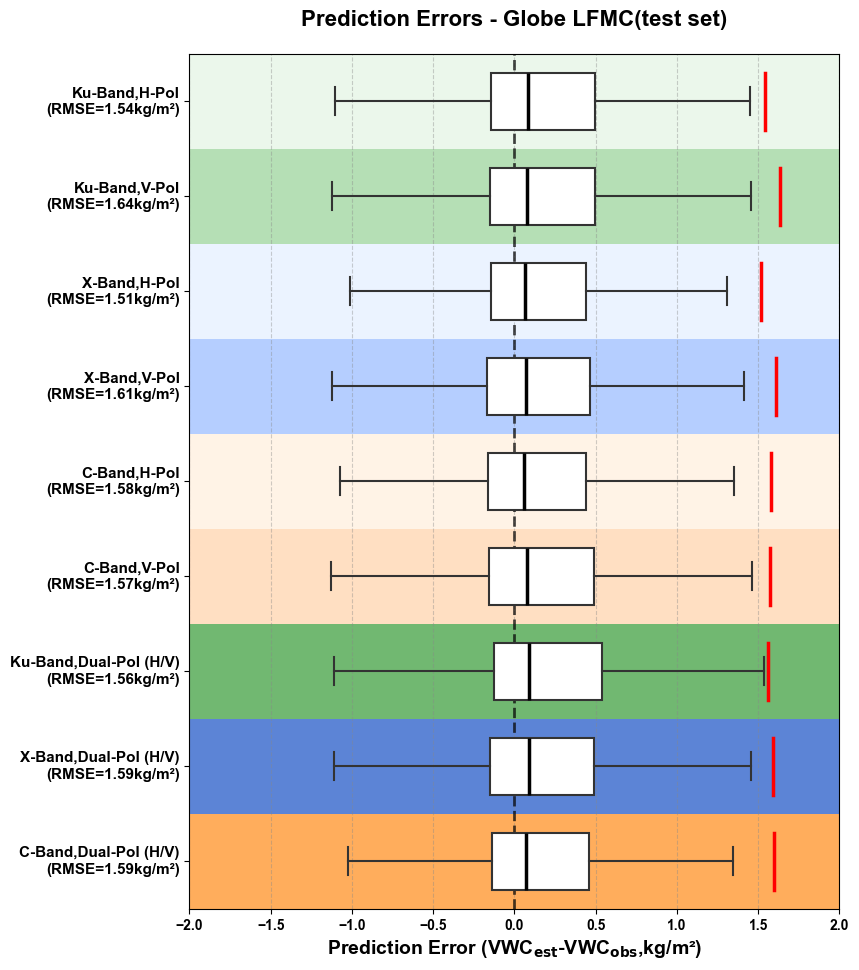

In [4]:
# 箱线图
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# 设置全局字体（加粗）
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'

# 存储所有模型的测试结果
all_model_results = []

# 1. 按照您要求的顺序定义模型：从上方开始是Ku单极化，然后是X单极化、C单极化，最后是双极化
model_configs = [
    # Ku波段单极化
    {"label": "Ku-Band,H-Pol", "file": "test_data/test_rows_Ku_H-pol_Type1_Primary.csv",  # 添加后缀
     "band": "Ku", "pol": "H", "color": "#e6f5e6"},
    {"label": "Ku-Band,V-Pol", "file": "test_data/test_rows_Ku_V-pol_Type1_Primary.csv",  # 添加后缀
     "band": "Ku", "pol": "V", "color": "#a3d8a3"},
    
    # X波段单极化
    {"label": "X-Band,H-Pol", "file": "test_data/test_rows_X_H-pol_Type1_Primary.csv",  # 添加后缀
     "band": "X", "pol": "H", "color": "#e6f0ff"},
    {"label": "X-Band,V-Pol", "file": "test_data/test_rows_X_V-pol_Type1_Primary.csv",  # 添加后缀
     "band": "X", "pol": "V", "color": "#a3c2ff"},
    
    # C波段单极化
    {"label": "C-Band,H-Pol", "file": "test_data/test_rows_C_H-pol_Type1_Primary.csv",  # 添加后缀
     "band": "C", "pol": "H", "color": "#fff0e0"},
    {"label": "C-Band,V-Pol", "file": "test_data/test_rows_C_V-pol_Type1_Primary.csv",  # 添加后缀
     "band": "C", "pol": "V", "color": "#ffd8b3"},
    
    # 双极化
    {"label": "Ku-Band,Dual-Pol (H/V)", "file": "test_data/test_rows_Ku_HV-pol_Type1_Primary.csv",  # 添加后缀
     "band": "Ku", "pol": "HV", "color": "#4da64d"},
    {"label": "X-Band,Dual-Pol (H/V)", "file": "test_data/test_rows_X_HV-pol_Type1_Primary.csv",  # 添加后缀
     "band": "X", "pol": "HV", "color": "#3366cc"},
    {"label": "C-Band,Dual-Pol (H/V)", "file": "test_data/test_rows_C_HV-pol_Type1_Primary.csv",  # 添加后缀
     "band": "C", "pol": "HV", "color": "#ff9933"}
]

# 2. 加载所有测试结果
print("加载添加Hveg变量的测试集预测...")
for config in model_configs:
    file_path = config["file"]
    if os.path.exists(file_path):
        # 读取CSV文件
        df = pd.read_csv(file_path)
        
        # 正确计算VWC_sample：使用AGB和LFMCValue列
        if 'AGB' in df.columns and 'LFMCValue' in df.columns:
            df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000
        # 如果原始测试集已经包含VWC_sample则直接使用
        elif 'VWC_sample' in df.columns:
            pass
        else:
            print(f"警告: 缺少必要列 - {file_path}")
            continue
        
        # 计算残差（预测值 - 实际值）
        residuals = df['y_pred'] - df['VWC_sample']
        
        # 保存结果
        all_model_results.append({
            'label': config["label"],
            'residuals': residuals,
            'n_samples': len(residuals),
            'color': config["color"]
        })
        print(f"已加载: {config['label']} ({len(residuals)} 样本)")
    else:
        print(f"警告: 文件未找到 - {file_path}")

# 3. 绘制残差箱线图
print("\n绘制残差箱线图(初始试验)...")

# 准备绘图数据
residuals_data = [result['residuals'] for result in all_model_results]
plot_labels = [result['label'] for result in all_model_results]
background_colors = [result['color'] for result in all_model_results]

# 计算每个模型的RMSE
rmse_values = []
for residuals in residuals_data:
    rmse = np.sqrt(np.mean(np.square(residuals)))
    rmse_values.append(rmse)

# 创建图形（增加高度以容纳所有标签）
plt.figure(figsize=(10, 9.5))  # 增加高度到9.5英寸
ax = plt.gca()

# 设置y轴位置（从上方开始）
y_positions = list(range(len(all_model_results), 0, -1))

# 添加彩色背景条 - 完全覆盖无间隙
# 创建连续背景条而不是单独间隔
for i in range(len(y_positions)):
    # 计算当前条带的上边界和下边界
    ymin = y_positions[i] - 0.5
    ymax = y_positions[i] + 0.5
    
    # 创建连续背景条（无间隙）
    ax.axhspan(
        ymin = ymin, 
        ymax = ymax, 
        facecolor=background_colors[i], 
        alpha=0.8, 
        edgecolor='none',  # 移除边缘线
        zorder=0
    )

# 创建水平箱线图样式（白色箱体）
boxprops = dict(linestyle='-', linewidth=1.5, color='#333333')  # 暗色边框
medianprops = dict(linestyle='-', linewidth=2.5, color='black')   # 黑色中线
whiskerprops = dict(linestyle='-', linewidth=1.5, color='#333333')  # 暗色须线
capprops = dict(linestyle='-', linewidth=1.5, color='#333333')  # 暗色帽子

# 绘制箱线图（使用正确的y位置）
bplot = plt.boxplot(
    residuals_data,
    positions=y_positions,  # 关键：从顶部开始
    vert=False,            # 水平箱线图
    patch_artist=True,    # 允许填充颜色
    showfliers=False,     # 不显示离群点
    boxprops=boxprops,
    medianprops=medianprops,
    whiskerprops=whiskerprops,
    capprops=capprops,
    zorder=3,             # 确保箱线图在背景上层
    widths=0.6            # 增大箱体宽度以匹配背景
)

# 设置箱体填充为白色
for patch in bplot['boxes']:
    patch.set_facecolor('white')
    patch.set_alpha(1.0)  # 完全不透明

# 在每个模型位置添加RMSE红线（与中位线相同长度）
for i, (rmse, y_pos) in enumerate(zip(rmse_values, y_positions)):
    plt.plot(
        [rmse, rmse],  # x位置（RMSE值）
        [y_pos - 0.3, y_pos + 0.3],  # y位置（与中位线相同长度）
        color='red',  # 红色实线
        linewidth=2.5,  # 线宽
        linestyle='-',  # 实线
        zorder=4  # 在箱线图上层
    )

# 创建新的纵轴标签（包含RMSE值）
new_labels = []
for i, (label, rmse) in enumerate(zip(plot_labels, rmse_values)):
    # 格式化为：Ku-Band,H-Pol\n(RMSE=1.51)
    new_label = f"{label}\n(RMSE={rmse:.2f}kg/m²)"
    new_labels.append(new_label)

# 设置y轴刻度和标签（使用新的包含RMSE的标签）
plt.yticks(y_positions, new_labels, fontsize=11)

# 关键：调整纵轴标签垂直居中
# 获取y轴刻度标签对象
ytick_labels = ax.get_yticklabels()
for label in ytick_labels:
    label.set_verticalalignment('center')  # 垂直居中
    label.set_horizontalalignment('right')  # 水平右对齐

plt.xlabel(r'Prediction Error (VWC$_{\mathrm{est}}$-VWC$_{\mathrm{obs}}$,kg/m²)', fontsize=14, fontweight='bold')

# 关键：设置y轴范围完全覆盖背景条
plt.ylim(min(y_positions) - 0.5, max(y_positions) + 0.5)
plt.xlim(-2, 2)
# 添加标题
plt.title('Prediction Errors - Globe LFMC(test set)', fontsize=16, fontweight='bold', pad=20)  # 添加标识

# 添加零参考线
plt.axvline(x=0, color='black', linestyle='--', linewidth=2, alpha=0.7, zorder=2)

# 添加网格线（仅水平方向）
ax.grid(True, axis='x', linestyle='--', color='#888888', alpha=0.4)
ax.grid(False, axis='y')  # 关闭垂直方向的网格线

# 调整布局 - 增加左侧边距以容纳新标签
plt.subplots_adjust(top=0.95, bottom=0.05, left=0.25)

# 保存图像
os.makedirs("figures", exist_ok=True)
boxplot_path = "figures/residual_boxplots_Primary.png"  # 添加后缀
plt.savefig(boxplot_path, dpi=300, bbox_inches='tight')
print(f"残差箱线图已保存至: {boxplot_path}")
plt.show()

## 1'.4 尝试：只保留VOD、LAI、PFT，6个VOD集合起来使用（输入变量归一化）

In [2]:
import pandas as pd
import numpy as np
import time
import random
import os
import joblib
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import optuna
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import warnings

# 忽略警告
warnings.filterwarnings('ignore')

# 设置随机种子保证可重复性
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# 全局文件路径常量
DATA_FILE_PATH = r"E:\Matlab\EX2025\AuxiliaryData\LFMC-gridMean-ML.xlsx"

def load_and_preprocess_selected_data():
    """数据加载函数 - 只选择6个VOD、LAI和10个PFT特征"""
    print(f"加载数据集: {DATA_FILE_PATH}...")
    start_time = time.time()
    
    # 定义所有需要的列
    vod_columns = [
        'VOD_Ku_Hpol_Asc', 'VOD_Ku_Vpol_Asc',
        'VOD_X_Hpol_Asc', 'VOD_X_Vpol_Asc',
        'VOD_C_Hpol_Asc', 'VOD_C_Vpol_Asc'
    ]
    
    pft_columns = [
        'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
    ]
    
    required_columns = [
        'AGB', 'LFMCValue', 'SamplingDate',  # 用于计算目标变量
        'LAI'  # 主要特征
    ] + vod_columns + pft_columns
    
    # 读取数据
    df = pd.read_excel(DATA_FILE_PATH, usecols=required_columns)
    
    # 确保无缺失值
    if df.isnull().any().any():
        print("警告: 数据中存在缺失值，正在清理...")
        df = df.dropna()
        print(f"清理后样本数: {len(df)}")
    
    # 计算VWC_sample并过滤
    df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000
    df = df[df['VWC_sample'] <= 30]
    
    # 特征工程
    if 'SamplingDate' in df and pd.api.types.is_datetime64_any_dtype(df['SamplingDate']):
        df['Year_diff'] = df['SamplingDate'].dt.year.apply(lambda x: 2020 - x)
    else:
        print("警告: SamplingDate列不存在或不是日期类型，跳过年份差计算")
    
    # 归一化方式：VOD除以1.5，LAI除以6
    for vod_col in vod_columns:
        if vod_col in df:
            df[vod_col] = df[vod_col] / 1.5
    
    if 'LAI' in df:
        df['LAI'] = df['LAI'] / 6
    
    # 定义特征和目标列 - 只使用6个VOD、LAI和10个PFT
    feature_columns = vod_columns + ['LAI'] + pft_columns
    
    # 筛选实际存在的特征
    available_features = [col for col in feature_columns if col in df]
    missing_features = set(feature_columns) - set(available_features)
    
    if missing_features:
        print(f"警告: 以下特征不存在: {missing_features}")
    
    if not available_features:
        raise ValueError("错误: 没有找到任何特征列")
    
    X = df[available_features]
    y = df['VWC_sample']
    
    print(f"数据预处理完成, 耗时: {(time.time()-start_time)/60:.2f}分钟")
    print(f"使用特征: {len(available_features)}个 (6 VOD, 1 LAI, 10 PFT)")
    print(f"样本数量: {len(X)}")
    
    return X, y, df.index

def objective(trial, X_train, y_train):
    """贝叶斯优化目标函数"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'max_depth': trial.suggest_int('max_depth', 10, 100, step=10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    model = RandomForestRegressor(**params, random_state=SEED, n_jobs=-1)
    
    # 五折交叉验证
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    rmse_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

def plot_results_all(y_true, y_pred, filename):
    """结果可视化函数"""
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.figure(figsize=(6, 6))
    
    # 计算RMSE和R2指标
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # 绘制散点图
    plt.scatter(
        y_true, y_pred,
        marker='x',
        color='#FF0000',
        linewidths=0.5,
        s=40,
        alpha=0.8,
        zorder=2
    )
    
    # 添加1:1参考线
    max_val = max(np.max(y_true), np.max(y_pred))
    plt.plot([0, max_val], [0, max_val], 'k--', lw=1.5, alpha=0.7, zorder=1)
    
    # 设置坐标轴范围和标签
    plt.xlim(0, max_val + 1)
    plt.ylim(0, max_val + 1)
    plt.xlabel('Insitu VWC (kg/m2)', fontsize=12, fontweight='bold')
    plt.ylabel('RF VWC (kg/m2)', fontsize=12, fontweight='bold')
    
    # 添加标题
    plt.title("6 VOD + LAI + PFTs Random Forest Model", fontsize=16, pad=20, fontweight='bold')
    
    # 添加指标文本
    plt.text(0.05, 0.95,
             f'RMSE = {rmse:.3f} kg/m²\nR² = {r2:.4f}',
             transform=plt.gca().transAxes,
             fontsize=12,
             fontweight='bold',
             verticalalignment='top')
    
    # 网格线和样式调整
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_axisbelow(True)
    plt.tight_layout()
    
    # 保存图像
    os.makedirs("figures", exist_ok=True)
    plot_path = f"figures/{filename}_6VOD_LAI_PFTs.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"预测图保存至: {plot_path}")
    plt.close()

def train_selected_model():
    """训练使用6 VOD + LAI + PFTs的新模型"""
    print(f"\n{'='*80}")
    print("开始训练模型: 6 VOD + LAI + 10 PFTs")
    print(f"{'='*80}\n")
    
    # 1. 数据加载与预处理
    X, y, processed_indices = load_and_preprocess_selected_data()
    
    # 2. 数据划分
    X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
        X, y, processed_indices,
        test_size=0.333,
        random_state=SEED,
        shuffle=True
    )
    
    print(f"训练集样本数: {len(X_train)}")
    print(f"测试集样本数: {len(X_test)}")
    
    # 3. 贝叶斯优化调参
    print("\n开始贝叶斯优化调参...")
    study = optuna.create_study(
        study_name="VWC_6VOD_LAI_PFTs_Optimization",
        direction='minimize',
        sampler=TPESampler(seed=SEED)
    )
    
    study.optimize(lambda trial: objective(trial, X_train, y_train), 
                   n_trials=100)
    
    # 获取最佳参数
    best_params = study.best_params
    print("\n最佳参数组合:")
    for key, value in best_params.items():
        print(f"{key}: {value}")
    print(f"最佳验证RMSE: {study.best_value:.4f}")
    
    # 4. 使用最佳参数训练最终模型
    print("\n训练最终模型...")
    final_model = RandomForestRegressor(
        **best_params,
        random_state=SEED,
        n_jobs=-1
    )
    final_model.fit(X_train, y_train)
    
    # 5. 测试集评估
    print("\n测试集评估...")
    y_pred = final_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    print(f"测试集 RMSE: {test_rmse:.4f}")
    print(f"测试集 R²: {test_r2:.4f}")
    
    # 6. 保存测试集对应原始行
    test_data_dir = "test_data"
    os.makedirs(test_data_dir, exist_ok=True)

    # 读取原始表格（仅测试集对应行）
    # 重新读取原始数据以获取完整列
    full_df = pd.read_excel(DATA_FILE_PATH)
    test_rows = full_df.loc[test_idx]
    test_rows['y_pred'] = y_pred

    # 保存精简数据集
    test_data_path = f"{test_data_dir}/test_rows_6VOD_LAI_PFTs_Model.csv"
    test_rows.to_csv(test_data_path, index=False)
    print(f"测试集对应原始行已保存至: {test_data_path}") 
    
    # 7. 可视化预测结果
    plot_results_all(y_test, y_pred, "prediction_results_6VOD_LAI_PFTs")
    
    # 8. 保存模型
    os.makedirs("models", exist_ok=True)
    model_path = "models/RFR_6VOD_LAI_PFTs.pkl"
    joblib.dump(final_model, model_path)
    print(f"模型已保存至: {model_path}")
    
    # 9. 特征重要性分析
    if hasattr(final_model, 'feature_importances_'):
        feature_importances = pd.Series(final_model.feature_importances_, index=X.columns)
        feature_importances = feature_importances.sort_values(ascending=False)
        
        plt.figure(figsize=(10, 8))
        feature_importances.plot(kind='barh')
        plt.title('Feature Importance - 6 VOD + LAI + PFTs Model', fontsize=16, fontweight='bold')
        plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
        plt.tight_layout()
        
        importance_path = f"figures/feature_importance_6VOD_LAI_PFTs.png"
        plt.savefig(importance_path, dpi=300, bbox_inches='tight')
        print(f"特征重要性图保存至: {importance_path}")
        plt.close()
        
        # 打印关键特征重要性
        print("\nTop 10特征重要性:")
        for i, (feature, importance) in enumerate(feature_importances.head(10).items()):
            print(f"{i+1}. {feature}: {importance:.4f}")
    else:
        print("警告: 模型没有feature_importances_属性，跳过特征重要性分析")

if __name__ == "__main__":
    train_selected_model()
    print("\n" + "="*80 + "\n模型训练完成!\n" + "="*80)


开始训练模型: 6 VOD + LAI + 10 PFTs

加载数据集: E:\Matlab\EX2025\AuxiliaryData\LFMC-gridMean-ML.xlsx...


[I 2025-08-18 14:53:41,184] A new study created in memory with name: VWC_6VOD_LAI_PFTs_Optimization


警告: 数据中存在缺失值，正在清理...
清理后样本数: 16099
数据预处理完成, 耗时: 0.92分钟
使用特征: 17个 (6 VOD, 1 LAI, 10 PFT)
样本数量: 16013
训练集样本数: 10680
测试集样本数: 5333

开始贝叶斯优化调参...


[I 2025-08-18 14:53:52,260] Trial 0 finished with value: 1.802159433339791 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.802159433339791.
[I 2025-08-18 14:54:06,768] Trial 1 finished with value: 1.8154941148396777 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.802159433339791.
[I 2025-08-18 14:54:15,541] Trial 2 finished with value: 1.8081165284821412 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.802159433339791.
[I 2025-08-18 14:54:24,623] Trial 3 finished with value: 1.8658939266612666 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sample


最佳参数组合:
n_estimators: 600
max_features: log2
max_depth: 30
min_samples_split: 4
min_samples_leaf: 1
bootstrap: False
最佳验证RMSE: 1.7901

训练最终模型...

测试集评估...
测试集 RMSE: 1.7677
测试集 R²: 0.8756
测试集对应原始行已保存至: test_data/test_rows_6VOD_LAI_PFTs_Model.csv
预测图保存至: figures/prediction_results_6VOD_LAI_PFTs_6VOD_LAI_PFTs.png
模型已保存至: models/RFR_6VOD_LAI_PFTs.pkl
特征重要性图保存至: figures/feature_importance_6VOD_LAI_PFTs.png

Top 10特征重要性:
1. Tree_ne: 0.2999
2. Grass_nat: 0.2077
3. LAI: 0.1473
4. Shrub_ne: 0.0700
5. VOD_X_Hpol_Asc: 0.0469
6. VOD_C_Hpol_Asc: 0.0432
7. Grass_man: 0.0403
8. VOD_Ku_Hpol_Asc: 0.0349
9. Tree_bd: 0.0302
10. VOD_C_Vpol_Asc: 0.0220

模型训练完成!


## 1'.5: 6个VOD+LAI+PFT+Hveg，不归一化+优化过程图

In [ ]:
import pandas as pd
import numpy as np
import time
import random
import os
import joblib
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import optuna
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import warnings

# 忽略警告
warnings.filterwarnings('ignore')

# 设置随机种子保证可重复性
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# 全局文件路径常量
DATA_FILE_PATH = r"G:\Matlab\EX2025\AuxiliaryData\LFMC-gridMean-ML.xlsx"

def load_and_preprocess_selected_data():
    """数据加载函数 - 只选择6个VOD、LAI、Hveg和10个PFT特征，不进行归一化"""
    print(f"加载数据集: {DATA_FILE_PATH}...")
    start_time = time.time()
    
    # 定义所有需要的列（添加Hveg）
    vod_columns = [
        'VOD_Ku_Hpol_Asc', 'VOD_Ku_Vpol_Asc',
        'VOD_X_Hpol_Asc', 'VOD_X_Vpol_Asc',
        'VOD_C_Hpol_Asc', 'VOD_C_Vpol_Asc'
    ]
    
    pft_columns = [
        'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
    ]
    
    # 添加Hveg到特征列
    required_columns = [
        'AGB', 'LFMCValue', 'SamplingDate',  # 用于计算目标变量
        'LAI', 'Hveg'  # 主要特征
    ] + vod_columns + pft_columns
    
    # 读取数据
    df = pd.read_excel(DATA_FILE_PATH, usecols=required_columns)
    
    # 确保无缺失值
    if df.isnull().any().any():
        print("警告: 数据中存在缺失值，正在清理...")
        df = df.dropna()
        print(f"清理后样本数: {len(df)}")
    
    # 计算VWC_sample并过滤
    df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000
    df = df[df['VWC_sample'] <= 30]
    
    # 特征工程 - 不再进行归一化
    if 'SamplingDate' in df and pd.api.types.is_datetime64_any_dtype(df['SamplingDate']):
        df['Year_diff'] = df['SamplingDate'].dt.year.apply(lambda x: 2020 - x)
    else:
        print("警告: SamplingDate列不存在或不是日期类型，跳过年份差计算")
    
    # 定义特征和目标列 - 只使用6个VOD、LAI、Hveg和10个PFT
    feature_columns = vod_columns + ['LAI', 'Hveg'] + pft_columns
    
    # 筛选实际存在的特征
    available_features = [col for col in feature_columns if col in df]
    missing_features = set(feature_columns) - set(available_features)
    
    if missing_features:
        print(f"警告: 以下特征不存在: {missing_features}")
    
    if not available_features:
        raise ValueError("错误: 没有找到任何特征列")
    
    X = df[available_features]
    y = df['VWC_sample']
    
    print(f"数据预处理完成, 耗时: {(time.time()-start_time)/60:.2f}分钟")
    print(f"使用特征: {len(available_features)}个 (6 VOD, 1 LAI, 1 Hveg, 10 PFT)")
    print(f"样本数量: {len(X)}")
    
    return X, y, df.index

def objective(trial, X_train, y_train):
    """贝叶斯优化目标函数"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'max_depth': trial.suggest_int('max_depth', 10, 100, step=10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    model = RandomForestRegressor(**params, random_state=SEED, n_jobs=-1)
    
    # 五折交叉验证
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    rmse_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

def plot_results_all(y_true, y_pred, filename):
    """结果可视化函数（更新文件名后缀）"""
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.figure(figsize=(6, 6))
    
    # 计算RMSE和R2指标
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # 绘制散点图
    plt.scatter(
        y_true, y_pred,
        marker='x',
        color='#FF0000',
        linewidths=0.5,
        s=40,
        alpha=0.8,
        zorder=2
    )
    
    # 添加1:1参考线
    max_val = max(np.max(y_true), np.max(y_pred))
    plt.plot([0, max_val], [0, max_val], 'k--', lw=1.5, alpha=0.7, zorder=1)
    
    # 设置坐标轴范围和标签
    plt.xlim(0, max_val + 1)
    plt.ylim(0, max_val + 1)
    plt.xlabel('Insitu VWC (kg/m2)', fontsize=12, fontweight='bold')
    plt.ylabel('RF VWC (kg/m2)', fontsize=12, fontweight='bold')
    
    # 添加标题（更新后缀）
    plt.title("6 VOD + LAI + PFTs + Hveg Random Forest Model", fontsize=16, pad=20, fontweight='bold')
    
    # 添加指标文本
    plt.text(0.05, 0.95,
             f'RMSE = {rmse:.3f} kg/m²\nR² = {r2:.4f}',
             transform=plt.gca().transAxes,
             fontsize=12,
             fontweight='bold',
             verticalalignment='top')
    
    # 网格线和样式调整
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_axisbelow(True)
    plt.tight_layout()
    
    # 保存图像（更新后缀）
    os.makedirs("figures", exist_ok=True)
    plot_path = f"figures/{filename}_6VOD_LAI_PFTs_Hveg.png"  # 更新后缀
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"预测图保存至: {plot_path}")
    plt.close()

def plot_optimization_history(study, filename_prefix):
    """绘制贝叶斯优化过程历史图并保存数据"""
    # 创建优化历史数据框
    history_df = pd.DataFrame({
        'trial_number': [t.number for t in study.trials],
        'value': [t.value for t in study.trials],
        'params': [t.params for t in study.trials],
        'state': [t.state for t in study.trials]
    })
    
    # 保存优化历史到CSV
    os.makedirs("optimization_history", exist_ok=True)
    csv_path = f"optimization_history/{filename_prefix}_history.csv"
    history_df.to_csv(csv_path, index=False)
    print(f"优化历史数据已保存至: {csv_path}")
    
    # 提取所有有效试验的值
    valid_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    values = [t.value for t in valid_trials]
    best_values = [min(values[:i+1]) for i in range(len(values))]
    
    # 绘制优化过程图
    plt.figure(figsize=(10, 6))
    
    # 绘制当前试验值和历史最佳值
    plt.plot(range(1, len(values)+1), values, 'o-', color='blue', alpha=0.5, label='当前试验RMSE')
    plt.plot(range(1, len(values)+1), best_values, 'r-', linewidth=2, label='历史最佳RMSE')
    
    # 标记全局最佳值
    best_value = min(values)
    best_index = values.index(best_value) + 1
    plt.scatter(best_index, best_value, marker='*', s=200, color='red', 
                label=f'全局最佳 (试验#{best_index})')
    
    # 设置图表元素
    plt.xlabel('试验次数', fontsize=12)
    plt.ylabel('RMSE', fontsize=12)
    plt.title('贝叶斯优化过程 (6 VOD + LAI + PFTs + Hveg)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # 保存图像
    plot_path = f"optimization_history/{filename_prefix}_history.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"优化过程图保存至: {plot_path}")
    
    return history_df

def plot_optimization_contour(study, filename_prefix):
    """绘制贝叶斯优化等高线图（添加详细错误处理）"""
    try:
        import plotly
        import optuna.visualization as vis
        
        # 使用Optuna内置可视化工具
        fig = vis.plot_contour(study, params=['n_estimators', 'max_depth'])
        if fig:
            fig.update_layout(
                title='贝叶斯优化参数关系 (6 VOD + LAI + PFTs + Hveg)',
                font=dict(size=12),
                width=800,
                height=600
            )
            
            # 保存为HTML格式以便后续交互查看
            os.makedirs("optimization_history", exist_ok=True)
            html_path = f"optimization_history/{filename_prefix}_contour.html"
            fig.write_html(html_path)
            print(f"优化等高线图已保存至: {html_path}")
            
            # 尝试保存为静态图片
            img_path = f"optimization_history/{filename_prefix}_contour.png"
            try:
                # 明确指定使用kaleido引擎
                fig.write_image(img_path, engine="kaleido")
                print(f"优化等高线图已保存至: {img_path}")
            except Exception as e:
                print(f"警告: 使用kaleido引擎保存静态图片失败: {str(e)}")
                print("尝试使用orca引擎...")
                try:
                    fig.write_image(img_path, engine="orca")
                    print(f"使用orca引擎保存成功: {img_path}")
                except Exception as e2:
                    print(f"使用orca引擎也失败: {str(e2)}")
                    print("跳过静态图片保存")
    except ImportError:
        print("警告: plotly未安装，跳过等高线图绘制")
    except Exception as e:
        print(f"绘制等高线图时发生错误: {str(e)}")

def visualize_optimization_from_csv(csv_path):
    """从CSV文件重新绘制优化历史图"""
    try:
        history_df = pd.read_csv(csv_path)
        
        # 过滤有效试验
        history_df = history_df[history_df['state'] == 'COMPLETE'].copy()
        
        if history_df.empty:
            print("警告: CSV中没有有效的试验数据")
            return
            
        # 提取值和最佳值
        values = history_df['value'].tolist()
        best_values = [min(values[:i+1]) for i in range(len(values))]
        
        # 绘制优化过程图
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(values)+1), values, 'o-', color='blue', alpha=0.5, label='当前试验RMSE')
        plt.plot(range(1, len(values)+1), best_values, 'r-', linewidth=2, label='历史最佳RMSE')
        
        # 标记全局最佳值
        best_value = min(values)
        best_index = values.index(best_value) + 1
        plt.scatter(best_index, best_value, marker='*', s=200, color='red', 
                    label=f'全局最佳 (试验#{best_index})')
        
        # 设置图表元素
        plt.xlabel('试验次数', fontsize=12)
        plt.ylabel('RMSE', fontsize=12)
        plt.title('贝叶斯优化过程 (从CSV文件生成)', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        
        # 保存和显示
        plt_path = csv_path.replace('.csv', '_from_csv.png')
        plt.savefig(plt_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"优化过程图已保存至: {plt_path}")
        return True
        
    except Exception as e:
        print(f"可视化失败: {str(e)}")
        return False

def train_selected_model():
    """训练使用6 VOD + LAI + PFTs + Hveg的新模型"""
    print(f"\n{'='*80}")
    print("开始训练模型: 6 VOD + LAI + 10 PFTs + Hveg")
    print(f"{'='*80}\n")
    
    # 1. 数据加载与预处理（添加Hveg，去除归一化）
    X, y, processed_indices = load_and_preprocess_selected_data()
    
    # 2. 数据划分
    X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
        X, y, processed_indices,
        test_size=0.333,
        random_state=SEED,
        shuffle=True
    )
    
    print(f"训练集样本数: {len(X_train)}")
    print(f"测试集样本数: {len(X_test)}")
    
    # 3. 贝叶斯优化调参
    print("\n开始贝叶斯优化调参...")
    study = optuna.create_study(
        study_name="VWC_6VOD_LAI_PFTs_Hveg_Optimization",
        direction='minimize',
        sampler=TPESampler(seed=SEED)
    )
    
    study.optimize(lambda trial: objective(trial, X_train, y_train), 
                   n_trials=100)
    
    # 获取最佳参数
    best_params = study.best_params
    print("\n最佳参数组合:")
    for key, value in best_params.items():
        print(f"{key}: {value}")
    print(f"最佳验证RMSE: {study.best_value:.4f}")
    
    # 4. 优化过程可视化（保存图像和数据）
    history_df = plot_optimization_history(study, "optuna_study_6VOD_LAI_PFTs_Hveg")
    
    # 尝试绘制等高线图
    try:
        plot_optimization_contour(study, "optuna_study_6VOD_LAI_PFTs_Hveg")
    except Exception as e:
        print(f"绘制等高线图时发生错误: {str(e)}")
    
    # 5. 使用最佳参数训练最终模型
    print("\n训练最终模型...")
    final_model = RandomForestRegressor(
        **best_params,
        random_state=SEED,
        n_jobs=-1
    )
    final_model.fit(X_train, y_train)
    
    # 6. 测试集评估
    print("\n测试集评估...")
    y_pred = final_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    print(f"测试集 RMSE: {test_rmse:.4f}")
    print(f"测试集 R²: {test_r2:.4f}")
    
    # 7. 保存测试集对应原始行（更新后缀）
    test_data_dir = "test_data"
    os.makedirs(test_data_dir, exist_ok=True)

    # 读取原始表格（仅测试集对应行）
    # 重新读取原始数据以获取完整列
    full_df = pd.read_excel(DATA_FILE_PATH)
    test_rows = full_df.loc[test_idx]
    test_rows['y_pred'] = y_pred
    test_rows['y_true'] = y_test.values

    # 保存精简数据集（更新后缀）
    test_data_path = f"{test_data_dir}/test_rows_6VOD_LAI_PFTs_Hveg_Model.csv"
    test_rows.to_csv(test_data_path, index=False)
    print(f"测试集对应原始行已保存至: {test_data_path}") 
    
    # 8. 可视化预测结果（更新后缀）
    plot_results_all(y_test, y_pred, "prediction_results_6VOD_LAI_PFTs_Hveg")
    
    # 9. 保存模型（更新后缀）
    os.makedirs("models", exist_ok=True)
    model_path = "models/RFR_6VOD_LAI_PFTs_Hveg.pkl"  # 更新后缀
    joblib.dump(final_model, model_path)
    print(f"模型已保存至: {model_path}")
    
    # 10. 特征重要性分析
    if hasattr(final_model, 'feature_importances_'):
        feature_importances = pd.Series(final_model.feature_importances_, index=X.columns)
        feature_importances = feature_importances.sort_values(ascending=False)
        
        plt.figure(figsize=(10, 8))
        feature_importances.plot(kind='barh')
        plt.title('Feature Importance - 6 VOD + LAI + PFTs + Hveg Model', fontsize=16, fontweight='bold')
        plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
        plt.tight_layout()
        
        # 保存图像（更新后缀）
        importance_path = f"figures/feature_importance_6VOD_LAI_PFTs_Hveg.png"
        plt.savefig(importance_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"特征重要性图保存至: {importance_path}")
        
        # 保存特征重要性数据
        feature_imp_df = pd.DataFrame({
            'feature': feature_importances.index,
            'importance': feature_importances.values
        }).sort_values('importance', ascending=False)
        
        feature_imp_path = f"figures/feature_importance_6VOD_LAI_PFTs_Hveg.csv"
        feature_imp_df.to_csv(feature_imp_path, index=False)
        print(f"特征重要性数据已保存至: {feature_imp_path}")
        
        # 打印关键特征重要性
        print("\nTop 10特征重要性:")
        for i, (feature, importance) in enumerate(feature_importances.head(10).items()):
            print(f"{i+1}. {feature}: {importance:.4f}")
    else:
        print("警告: 模型没有feature_importances_属性，跳过特征重要性分析")

if __name__ == "__main__":
    train_selected_model()
    print("\n" + "="*80 + "\n模型训练完成!\n" + "="*80)
    
    # 示例：如何使用可视化函数从CSV重新绘图
    # 注释掉以下两行以跳过示例
    # csv_path = "optimization_history/optuna_study_6VOD_LAI_PFTs_Hveg_history.csv"
    # visualize_optimization_from_csv(csv_path)


开始训练模型: 6 VOD + LAI + 10 PFTs + Hveg

加载数据集: E:\Matlab\EX2025\AuxiliaryData\LFMC-gridMean-ML.xlsx...


[I 2025-09-08 17:46:52,450] A new study created in memory with name: VWC_6VOD_LAI_PFTs_Hveg_Optimization


警告: 数据中存在缺失值，正在清理...
清理后样本数: 16099
数据预处理完成, 耗时: 1.25分钟
使用特征: 18个 (6 VOD, 1 LAI, 1 Hveg, 10 PFT)
样本数量: 16013
训练集样本数: 10680
测试集样本数: 5333

开始贝叶斯优化调参...


[I 2025-09-08 17:47:03,295] Trial 0 finished with value: 1.7489644191282998 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.7489644191282998.
[I 2025-09-08 17:47:18,084] Trial 1 finished with value: 1.7614421122779884 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.7489644191282998.
[I 2025-09-08 17:47:26,893] Trial 2 finished with value: 1.75143634932321 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.7489644191282998.
[I 2025-09-08 17:47:35,559] Trial 3 finished with value: 1.7997057889157877 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_samp


最佳参数组合:
n_estimators: 550
max_features: sqrt
max_depth: 100
min_samples_split: 5
min_samples_leaf: 1
bootstrap: False
最佳验证RMSE: 1.7378
优化历史数据已保存至: optimization_history/optuna_study_6VOD_LAI_PFTs_Hveg_history.csv
优化过程图保存至: optimization_history/optuna_study_6VOD_LAI_PFTs_Hveg_history.png
优化等高线图已保存至: optimization_history/optuna_study_6VOD_LAI_PFTs_Hveg_contour.html
优化等高线图已保存至: optimization_history/optuna_study_6VOD_LAI_PFTs_Hveg_contour.png

训练最终模型...

测试集评估...
测试集 RMSE: 1.7232
测试集 R²: 0.8818
测试集对应原始行已保存至: test_data/test_rows_6VOD_LAI_PFTs_Hveg_Model.csv
预测图保存至: figures/prediction_results_6VOD_LAI_PFTs_Hveg_6VOD_LAI_PFTs_Hveg.png
模型已保存至: models/RFR_6VOD_LAI_PFTs_Hveg.pkl
特征重要性图保存至: figures/feature_importance_6VOD_LAI_PFTs_Hveg.png
特征重要性数据已保存至: figures/feature_importance_6VOD_LAI_PFTs_Hveg.csv

Top 10特征重要性:
1. Hveg: 0.2492
2. Tree_ne: 0.2235
3. Grass_nat: 0.1700
4. LAI: 0.1054
5. Shrub_ne: 0.0465
6. VOD_X_Hpol_Asc: 0.0346
7. VOD_C_Hpol_Asc: 0.0320
8. Grass_man: 0.0273
9. VOD_Ku_Hpol_Asc: 

CSV文件中的状态值: [1]
警告: CSV中没有找到有效的试验数据
尝试使用所有行数据...


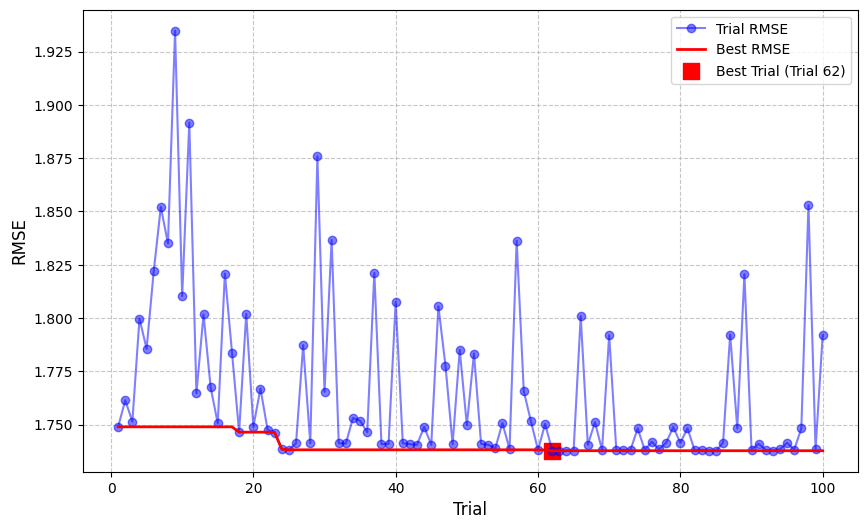

优化图已保存至: optimization_history/optuna_study_6VOD_LAI_PFTs_Hveg_history.png
处理的试验数量: 100
最佳RMSE值: 1.7378 (试验 #62)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import ast  # 用于安全地解析参数字符串

def visualize_optimization_from_csv(csv_path, overwrite_original=True):
    """Replot optimization history from CSV file and optionally overwrite original plot"""
    try:
        # Read saved optimization history data
        history_df = pd.read_csv(csv_path)
        
        # 检查状态列的值可能是什么
        print(f"CSV文件中的状态值: {history_df['state'].unique()}")
        
        # 过滤有效试验 - 尝试不同的状态值
        # Optuna 可能使用不同的状态表示
        valid_states = ['COMPLETE', 'complete', 'Complete', 'TrialState.COMPLETE']
        history_df = history_df[history_df['state'].isin(valid_states)].copy()
        
        if history_df.empty:
            print("警告: CSV中没有找到有效的试验数据")
            print("尝试使用所有行数据...")
            history_df = pd.read_csv(csv_path)  # 重新读取所有数据
            # 如果值列没有NaN，则使用所有行
            history_df = history_df[history_df['value'].notna()].copy()
            
        if history_df.empty:
            print("错误: CSV中没有有效数据")
            return False
            
        # 提取值和最佳值
        values = history_df['value'].tolist()
        best_values = [min(values[:i+1]) for i in range(len(values))]
        
        # 绘制优化过程
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(values)+1), values, 'o-', color='blue', alpha=0.5, label='Trial RMSE')
        plt.plot(range(1, len(values)+1), best_values, 'r-', linewidth=2, label='Best RMSE')
        
        # 标记全局最佳值
        best_value = min(values)
        best_index = values.index(best_value) + 1
        plt.scatter(best_index, best_value, marker='s', s=120, color='red', 
                    label=f'Best Trial (Trial {best_index})')
        
        # 设置图表元素
        plt.xlabel('Trial', fontsize=12)
        plt.ylabel('RMSE', fontsize=12)
        plt.title('', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        
        # 确定输出路径
        if overwrite_original:
            # 覆盖原始绘图文件
            plt_path = csv_path.replace('.csv', '.png')
        else:
            # 创建带时间戳的新文件
            timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
            plt_path = csv_path.replace('.csv', f'_{timestamp}.png')
        
        # 确保目录存在
        os.makedirs(os.path.dirname(plt_path), exist_ok=True)
        
        # 保存和显示
        plt.savefig(plt_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"优化图已保存至: {plt_path}")
        
        # 打印一些统计信息
        print(f"处理的试验数量: {len(values)}")
        print(f"最佳RMSE值: {best_value:.4f} (试验 #{best_index})")
        
        return True
        
    except Exception as e:
        print(f"可视化失败: {str(e)}")
        import traceback
        traceback.print_exc()
        return False

# 使用示例
if __name__ == "__main__":
    # 指定CSV文件路径
    csv_path = "optimization_history/optuna_study_6VOD_LAI_PFTs_Hveg_history.csv"
    
    # 检查文件是否存在
    if os.path.exists(csv_path):
        # 调用函数并覆盖原始图像
        visualize_optimization_from_csv(csv_path, overwrite_original=True)
    else:
        print(f"错误: 未找到文件 {csv_path}")
        print("请确保您已经运行过模型训练并生成了优化历史文件")

# 4.修改后的代码：修改了训练数据集，根据像元内构建样本质量的权重。
（相比于原先的数据集只是删除了完全没有有效植被类型LFMC值的数据，大概每个样本缩小了7000左右，主要关注validCoverage这一列进行精细处理）——后续实际证明精度也没有提升

In [1]:
import pandas as pd
import numpy as np
import time
import random
import os
import joblib
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import optuna
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 设置随机种子保证可重复性
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

def load_and_preprocess_data(file_path, sheet_name, vod_columns):
    """通用数据加载和预处理函数"""
    print("开始数据加载和预处理...")
    start_time = time.time()
    
    # 定义固定要提取的列
    base_columns = [
        'VWC', 'SM_Asc', 'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne',
        'LAI', 'SamplingDate', 'validCoverage'
    ]
    
    # 添加VOD列
    columns_to_extract = base_columns + vod_columns
    
    # 读取数据
    df = pd.read_excel(file_path, sheet_name=sheet_name, usecols=columns_to_extract)
    df = df.dropna()
    
    # 过滤VWC>30
    original_count = len(df)
    df = df[df['VWC'] <= 30]
    filtered_count = len(df)
    print(f'移除VWC>30的样本: 原始样本数{original_count}, 过滤后样本数{filtered_count}(移除{original_count-filtered_count}个样本)')
    
    # 提取样本权重
    sample_weights = df['validCoverage'].copy()
    df.drop(['validCoverage'], axis=1, inplace=True)
    
    # 提取年份差
    df['Year_diff'] = df['SamplingDate'].dt.year.apply(lambda x: 2020 - x)
    
    # 归一化处理
    df['LAI'] = df['LAI'].clip(0, 6) / 6
    df = df.rename(columns={'SM_Asc': 'SM'})
    
    # 处理VOD列
    vod_features = []
    for i, col in enumerate(vod_columns):
        feature_name = 'VOD' if len(vod_columns) == 1 else f'VOD-{"H" if i == 0 else "V"}pol'
        df[feature_name] = df[col].clip(0, 2) / 2
        df.drop(col, axis=1, inplace=True)
        vod_features.append(feature_name)
    
    # 定义特征和目标列
    feature_columns = vod_features + [
        'LAI', 'SM',
        'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
    ]
    
    X = df[feature_columns]
    y = df['VWC']
    
    elapsed_time = (time.time() - start_time) / 60
    print(f"数据预处理完成, 耗时: {elapsed_time:.2f}分钟")
    return X, y, sample_weights

def objective(trial, X_train, y_train, sample_weights_train):
    """贝叶斯优化目标函数"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'max_depth': trial.suggest_int('max_depth', 10, 100, step=10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    model = RandomForestRegressor(**params, random_state=SEED, n_jobs=-1)
    
    # 五折交叉验证
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    rmse_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        weights_tr = sample_weights_train.iloc[train_idx]
        
        model.fit(X_tr, y_tr, sample_weight=weights_tr)
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

def plot_results(y_true, y_pred, title, filename):
    """结果可视化函数"""
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.figure(figsize=(6, 6))
    
    # 计算RMSE指标
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # 绘制散点图
    plt.scatter(
        y_true, y_pred,
        marker='x',  # 叉形标记
        color='#FF0000',  # 边缘颜色
        linewidths=0.5,  # 边缘线宽
        s=40,  # 点的大小
        alpha=0.8,
        zorder=2
    )
    
    # 添加1:1参考线
    max_val = max(max(y_true), max(y_pred))
    plt.plot([0, max_val], [0, max_val], 'k--', lw=1.5, alpha=0.7, zorder=1)
    
    # 设置坐标轴范围和标签
    plt.xlim(0, 30)
    plt.ylim(0, 30)
    plt.xlabel('Insitu VWC (kg/m2)', fontsize=12, fontname='Arial', fontweight='bold')
    plt.ylabel('RF VWC (kg/m2)', fontsize=12, fontname='Arial', fontweight='bold')
    
    # 设置标题
    plt.title(title, fontsize=16, pad=20, fontweight='bold')
    
    # 添加RMSE指标文本
    plt.text(0.05, 0.95,
             f'RMSE = {rmse:.3f} kg/m²',
             transform=plt.gca().transAxes,
             fontsize=12,
             fontweight='bold',
             verticalalignment='top')
    
    # 网格线和样式调整
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_axisbelow(True)
    plt.tight_layout()
    
    # 保存图像
    os.makedirs("figures", exist_ok=True)
    plot_path = f"figures/{filename}.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"预测图保存至: {plot_path}")
    plt.close()

def train_and_evaluate_model(config):
    """通用模型训练与评估函数"""
    band = config['band']
    polarization = config['polarization']
    file_path = config['file_path']
    sheet_name = config['sheet_name']
    vod_columns = config['vod_columns']
    title = f"{band}-Band, {polarization}"
    filename_suffix = f"{band}_{polarization.replace('+', '')}_Weighted_Type1"
    
    print(f"\n{'='*50}")
    print(f"开始训练 {band}波段 {polarization} 极化模型")
    print(f"{'='*50}\n")
    
    # 1. 数据加载与预处理
    X, y, sample_weights = load_and_preprocess_data(file_path, sheet_name, vod_columns)
    
    # 2. 数据划分 (2:1比例)
    print("\n划分训练集和测试集...")
    X_train, X_test, y_train, y_test, weights_train, _ = train_test_split(
        X, y, sample_weights,
        test_size=0.333,
        random_state=SEED,
        shuffle=True
    )
    print(f"训练集样本数: {len(X_train)}, 测试集样本数: {len(X_test)}")
    
    # 3. 贝叶斯优化调参
    print("\n开始贝叶斯优化调参...")
    study = optuna.create_study(
        study_name=f"VWC_Optimization_{filename_suffix}",
        direction='minimize',
        sampler=TPESampler(seed=SEED)
    )
    
    study.optimize(lambda trial: objective(trial, X_train, y_train, weights_train), 
                   n_trials=100, show_progress_bar=True)
    
    # 获取最佳参数
    best_params = study.best_params
    print("\n最佳参数组合:")
    for key, value in best_params.items():
        print(f"{key}: {value}")
    print(f"最佳验证RMSE: {study.best_value:.4f}")
    
    # 4. 使用最佳参数训练最终模型
    print("\n训练最终模型...")
    final_model = RandomForestRegressor(
        **best_params,
        random_state=SEED,
        n_jobs=-1
    )
    final_model.fit(X_train, y_train, sample_weight=weights_train)
    
    # 5. 测试集评估
    print("\n测试集评估...")
    y_pred = final_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    print(f"测试集 RMSE: {test_rmse:.4f}")
    print(f"测试集 R²: {test_r2:.4f}")
    
    # 6. 可视化预测结果
    plot_results(y_test, y_pred, title, f"prediction_results_{filename_suffix}")
    
    # 7. 保存模型
    os.makedirs("models", exist_ok=True)
    model_path = f"models/RFR_{filename_suffix}.pkl"
    joblib.dump(final_model, model_path)
    print(f"\n模型已保存至: {model_path}")
    
    return final_model

if __name__ == "__main__":
    # 定义9种实验配置
    experiments = [
        # Ku波段实验
        {
            'band': 'Ku',
            'polarization': 'H-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx",
            'sheet_name': "VOD_Ku_Hpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_Ku_Hpol_Asc']
        },
        {
            'band': 'Ku',
            'polarization': 'V-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx",
            'sheet_name': "VOD_Ku_Vpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_Ku_Vpol_Asc']
        },
        {
            'band': 'Ku',
            'polarization': 'H+V-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_DualPol_ML_Data.xlsx",
            'sheet_name': "VOD_Ku_HVpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_Ku_Hpol_Asc', 'VOD_Ku_Vpol_Asc']
        },
        
        # X波段实验
        {
            'band': 'X',
            'polarization': 'H-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx",
            'sheet_name': "VOD_X_Hpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_X_Hpol_Asc']
        },
        {
            'band': 'X',
            'polarization': 'V-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx",
            'sheet_name': "VOD_X_Vpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_X_Vpol_Asc']
        },
        {
            'band': 'X',
            'polarization': 'H+V-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_DualPol_ML_Data.xlsx",
            'sheet_name': "VOD_X_HVpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_X_Hpol_Asc', 'VOD_X_Vpol_Asc']
        },
        
        # C波段实验
        {
            'band': 'C',
            'polarization': 'H-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx",
            'sheet_name': "VOD_C_Hpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_C_Hpol_Asc']
        },
        {
            'band': 'C',
            'polarization': 'V-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx",
            'sheet_name': "VOD_C_Vpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_C_Vpol_Asc']
        },
        {
            'band': 'C',
            'polarization': 'H+V-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_DualPol_ML_Data.xlsx",
            'sheet_name': "VOD_C_HVpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_C_Hpol_Asc', 'VOD_C_Vpol_Asc']
        }
    ]
    
    # 依次训练所有模型
    for exp_config in experiments:
        train_and_evaluate_model(exp_config)
        print("\n" + "="*50 + "\n")


开始训练 Ku波段 H-pol 极化模型

开始数据加载和预处理...


[I 2025-07-28 20:17:57,320] A new study created in memory with name: VWC_Optimization_Ku_H-pol_Weighted_Type1


移除VWC>30的样本: 原始样本数26692, 过滤后样本数26655(移除37个样本)
数据预处理完成, 耗时: 0.49分钟

划分训练集和测试集...
训练集样本数: 17778, 测试集样本数: 8877

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-28 20:18:09,417] Trial 0 finished with value: 1.3439295877181399 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.3439295877181399.
[I 2025-07-28 20:18:24,891] Trial 1 finished with value: 1.441794706623676 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.3439295877181399.
[I 2025-07-28 20:18:33,405] Trial 2 finished with value: 1.4093925383233599 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.3439295877181399.
[I 2025-07-28 20:18:43,052] Trial 3 finished with value: 1.4324162386046484 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sam

[I 2025-07-28 20:38:12,969] A new study created in memory with name: VWC_Optimization_Ku_V-pol_Weighted_Type1


移除VWC>30的样本: 原始样本数18884, 过滤后样本数18846(移除38个样本)
数据预处理完成, 耗时: 0.37分钟

划分训练集和测试集...
训练集样本数: 12570, 测试集样本数: 6276

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-28 20:38:17,042] Trial 0 finished with value: 1.5359950171172945 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.5359950171172945.
[I 2025-07-28 20:38:22,302] Trial 1 finished with value: 1.6421252586062685 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.5359950171172945.
[I 2025-07-28 20:38:25,351] Trial 2 finished with value: 1.5986914049301437 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.5359950171172945.
[I 2025-07-28 20:38:28,738] Trial 3 finished with value: 1.6442255011364075 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sa

[I 2025-07-28 20:49:10,436] A new study created in memory with name: VWC_Optimization_Ku_H_V-pol_Weighted_Type1


移除VWC>30的样本: 原始样本数18743, 过滤后样本数18709(移除34个样本)
数据预处理完成, 耗时: 0.32分钟

划分训练集和测试集...
训练集样本数: 12478, 测试集样本数: 6231

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-28 20:49:14,860] Trial 0 finished with value: 1.5170312181990133 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.5170312181990133.
[I 2025-07-28 20:49:20,640] Trial 1 finished with value: 1.6285187166249497 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.5170312181990133.
[I 2025-07-28 20:49:23,988] Trial 2 finished with value: 1.5964582239553107 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.5170312181990133.
[I 2025-07-28 20:49:27,693] Trial 3 finished with value: 1.6310008982839903 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sa

[I 2025-07-28 21:14:22,560] A new study created in memory with name: VWC_Optimization_X_H-pol_Weighted_Type1


移除VWC>30的样本: 原始样本数27187, 过滤后样本数27139(移除48个样本)
数据预处理完成, 耗时: 0.69分钟

划分训练集和测试集...
训练集样本数: 18101, 测试集样本数: 9038

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-28 21:14:34,689] Trial 0 finished with value: 1.340740341833741 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.340740341833741.
[I 2025-07-28 21:14:51,074] Trial 1 finished with value: 1.4579766399465819 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.340740341833741.
[I 2025-07-28 21:15:00,303] Trial 2 finished with value: 1.4127246037255268 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.340740341833741.
[I 2025-07-28 21:15:10,259] Trial 3 finished with value: 1.4644316462348808 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sample

[I 2025-07-28 21:37:46,557] A new study created in memory with name: VWC_Optimization_X_V-pol_Weighted_Type1


移除VWC>30的样本: 原始样本数23909, 过滤后样本数23862(移除47个样本)
数据预处理完成, 耗时: 0.43分钟

划分训练集和测试集...
训练集样本数: 15915, 测试集样本数: 7947

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-28 21:37:54,293] Trial 0 finished with value: 1.4162967450540003 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.4162967450540003.
[I 2025-07-28 21:38:04,246] Trial 1 finished with value: 1.5380084793400903 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.4162967450540003.
[I 2025-07-28 21:38:09,713] Trial 2 finished with value: 1.482668408189329 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.4162967450540003.
[I 2025-07-28 21:38:15,556] Trial 3 finished with value: 1.5491141157369819 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sam

[I 2025-07-28 22:00:31,382] A new study created in memory with name: VWC_Optimization_X_H_V-pol_Weighted_Type1


移除VWC>30的样本: 原始样本数23909, 过滤后样本数23862(移除47个样本)
数据预处理完成, 耗时: 0.38分钟

划分训练集和测试集...
训练集样本数: 15915, 测试集样本数: 7947

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-28 22:00:40,305] Trial 0 finished with value: 1.4575414435873173 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.4575414435873173.
[I 2025-07-28 22:00:51,590] Trial 1 finished with value: 1.5862472507931247 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.4575414435873173.
[I 2025-07-28 22:00:57,811] Trial 2 finished with value: 1.5324777391774935 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.4575414435873173.
[I 2025-07-28 22:01:04,346] Trial 3 finished with value: 1.59787066070549 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_samp

[I 2025-07-28 22:20:12,117] A new study created in memory with name: VWC_Optimization_C_H-pol_Weighted_Type1


移除VWC>30的样本: 原始样本数27114, 过滤后样本数27067(移除47个样本)
数据预处理完成, 耗时: 0.45分钟

划分训练集和测试集...
训练集样本数: 18053, 测试集样本数: 9014

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-28 22:20:20,629] Trial 0 finished with value: 1.354122751152687 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.354122751152687.
[I 2025-07-28 22:20:31,949] Trial 1 finished with value: 1.469751602979062 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.354122751152687.
[I 2025-07-28 22:20:38,327] Trial 2 finished with value: 1.422865183563069 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.354122751152687.
[I 2025-07-28 22:20:44,998] Trial 3 finished with value: 1.4675736168989384 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_samples_

[I 2025-07-28 22:45:28,965] A new study created in memory with name: VWC_Optimization_C_V-pol_Weighted_Type1


移除VWC>30的样本: 原始样本数22223, 过滤后样本数22183(移除40个样本)
数据预处理完成, 耗时: 0.42分钟

划分训练集和测试集...
训练集样本数: 14796, 测试集样本数: 7387

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-28 22:45:36,113] Trial 0 finished with value: 1.4073984517486178 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.4073984517486178.
[I 2025-07-28 22:45:45,565] Trial 1 finished with value: 1.5201511543953212 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.4073984517486178.
[I 2025-07-28 22:45:50,812] Trial 2 finished with value: 1.4738532431382747 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.4073984517486178.
[I 2025-07-28 22:45:56,502] Trial 3 finished with value: 1.517099542787069 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sam

[I 2025-07-28 23:05:49,090] A new study created in memory with name: VWC_Optimization_C_H_V-pol_Weighted_Type1


移除VWC>30的样本: 原始样本数22211, 过滤后样本数22171(移除40个样本)
数据预处理完成, 耗时: 0.36分钟

划分训练集和测试集...
训练集样本数: 14788, 测试集样本数: 7383

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-28 23:05:56,958] Trial 0 finished with value: 1.4641559708389493 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.4641559708389493.
[I 2025-07-28 23:06:07,269] Trial 1 finished with value: 1.5669371864027706 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.4641559708389493.
[I 2025-07-28 23:06:12,995] Trial 2 finished with value: 1.5303786963854666 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 1.4641559708389493.
[I 2025-07-28 23:06:19,052] Trial 3 finished with value: 1.5644390759800362 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sa

# 5.新操作，根据PFT和ValidCoverage删去值，训练的模型后缀为purify（模仿Forkel，直接去掉这些值）
——数据量太少，精度更低了

In [3]:
import pandas as pd
import numpy as np
import time
import random
import os
import joblib
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import optuna
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 设置随机种子保证可重复性
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

def load_and_preprocess_data(file_path, sheet_name, vod_columns):
    """通用数据加载和预处理函数"""
    print("开始数据加载和预处理...")
    start_time = time.time()
    
    # 定义固定要提取的列
    base_columns = [
        'VWC', 'SM_Asc', 'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne',
        'LAI', 'SamplingDate', 'validCoverage'
    ]
    
    # 添加VOD列
    columns_to_extract = base_columns + vod_columns
    
    # 读取数据
    df = pd.read_excel(file_path, sheet_name=sheet_name, usecols=columns_to_extract)
    df = df.dropna()
    
    # 1. 过滤VWC>30
    original_count = len(df)
    df = df[df['VWC'] <= 30]
    filtered_count = len(df)
    print(f'移除VWC>30的样本: 原始样本数{original_count}, 过滤后样本数{filtered_count}(移除{original_count-filtered_count}个样本)')
    
    # 2. 新增：检查植被覆盖总和与validCoverage是否一致
    cover_cols = ['Grass_man', 'Grass_nat', 'Shrub_bd', 'Shrub_be', 
                  'Shrub_nd', 'Shrub_ne', 'Tree_bd', 'Tree_be', 
                  'Tree_nd', 'Tree_ne']
    
    # 计算植被覆盖总和
    df['cover_sum'] = df[cover_cols].sum(axis=1)
    
    # 筛选覆盖总和等于validCoverage的样本（允许1e-5的浮点误差）
    initial_count = len(df)
    df = df[np.isclose(df['cover_sum'], df['validCoverage'], atol=1e-5)]
    final_count = len(df)
    print(f'筛去植被覆盖不一致的样本: 筛选前{initial_count}, 筛选后{final_count}(移除{initial_count-final_count}个样本)')
    
    # 提取年份差
    df['Year_diff'] = df['SamplingDate'].dt.year.apply(lambda x: 2020 - x)
    
    # 归一化处理
    df['LAI'] = df['LAI'].clip(0, 6) / 6
    df = df.rename(columns={'SM_Asc': 'SM'})
    
    # 处理VOD列
    vod_features = []
    for i, col in enumerate(vod_columns):
        feature_name = 'VOD' if len(vod_columns) == 1 else f'VOD{"H" if i == 0 else "V"}pol'  # 修改：移除连接符
        df[feature_name] = df[col].clip(0, 2) / 2
        df.drop(col, axis=1, inplace=True)
        vod_features.append(feature_name)
    
    # 定义特征和目标列
    feature_columns = vod_features + [
        'LAI', 'SM',
        'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
    ]
    
    X = df[feature_columns]
    y = df['VWC']
    
    elapsed_time = (time.time() - start_time) / 60
    print(f"数据预处理完成, 耗时: {elapsed_time:.2f}分钟")
    return X, y

def objective(trial, X_train, y_train):
    """贝叶斯优化目标函数"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'max_depth': trial.suggest_int('max_depth', 10, 100, step=10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    model = RandomForestRegressor(**params, random_state=SEED, n_jobs=-1)
    
    # 五折交叉验证
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    rmse_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(X_tr, y_tr)  # 修改：移除样本权重
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

def plot_results(y_true, y_pred, title, filename):
    """结果可视化函数"""
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.figure(figsize=(6, 6))
    
    # 计算RMSE指标
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # 绘制散点图
    plt.scatter(
        y_true, y_pred,
        marker='x',  # 叉形标记
        color='#FF0000',  # 边缘颜色
        linewidths=0.5,  # 边缘线宽
        s=40,  # 点的大小
        alpha=0.8,
        zorder=2
    )
    
    # 添加1:1参考线
    max_val = max(max(y_true), max(y_pred))
    plt.plot([0, max_val], [0, max_val], 'k--', lw=1.5, alpha=0.7, zorder=1)
    
    # 设置坐标轴范围和标签
    plt.xlim(0, 30)
    plt.ylim(0, 30)
    plt.xlabel('Insitu VWC (kg/m2)', fontsize=12, fontname='Arial', fontweight='bold')
    plt.ylabel('RF VWC (kg/m2)', fontsize=12, fontname='Arial', fontweight='bold')
    
    # 设置标题
    plt.title(title, fontsize=16, pad=20, fontweight='bold')
    
    # 添加RMSE指标文本
    plt.text(0.05, 0.95,
             f'RMSE = {rmse:.3f} kg/m²',
             transform=plt.gca().transAxes,
             fontsize=12,
             fontweight='bold',
             verticalalignment='top')
    
    # 网格线和样式调整
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_axisbelow(True)
    plt.tight_layout()
    
    # 保存图像
    os.makedirs("figures", exist_ok=True)
    plot_path = f"figures/{filename}.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"预测图保存至: {plot_path}")
    plt.close()

def train_and_evaluate_model(config):
    """通用模型训练与评估函数"""
    band = config['band']
    polarization = config['polarization']
    P = config['polarization'].replace('-', '')  # 修改：移除极化名称中的连接符
    file_path = config['file_path']
    sheet_name = config['sheet_name']
    vod_columns = config['vod_columns']
    title = f"{band}-Band, {polarization}"
    filename_suffix = f"{band}_{P.replace('+', '')}_Purify_Type1"  # 修改：移除连接符
    
    print(f"\n{'='*50}")
    print(f"开始训练 {band}波段 {polarization} 极化模型")
    print(f"{'='*50}\n")
    
    # 1. 数据加载与预处理
    X, y = load_and_preprocess_data(file_path, sheet_name, vod_columns)
    
    # 2. 数据划分 (2:1比例)
    print("\n划分训练集和测试集...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.333,
        random_state=SEED,
        shuffle=True
    )
    print(f"训练集样本数: {len(X_train)}, 测试集样本数: {len(X_test)}")
    
    # 3. 贝叶斯优化调参
    print("\n开始贝叶斯优化调参...")
    study = optuna.create_study(
        study_name=f"VWC_Optimization_{filename_suffix}",
        direction='minimize',
        sampler=TPESampler(seed=SEED)
    )
    
    study.optimize(lambda trial: objective(trial, X_train, y_train), 
                   n_trials=100, show_progress_bar=True)
    
    # 获取最佳参数
    best_params = study.best_params
    print("\n最佳参数组合:")
    for key, value in best_params.items():
        print(f"{key}: {value}")
    print(f"最佳验证RMSE: {study.best_value:.4f}")
    
    # 4. 使用最佳参数训练最终模型
    print("\n训练最终模型...")
    final_model = RandomForestRegressor(
        **best_params,
        random_state=SEED,
        n_jobs=-1
    )
    final_model.fit(X_train, y_train)  # 修改：移除样本权重
    
    # 5. 测试集评估
    print("\n测试集评估...")
    y_pred = final_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    print(f"测试集 RMSE: {test_rmse:.4f}")
    print(f"测试集 R²: {test_r2:.4f}")
    
    # 6. 可视化预测结果
    plot_results(y_test, y_pred, title, f"prediction_results_{filename_suffix}")
    
    # 7. 保存模型
    os.makedirs("models", exist_ok=True)
    model_path = f"models/RFR_{filename_suffix}.pkl"
    joblib.dump(final_model, model_path)
    print(f"\n模型已保存至: {model_path}")
    
    return final_model

if __name__ == "__main__":
    # 定义9种实验配置
    experiments = [
        # Ku波段实验
        {
            'band': 'Ku',
            'polarization': 'H-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx",
            'sheet_name': "VOD_Ku_Hpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_Ku_Hpol_Asc']
        },
        {
            'band': 'Ku',
            'polarization': 'V-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx",
            'sheet_name': "VOD_Ku_Vpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_Ku_Vpol_Asc']
        },
        {
            'band': 'Ku',
            'polarization': 'H+V-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_DualPol_ML_Data.xlsx",
            'sheet_name': "VOD_Ku_HVpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_Ku_Hpol_Asc', 'VOD_Ku_Vpol_Asc']
        },
        
        # X波段实验
        {
            'band': 'X',
            'polarization': 'H-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx",
            'sheet_name': "VOD_X_Hpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_X_Hpol_Asc']
        },
        {
            'band': 'X',
            'polarization': 'V-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx",
            'sheet_name': "VOD_X_Vpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_X_Vpol_Asc']
        },
        {
            'band': 'X',
            'polarization': 'H+V-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_DualPol_ML_Data.xlsx",
            'sheet_name': "VOD_X_HVpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_X_Hpol_Asc', 'VOD_X_Vpol_Asc']
        },
        
        # C波段实验
        {
            'band': 'C',
            'polarization': 'H-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx",
            'sheet_name': "VOD_C_Hpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_C_Hpol_Asc']
        },
        {
            'band': 'C',
            'polarization': 'V-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx",
            'sheet_name': "VOD_C_Vpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_C_Vpol_Asc']
        },
        {
            'band': 'C',
            'polarization': 'H+V-pol',
            'file_path': r"E:\Matlab\EX2025\AuxiliaryData\VWC_DualPol_ML_Data.xlsx",
            'sheet_name': "VOD_C_HVpol_Asc_Cleaned_Type1",
            'vod_columns': ['VOD_C_Hpol_Asc', 'VOD_C_Vpol_Asc']
        }
    ]
    
    # 依次训练所有模型
    for exp_config in experiments:
        train_and_evaluate_model(exp_config)
        print("\n" + "="*50 + "\n")


开始训练 Ku波段 H-pol 极化模型

开始数据加载和预处理...


[I 2025-07-31 17:33:50,694] A new study created in memory with name: VWC_Optimization_Ku_Hpol_Purify_Type1


移除VWC>30的样本: 原始样本数26692, 过滤后样本数26655(移除37个样本)
筛去植被覆盖不一致的样本: 筛选前26655, 筛选后849(移除25806个样本)
数据预处理完成, 耗时: 0.43分钟

划分训练集和测试集...
训练集样本数: 566, 测试集样本数: 283

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-31 17:33:53,467] Trial 0 finished with value: 2.203397325469606 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 2.203397325469606.
[I 2025-07-31 17:33:57,160] Trial 1 finished with value: 2.23901501416141 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 2.203397325469606.
[I 2025-07-31 17:33:59,265] Trial 2 finished with value: 2.2203939879979844 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 2.203397325469606.
[I 2025-07-31 17:34:03,341] Trial 3 finished with value: 2.2676039175955975 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_samples_

[I 2025-07-31 17:42:32,984] A new study created in memory with name: VWC_Optimization_Ku_Vpol_Purify_Type1


移除VWC>30的样本: 原始样本数18884, 过滤后样本数18846(移除38个样本)
筛去植被覆盖不一致的样本: 筛选前18846, 筛选后675(移除18171个样本)
数据预处理完成, 耗时: 0.52分钟

划分训练集和测试集...
训练集样本数: 450, 测试集样本数: 225

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-31 17:42:35,563] Trial 0 finished with value: 2.3811571379549052 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 2.3811571379549052.
[I 2025-07-31 17:42:39,139] Trial 1 finished with value: 2.4090306847222274 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 2.3811571379549052.
[I 2025-07-31 17:42:41,162] Trial 2 finished with value: 2.3963835687352337 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 2.3811571379549052.
[I 2025-07-31 17:42:45,047] Trial 3 finished with value: 2.4241556192480993 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sa

[I 2025-07-31 17:49:23,947] A new study created in memory with name: VWC_Optimization_Ku_HVpol_Purify_Type1


移除VWC>30的样本: 原始样本数18743, 过滤后样本数18709(移除34个样本)
筛去植被覆盖不一致的样本: 筛选前18709, 筛选后667(移除18042个样本)
数据预处理完成, 耗时: 0.43分钟

划分训练集和测试集...
训练集样本数: 444, 测试集样本数: 223

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-31 17:49:26,523] Trial 0 finished with value: 2.4154246985108747 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 2.4154246985108747.
[I 2025-07-31 17:49:30,119] Trial 1 finished with value: 2.454570664952679 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 2.4154246985108747.
[I 2025-07-31 17:49:32,126] Trial 2 finished with value: 2.444936466206152 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 2.4154246985108747.
[I 2025-07-31 17:49:36,032] Trial 3 finished with value: 2.524687973840357 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sampl

[I 2025-07-31 17:56:32,652] A new study created in memory with name: VWC_Optimization_X_Hpol_Purify_Type1


移除VWC>30的样本: 原始样本数27187, 过滤后样本数27139(移除48个样本)
筛去植被覆盖不一致的样本: 筛选前27139, 筛选后883(移除26256个样本)
数据预处理完成, 耗时: 0.60分钟

划分训练集和测试集...
训练集样本数: 588, 测试集样本数: 295

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-31 17:56:35,354] Trial 0 finished with value: 2.161595677993403 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 2.161595677993403.
[I 2025-07-31 17:56:39,051] Trial 1 finished with value: 2.1482631773269825 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 1 with value: 2.1482631773269825.
[I 2025-07-31 17:56:41,120] Trial 2 finished with value: 2.1506122384394266 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 1 with value: 2.1482631773269825.
[I 2025-07-31 17:56:45,025] Trial 3 finished with value: 2.1352648930973226 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_samp

[I 2025-07-31 18:05:02,793] A new study created in memory with name: VWC_Optimization_X_Vpol_Purify_Type1


移除VWC>30的样本: 原始样本数23909, 过滤后样本数23862(移除47个样本)
筛去植被覆盖不一致的样本: 筛选前23862, 筛选后798(移除23064个样本)
数据预处理完成, 耗时: 0.58分钟

划分训练集和测试集...
训练集样本数: 532, 测试集样本数: 266

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-31 18:05:05,481] Trial 0 finished with value: 2.06937540823672 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 2.06937540823672.
[I 2025-07-31 18:05:09,055] Trial 1 finished with value: 2.1024366608640173 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 2.06937540823672.
[I 2025-07-31 18:05:11,089] Trial 2 finished with value: 2.0848163826907893 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 2.06937540823672.
[I 2025-07-31 18:05:15,007] Trial 3 finished with value: 2.141221285786152 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_samples_lea

[I 2025-07-31 18:11:50,018] A new study created in memory with name: VWC_Optimization_X_HVpol_Purify_Type1


移除VWC>30的样本: 原始样本数23909, 过滤后样本数23862(移除47个样本)
筛去植被覆盖不一致的样本: 筛选前23862, 筛选后798(移除23064个样本)
数据预处理完成, 耗时: 0.49分钟

划分训练集和测试集...
训练集样本数: 532, 测试集样本数: 266

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-31 18:11:52,783] Trial 0 finished with value: 2.051595731400836 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 2.051595731400836.
[I 2025-07-31 18:11:56,510] Trial 1 finished with value: 2.10512872532547 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 2.051595731400836.
[I 2025-07-31 18:11:59,416] Trial 2 finished with value: 2.078416268476969 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 2.051595731400836.
[I 2025-07-31 18:12:04,143] Trial 3 finished with value: 2.1684480727830904 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_samples_l

[I 2025-07-31 18:16:38,743] A new study created in memory with name: VWC_Optimization_C_Hpol_Purify_Type1


移除VWC>30的样本: 原始样本数27114, 过滤后样本数27067(移除47个样本)
筛去植被覆盖不一致的样本: 筛选前27067, 筛选后878(移除26189个样本)
数据预处理完成, 耗时: 0.60分钟

划分训练集和测试集...
训练集样本数: 585, 测试集样本数: 293

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-31 18:16:41,296] Trial 0 finished with value: 2.2186289961284777 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 2.2186289961284777.
[I 2025-07-31 18:16:44,863] Trial 1 finished with value: 2.2189188745366555 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 2.2186289961284777.
[I 2025-07-31 18:16:46,857] Trial 2 finished with value: 2.2189499682679017 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 2.2186289961284777.
[I 2025-07-31 18:16:50,696] Trial 3 finished with value: 2.2299026722541457 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sa

[I 2025-07-31 18:21:39,295] A new study created in memory with name: VWC_Optimization_C_Vpol_Purify_Type1


移除VWC>30的样本: 原始样本数22223, 过滤后样本数22183(移除40个样本)
筛去植被覆盖不一致的样本: 筛选前22183, 筛选后736(移除21447个样本)
数据预处理完成, 耗时: 0.59分钟

划分训练集和测试集...
训练集样本数: 490, 测试集样本数: 246

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-31 18:21:42,088] Trial 0 finished with value: 2.2086158424732054 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 2.2086158424732054.
[I 2025-07-31 18:21:45,943] Trial 1 finished with value: 2.2127087698664907 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 2.2086158424732054.
[I 2025-07-31 18:21:48,120] Trial 2 finished with value: 2.2186228184728565 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 2.2086158424732054.
[I 2025-07-31 18:21:52,357] Trial 3 finished with value: 2.222136185556208 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_sam

[I 2025-07-31 18:31:13,119] A new study created in memory with name: VWC_Optimization_C_HVpol_Purify_Type1


移除VWC>30的样本: 原始样本数22211, 过滤后样本数22171(移除40个样本)
筛去植被覆盖不一致的样本: 筛选前22171, 筛选后732(移除21439个样本)
数据预处理完成, 耗时: 0.46分钟

划分训练集和测试集...
训练集样本数: 488, 测试集样本数: 244

开始贝叶斯优化调参...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-31 18:31:15,734] Trial 0 finished with value: 2.3449436354344995 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 2.3449436354344995.
[I 2025-07-31 18:31:19,377] Trial 1 finished with value: 2.3561294974872746 and parameters: {'n_estimators': 650, 'max_features': 'sqrt', 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 2.3449436354344995.
[I 2025-07-31 18:31:21,404] Trial 2 finished with value: 2.358646499742001 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 2.3449436354344995.
[I 2025-07-31 18:31:25,332] Trial 3 finished with value: 2.367325580463132 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 7, 'min_samp

# 6.尝试：多信息协同建模

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import os
import joblib
import warnings

# 忽略警告
warnings.filterwarnings('ignore')

# 0. 创建保存目录
SAVE_DIR = 'models/DNN'
os.makedirs(SAVE_DIR, exist_ok=True)

# 1. 自定义RMSE损失函数
def root_mean_squared_error(y_true, y_pred):
    """自定义RMSE损失函数"""
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    rmse = tf.sqrt(mse)
    return rmse

# 2. 数据准备
file_path = r'E:\Matlab\EX2025\AuxiliaryData\LFMC-gridMean-ML.xlsx'
cols_to_read = ['AGB', 'SM_Asc','Grass_man', 'Grass_nat','Shrub_bd', 'Shrub_be', 
               'Shrub_nd', 'Shrub_ne','Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne',
               'LAI', 'LFMCValue', 'VOD_Ku_Hpol_Asc', 'VOD_Ku_Vpol_Asc',
               'VOD_X_Hpol_Asc','VOD_X_Vpol_Asc','VOD_C_Hpol_Asc','VOD_C_Vpol_Asc',
               'SamplingDate', 'Latitude', 'Longitude', 'Grass', 'Shrub', 'Tree', 'Hveg']

# 读取数据
print("读取数据...")
df = pd.read_excel(file_path, usecols=cols_to_read)

# 数据清洗
print("数据清洗...")
df_clean = df.dropna(subset=cols_to_read).copy()

# 计算VWC并过滤
print("计算VWC并过滤...")
df_clean.loc[:, 'VWC'] = (df_clean['AGB'] * df_clean['LFMCValue']) / 1000
df_final = df_clean.loc[df_clean['VWC'] <= 30].copy()

# 重置索引以确保一致性
df_final = df_final.reset_index(drop=True)

# 打印数据统计
print(f"原始数据行数: {len(df)}")
print(f"清洗后行数: {len(df_clean)}")
print(f"过滤后行数: {len(df_final)}")

# 3. 特征工程
print("特征工程...")
# Hveg归一化
df_final.loc[:, 'Hveg'] = df_final['Hveg'] / 60

# 计算一年中的第几天 - 确保转换为数值型
df_final.loc[:, 'DOY'] = df_final['SamplingDate'].apply(lambda x: x.timetuple().tm_yday).astype(np.float32)

# 归一化VOD和LAI
vod_cols = ['VOD_Ku_Hpol_Asc', 'VOD_Ku_Vpol_Asc', 'VOD_X_Hpol_Asc', 
            'VOD_X_Vpol_Asc', 'VOD_C_Hpol_Asc', 'VOD_C_Vpol_Asc']
for col in vod_cols:
    df_final.loc[:, col] = df_final[col] / 2
df_final.loc[:, 'LAI'] = df_final['LAI'] / 6

# 特征分组
static_features = ['Hveg', 'Grass', 'Shrub', 'Tree']  # 静态特征
dynamic_features = [
    'Grass_man', 'Grass_nat', 
    'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
    'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne',
    'LAI'
] + vod_cols  # 动态特征
spatio_temporal_features = ['Latitude', 'Longitude', 'DOY']  # 时空特征

# 4. 数据准备
print("数据准备...")
# 提取特征数据并转换为float32
static_data = df_final[static_features].values.astype(np.float32)
dynamic_data = df_final[dynamic_features].values.astype(np.float32)
spatial_data = df_final[spatio_temporal_features].values.astype(np.float32)

# 标签数据
y = df_final['VWC'].values.astype(np.float32)

# 数据一致性检查
print(f"static_data 样本数: {len(static_data)}, dtype: {static_data.dtype}")
print(f"dynamic_data 样本数: {len(dynamic_data)}, dtype: {dynamic_data.dtype}")
print(f"spatial_data 样本数: {len(spatial_data)}, dtype: {spatial_data.dtype}")
print(f"y 样本数: {len(y)}, dtype: {y.dtype}")
assert len(static_data) == len(dynamic_data) == len(spatial_data) == len(y), \
    f"数据长度不一致: static({len(static_data)}), dynamic({len(dynamic_data)}), spatial({len(spatial_data)}), y({len(y)})"

# 5. 构建深度学习模型 (融合三个分支)
def build_vwc_model_with_rmse():
    # 输入层 - 三个分支
    static_input = Input(shape=(len(static_features),), name='static_input', dtype=tf.float32)
    dynamic_input = Input(shape=(len(dynamic_features),), name='dynamic_input', dtype=tf.float32)
    spatial_input = Input(shape=(len(spatio_temporal_features),), name='spatial_input', dtype=tf.float32)
    
    # 静态分支 - 基值特征
    x_static = Dense(64, activation='relu')(static_input)
    x_static = BatchNormalization()(x_static)
    x_static = Dropout(0.2)(x_static)
    x_static = Dense(32, activation='relu', name='static_output')(x_static)
    
    # 动态分支 - 主要调整特征
    x_dynamic = Dense(128, activation='relu')(dynamic_input)
    x_dynamic = BatchNormalization()(x_dynamic)
    x_dynamic = Dropout(0.3)(x_dynamic)
    x_dynamic = Dense(64, activation='relu')(x_dynamic)
    x_dynamic = Dropout(0.2)(x_dynamic)
    x_dynamic = Dense(32, activation='relu', name='dynamic_output')(x_dynamic)
    
    # 时空分支 - 微调特征
    x_spatial = Dense(32, activation='relu')(spatial_input)
    x_spatial = BatchNormalization()(x_spatial)
    x_spatial = Dropout(0.2)(x_spatial)
    x_spatial = Dense(16, activation='relu', name='spatial_output')(x_spatial)
    
    # 特征融合层 - 拼接三个分支
    merged = Concatenate(name='feature_fusion')([x_static, x_dynamic, x_spatial])
    
    # 融合特征处理
    x = Dense(128, activation='relu')(merged)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    # 输出层
    output = Dense(1, activation='linear', name='vwc_output')(x)
    
    # 构建模型
    model = Model(
        inputs=[static_input, dynamic_input, spatial_input], 
        outputs=output
    )
    
    return model

# 6. 编译和训练模型 (使用自定义RMSE损失)
print("构建模型...")
model = build_vwc_model_with_rmse()
model.summary()

# 编译模型 - 使用自定义RMSE损失
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=root_mean_squared_error,  # 使用自定义RMSE损失
    metrics=['mae', 'mse']  # 监控MAE和MSE指标
)

# 准备输入数据
print("准备输入数据...")
# 提取各特征组数据
X_static = static_data
X_dynamic = dynamic_data
X_spatial = spatial_data

# 划分训练测试集
print("划分训练测试集...")
(
    X_static_train, X_static_test, 
    X_dynamic_train, X_dynamic_test, 
    X_spatial_train, X_spatial_test,
    y_train, y_test
) = train_test_split(
    X_static, X_dynamic, X_spatial, y, 
    test_size=0.2, random_state=42
)

# 检查样本数量一致性
assert len(X_static_train) == len(X_dynamic_train) == len(X_spatial_train) == len(y_train), \
    f"训练集样本数量不一致: static({len(X_static_train)}), dynamic({len(X_dynamic_train)}), spatial({len(X_spatial_train)}), y({len(y_train)})"
assert len(X_static_test) == len(X_dynamic_test) == len(X_spatial_test) == len(y_test), \
    f"测试集样本数量不一致: static({len(X_static_test)}), dynamic({len(X_dynamic_test)}), spatial({len(X_spatial_test)}), y({len(y_test)})"

# 回调函数
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

# 训练模型
print("开始训练模型...")
history = model.fit(
    x=[X_static_train, X_dynamic_train, X_spatial_train], 
    y=y_train,
    epochs=200,
    batch_size=128,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)
print("模型训练完成!")

# 7. 模型评估与可视化
def generate_model_report(model, history, static_test, dynamic_test, spatial_test, y_test):
    """生成模型评估报告"""
    print("\n在测试集上评估模型...")
    # 预测测试集
    y_pred = model.predict([static_test, dynamic_test, spatial_test]).flatten()
    
    # 计算评估指标
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"\n模型性能报告:")
    print(f"- RMSE: {rmse:.4f} kg/m²")
    print(f"- R²: {r2:.4f}")
    print(f"- MAE: {mae:.4f}")
    
    # 训练历史可视化
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='训练损失')
    plt.plot(history.history['val_loss'], label='验证损失')
    plt.title('RMSE损失变化')
    plt.ylabel('RMSE')
    plt.xlabel('迭代次数')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='训练MAE')
    plt.plot(history.history['val_mae'], label='验证MAE')
    plt.title('MAE变化')
    plt.ylabel('MAE')
    plt.xlabel('迭代次数')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{SAVE_DIR}/training_history_rmse.png', dpi=300)
    plt.close()
    
    # 预测结果可视化
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    max_val = max(y_test.max(), y_pred.max()) + 1
    plt.plot([0, max_val], [0, max_val], 'r--')
    plt.xlabel('真实VWC')
    plt.ylabel('预测VWC')
    plt.title('预测结果散点图')
    plt.grid(True)
    plt.savefig(f'{SAVE_DIR}/prediction_scatter.png', dpi=300)
    plt.close()
    
    # 残差分布
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, alpha=0.7)
    plt.title('残差分布')
    plt.xlabel('残差 (kg/m²)')
    plt.savefig(f'{SAVE_DIR}/residuals_distribution.png', dpi=300)
    plt.close()
    
    return y_pred

# 生成模型报告
print("生成模型报告...")
y_pred = generate_model_report(
    model, 
    history, 
    X_static_test, 
    X_dynamic_test, 
    X_spatial_test,
    y_test
)

# 8. 分支输出可视化
def visualize_branch_outputs(model, sample_data):
    """可视化分支输出分布"""
    print("\n可视化分支输出分布...")
    # 创建分支输出提取模型
    branch_output_model = Model(
        inputs=model.input,
        outputs=[
            model.get_layer('static_output').output,
            model.get_layer('dynamic_output').output,
            model.get_layer('spatial_output').output,
            model.get_layer('feature_fusion').output,
            model.output
        ]
    )
    
    # 获取各层输出
    outputs = branch_output_model.predict(sample_data)
    
    # 可视化各分支输出维度
    print("\n分支输出维度:")
    layer_names = ['静态分支', '动态分支', '时空分支', '融合层', '最终输出']
    for name, output in zip(layer_names, outputs):
        print(f"- {name}: {output.shape[1]}维")
    
    # 可视化特征分布
    plt.figure(figsize=(15, 10))
    titles = ['静态分支特征分布', '动态分支特征分布', '时空分支特征分布', '融合特征分布', '最终预测分布']
    
    for i, (title, output) in enumerate(zip(titles, outputs), 1):
        plt.subplot(2, 3, i)
        plt.hist(output.flatten(), bins=30, alpha=0.7)
        plt.title(title)
    
    plt.tight_layout()
    plt.savefig(f'{SAVE_DIR}/branch_output_distributions.png', dpi=300)
    plt.close()

# 可视化分支输出 (使用测试集样本)
print("可视化分支输出...")
sample_data = [
    X_static_test[:100],
    X_dynamic_test[:100],
    X_spatial_test[:100]
]
visualize_branch_outputs(model, sample_data)

# 9. 模型保存
print("\n保存模型和特征信息...")
model.save(f'{SAVE_DIR}/vwc_model_with_rmse.h5')

# 保存特征列表
feature_info = {
    'static_features': static_features,
    'dynamic_features': dynamic_features,
    'spatio_temporal_features': spatio_temporal_features
}
joblib.dump(feature_info, f'{SAVE_DIR}/feature_info.pkl')

print(f"所有模型和资源已保存到: {SAVE_DIR}")

读取数据...
数据清洗...
计算VWC并过滤...
原始数据行数: 92082
清洗后行数: 16099
过滤后行数: 16013
特征工程...
数据准备...
static_data 样本数: 16013, dtype: float32
dynamic_data 样本数: 16013, dtype: float32
spatial_data 样本数: 16013, dtype: float32
y 样本数: 16013, dtype: float32
构建模型...


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)               ┃ Output Shape           ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ dynamic_input (InputLayer) │ (None, 17)             │              0 │ -                       │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ dense_7 (Dense)            │ (None, 128)            │          2,304 │ dynamic_input[0][0]     │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ static_input (InputLayer)  │ (None, 4)              │              0 │ -                       │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ batch_normalization_5      │ (None, 128)            │            512 │ dense_7[0][0]           │
│ (BatchNormalization)       │                        │                │                         │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ spatial_input (InputLayer) │ (None, 3)              │              0 │ -                       │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ dense_6 (Dense)            │ (None, 64)             │            320 │ static_input[0][0]      │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ dropout_7 (Dropout)        │ (None, 128)            │              0 │ batch_normalization_5[… │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ dense_9 (Dense)            │ (None, 32)             │            128 │ spatial_input[0][0]     │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ batch_normalization_4      │ (None, 64)             │            256 │ dense_6[0][0]           │
│ (BatchNormalization)       │                        │                │                         │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ dense_8 (Dense)            │ (None, 64)             │          8,256 │ dropout_7[0][0]         │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ batch_normalization_6      │ (None, 32)             │            128 │ dense_9[0][0]           │
│ (BatchNormalization)       │                        │                │                         │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ dropout_6 (Dropout)        │ (None, 64)             │              0 │ batch_normalization_4[… │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ dropout_8 (Dropout)        │ (None, 64)             │              0 │ dense_8[0][0]           │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ dropout_9 (Dropout)        │ (None, 32)             │              0 │ batch_normalization_6[… │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ static_output (Dense)      │ (None, 32)             │          2,080 │ dropout_6[0][0]         │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ dynamic_output (Dense)     │ (None, 32)             │          2,080 │ dropout_8[0][0]         │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ spatial_output (Dense)     │ (None, 16)             │            528 │ dropout_9[0][0]         │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ feature_fusion             │ (None, 80

 Total params: 35,793 (139.82 KB)

 Trainable params: 35,089 (137.07 KB)

 Non-trainable params: 704 (2.75 KB)

准备输入数据...
划分训练测试集...
开始训练模型...
Epoch 1/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 4.0875 - mae: 2.8174 - mse: 18.4828 - val_loss: 5.5573 - val_mae: 3.3992 - val_mse: 31.4499 - learning_rate: 0.0010
Epoch 2/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7957 - mae: 1.7661 - mse: 7.9082 - val_loss: 5.1368 - val_mae: 3.2086 - val_mse: 26.9305 - learning_rate: 0.0010
Epoch 3/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6240 - mae: 1.6755 - mse: 6.9920 - val_loss: 4.8357 - val_mae: 3.0932 - val_mse: 23.8910 - learning_rate: 0.0010
Epoch 4/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6222 - mae: 1.6798 - mse: 7.0465 - val_loss: 4.1588 - val_mae: 2.6776 - val_mse: 17.7367 - learning_rate: 0.0010
Epoch 5/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4917 - mae: 1.6057 - mse: 6.3101 - val_loss: 3.6807 - val_mae: 2.2856 - val_mse: 13.9149 - learning_rate: 0.0010
Epoch 6/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5959 - mae: 1.6307 - mse: 6.9936 - va


保存模型和特征信息...
所有模型和资源已保存到: models/DNN


In [ ]:
# 模型的检验试用

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
import joblib
import os
import warnings
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Suppress warnings
warnings.filterwarnings('ignore')

# Constants
SAVE_DIR = 'models/DNN'  # Model save directory
TEST_DATA_PATH = r'E:\data\VWC\test-VWC\SMEX02_CLASIC07_SMEX08_SMAPVEX16\InsituData_Pixel_ML.xlsx'
SHEET_NAMES = ['SMEX02', 'CLASIC07', 'SMAPVEX08', 'SMAPVEX16']
VWC_COLUMNS = {
    'SMEX02': 'VWC-Field',
    'CLASIC07': 'VWC (kg/m²)',
    'SMAPVEX08': 'VWC',
    'SMAPVEX16': 'PLANT_WATER_CONTENT_AREA'
}

# Column mapping from test data to training data
COLUMN_MAPPING = {
    # Training column name: Test column name
    'LAI': 'LAI_Satellite',  # 卫星反演的LAI
    'VOD_Ku_Hpol_Asc': 'ku_vod_H',
    'VOD_Ku_Vpol_Asc': 'ku_vod_V',
    'VOD_X_Hpol_Asc': 'x_vod_H',
    'VOD_X_Vpol_Asc': 'x_vod_V',
    'VOD_C_Hpol_Asc': 'c_vod_H',
    'VOD_C_Vpol_Asc': 'c_vod_V',
    'SamplingDate': 'Date',
    'Latitude': 'Latitude',
    'Longitude': 'Longitude',
    'Hveg': 'Hveg_Satellite'
}

# Marker styles for each dataset
MARKER_STYLES = {
    'SMEX02': {'marker': '*', 'color': '#F8766D'},
    'CLASIC07': {'marker': '^', 'facecolor': 'none', 'edgecolor': '#00BFC4'},
    'SMAPVEX08': {'marker': '+', 'color': '#C77CFF'},
    'SMAPVEX16': {'marker': 'o', 'facecolor': 'none', 'edgecolor': '#7CAE00'}
}

# Set global font
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

def root_mean_squared_error(y_true, y_pred):
    """Custom RMSE loss function"""
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    rmse = tf.sqrt(mse)
    return rmse

def load_model():
    """Load model"""
    print("Loading model...")
    
    # Load model
    model_path = os.path.join(SAVE_DIR, 'vwc_model_with_rmse.h5')
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")
    
    model = tf.keras.models.load_model(model_path, custom_objects={
        'root_mean_squared_error': root_mean_squared_error
    })
    
    # Print model summary for debugging
    print("\nModel summary:")
    model.summary()
    
    # Load feature info
    feature_info_path = os.path.join(SAVE_DIR, 'feature_info.pkl')
    if not os.path.exists(feature_info_path):
        raise FileNotFoundError(f"Feature info file not found: {feature_info_path}")
    
    feature_info = joblib.load(feature_info_path)
    
    print("Model loaded successfully!")
    return model, feature_info

def map_test_columns(df):
    """Map test data column names to training data column names"""
    # Create reverse mapping: test column name -> training column name
    reverse_mapping = {v: k for k, v in COLUMN_MAPPING.items()}
    
    # Rename columns
    df_renamed = df.rename(columns=reverse_mapping)
    
    return df_renamed

def convert_date_to_doy(df):
    """Convert date column to Day of Year (DOY)"""
    if 'SamplingDate' not in df.columns:
        print("Warning: 'SamplingDate' column not found, skipping DOY conversion")
        return df
    
    # Print original date values for debugging
    print(f"  Original date values (first 5): {df['SamplingDate'].head(5).tolist()}")
    
    # Convert date to datetime and calculate DOY
    def convert_to_datetime(date_val):
        try:
            # If it's already a datetime object
            if isinstance(date_val, datetime):
                return date_val
            
            # If it's a string
            if isinstance(date_val, str):
                # Try different date formats
                try:
                    return datetime.strptime(date_val, '%Y%m%d')
                except ValueError:
                    try:
                        return datetime.strptime(date_val, '%Y-%m-%d')
                    except ValueError:
                        try:
                            return datetime.strptime(date_val, '%m/%d/%Y')
                        except ValueError:
                            return None
            
            # If it's an integer (YYYYMMDD format)
            if isinstance(date_val, (int, float)):
                date_str = str(int(date_val))
                if len(date_str) == 8:
                    try:
                        return datetime.strptime(date_str, '%Y%m%d')
                    except ValueError:
                        return None
                else:
                    return None
        except Exception as e:
            print(f"    Error converting date value {date_val}: {str(e)}")
            return None
    
    # Convert dates
    df['DOY'] = df['SamplingDate'].apply(
        lambda x: convert_to_datetime(x).timetuple().tm_yday if convert_to_datetime(x) else None
    )
    
    # Print conversion results
    print(f"  Converted DOY values (first 5): {df['DOY'].head(5).tolist()}")
    
    # Count invalid dates
    invalid_count = df['DOY'].isna().sum()
    if invalid_count > 0:
        print(f"  Warning: {invalid_count} dates could not be converted to DOY")
    
    # Drop rows with invalid DOY
    df = df.dropna(subset=['DOY'])
    
    # Print final DOY values
    print(f"  Final DOY values (first 5): {df['DOY'].head(5).tolist()}")
    
    return df

def preprocess_test_data(df, sheet_name, feature_info):
    print(f"\nPreprocessing {sheet_name} data...")
    
    # 1. Map column names
    df = map_test_columns(df)
    
    # 2. 处理复合列（特别是LAI列）
    # 处理LAI_Satellite列
    if 'LAI_Satellite' in df.columns:
        print("  Found LAI_Satellite column, which may be a composite column")
        print(f"  LAI_Satellite column type: {type(df['LAI_Satellite'].iloc[0])}")
        
        # 检查是否是复合列（列表或数组）
        if isinstance(df['LAI_Satellite'].iloc[0], (list, np.ndarray)):
            print("  LAI_Satellite is a composite column, extracting first value")
            # 提取第一个值作为LAI值
            df['LAI'] = df['LAI_Satellite'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)
        else:
            print("  LAI_Satellite is a simple column, using as LAI")
            df['LAI'] = df['LAI_Satellite']
        
        # 删除原始列
        df = df.drop(columns=['LAI_Satellite'])
    
    # 3. 处理LAI列：如果存在实测LAI，则替换卫星反演的LAI
    if 'LAI_Field' in df.columns:
        print("  Found field-measured LAI, replacing satellite LAI values")
        # 检查实测LAI是否是复合列
        if isinstance(df['LAI_Field'].iloc[0], (list, np.ndarray)):
            print("    Field LAI is composite, extracting first value")
            df['LAI'] = df['LAI_Field'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)
        else:
            df['LAI'] = df['LAI_Field']  # 用实测值替换卫星反演值
        df = df.drop(columns=['LAI_Field'])  # 删除原始列
    
    # 4. Convert date to DOY (Day of Year)
    df = convert_date_to_doy(df)
    
    # 5. 检查并处理其他可能的复合列
    # 特别是动态特征中的列
    vod_cols = ['VOD_Ku_Hpol_Asc', 'VOD_Ku_Vpol_Asc', 'VOD_X_Hpol_Asc', 
                'VOD_X_Vpol_Asc', 'VOD_C_Hpol_Asc', 'VOD_C_Vpol_Asc']
    
    for col in vod_cols + ['LAI']:
        if col in df.columns:
            # 检查是否是复合列
            if isinstance(df[col].iloc[0], (list, np.ndarray)):
                print(f"  {col} is a composite column, extracting first value")
                df[col] = df[col].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)
    
    # 6. Handle NaN values in VOD columns
    for col in vod_cols:
        if col in df.columns:
            # Replace NaN with 0
            df[col] = df[col].fillna(0)
    
    # 7. Normalize VOD and LAI
    for col in vod_cols:
        if col in df.columns:
            df[col] = df[col] / 2
    
    if 'LAI' in df.columns:
        df['LAI'] = df['LAI'] / 6
    
    # 8. Normalize Hveg
    if 'Hveg' in df.columns:
        df['Hveg'] = df['Hveg'] / 60
    
    # 9. Extract features
    static_features = feature_info['static_features']
    dynamic_features = feature_info['dynamic_features']
    spatio_temporal_features = feature_info['spatio_temporal_features']
    
    # Print feature info for debugging
    print(f"  Static features: {static_features}")
    print(f"  Dynamic features: {dynamic_features} (count: {len(dynamic_features)})")
    print(f"  Spatiotemporal features: {spatio_temporal_features}")
    
    # 10. 添加缺失的动态特征列
    required_dynamic_features = [
        'Grass_man', 'Grass_nat', 
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
    ]
    
    # 只添加确实缺失的列
    for col in required_dynamic_features:
        if col not in df.columns:
            print(f"  Adding missing dynamic feature: {col}")
            df[col] = 0.0
    
    # 11. 确保只使用训练时定义的特征
    # 检查数据框中实际存在的动态特征列
    actual_dynamic_cols = [col for col in dynamic_features if col in df.columns]
    missing_cols = set(dynamic_features) - set(actual_dynamic_cols)
    
    if missing_cols:
        print(f"  Warning: Missing dynamic features: {missing_cols}")
        # 添加缺失列
        for col in missing_cols:
            print(f"    Adding missing feature: {col}")
            df[col] = 0.0
    
    # 12. 获取VWC列名
    vwc_col = VWC_COLUMNS.get(sheet_name, 'VWC')
    
    # 13. 检查是否有额外列（排除VWC列）
    required_cols = set(static_features + dynamic_features + spatio_temporal_features + [vwc_col])
    extra_cols = set(df.columns) - required_cols
    
    if extra_cols:
        print(f"  Warning: Extra columns found: {extra_cols}")
        # 删除额外列（保留VWC列）
        df = df.drop(columns=list(extra_cols))
        print(f"  Removed extra columns")
    
    # 14. 检查并删除重复列
    # 确保没有重复的列名
    duplicate_cols = df.columns[df.columns.duplicated()].tolist()
    if duplicate_cols:
        print(f"  Warning: Duplicate columns found: {duplicate_cols}")
        # 删除重复列（保留第一个出现的列）
        df = df.loc[:, ~df.columns.duplicated()]
        print(f"  Removed duplicate columns")
    
    # 15. 设置动态特征的值
    print(f"\n  Setting dynamic features for grass:")
    for col in required_dynamic_features:
        if col in df.columns:  # 确保列存在
            if col == 'Grass_man':
                df[col] = 1.0
                print(f"    {col} = 1.0")
            else:
                df[col] = 0.0
                print(f"    {col} = 0.0")
    
    # 16. 设置静态特征的值
    print(f"\n  Setting static features for grass:")
    df['Grass'] = 1.0
    df['Shrub'] = 0.0
    df['Tree'] = 0.0
    print(f"    Grass = 1.0, Shrub = 0.0, Tree = 0.0")
    
    # 17. Extract actual VWC values
    if vwc_col not in df.columns:
        raise ValueError(f"{sheet_name} data missing VWC column: {vwc_col}")
    
    y_true = df[vwc_col].values.astype(np.float32)
    
    # 18. 提取特征数据 - 确保只使用训练时定义的特征
    static_data = df[static_features].values.astype(np.float32)
    
    # 确保动态特征顺序和数量与训练时一致
    dynamic_data = df[dynamic_features].values.astype(np.float32)
    spatial_data = df[spatio_temporal_features].values.astype(np.float32)
    
    # 打印数据形状用于调试
    print(f"\n  Static data shape: {static_data.shape}")
    print(f"  Dynamic data shape: {dynamic_data.shape}")
    print(f"  Spatial data shape: {spatial_data.shape}")
    
    # 19. 打印数据框列名用于调试
    print(f"  DataFrame columns: {df.columns.tolist()}")
    
    # 20. 验证特征数量是否匹配
    expected_dynamic_count = len(dynamic_features)
    actual_dynamic_count = dynamic_data.shape[1]
    if actual_dynamic_count != expected_dynamic_count:
        print(f"  ERROR: Dynamic feature count mismatch: expected {expected_dynamic_count}, got {actual_dynamic_count}")
        print(f"  Actual dynamic columns: {df[dynamic_features].columns.tolist()}")
        raise ValueError(f"Dynamic feature count mismatch: expected {expected_dynamic_count}, got {actual_dynamic_count}")
    
    # 21. Remove rows with NaN values
    valid_idx = ~np.isnan(static_data).any(axis=1) & \
                ~np.isnan(dynamic_data).any(axis=1) & \
                ~np.isnan(spatial_data).any(axis=1) & \
                ~np.isnan(y_true)
    
    static_data = static_data[valid_idx]
    dynamic_data = dynamic_data[valid_idx]
    spatial_data = spatial_data[valid_idx]
    y_true = y_true[valid_idx]
    
    print(f"  {sheet_name} valid samples: {len(y_true)}")
    
    return static_data, dynamic_data, spatial_data, y_true
def predict_vwc(model, static_data, dynamic_data, spatial_data):
    """Predict VWC using model"""
    # Print input shapes for debugging
    print(f"Model input shapes:")
    print(f"  Static: {static_data.shape}")
    print(f"  Dynamic: {dynamic_data.shape}")
    print(f"  Spatial: {spatial_data.shape}")
    
    # Print first 5 rows of each input
    print("First 5 rows of static data:")
    print(static_data[:5])
    
    print("First 5 rows of dynamic data:")
    print(dynamic_data[:5])
    
    print("First 5 rows of spatial data:")
    print(spatial_data[:5])
    
    # Predict
    y_pred = model.predict([static_data, dynamic_data, spatial_data]).flatten()
    
    return y_pred

def evaluate_predictions(y_true, y_pred, sheet_name):
    """Evaluate predictions and return metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    bias = np.mean(y_pred - y_true)
    
    print(f"\n{sheet_name} evaluation results:")
    print(f"- RMSE: {rmse:.4f} kg/m²")
    print(f"- R²: {r2:.4f}")
    print(f"- MAE: {mae:.4f}")
    print(f"- Bias: {bias:.4f}")
    
    # Print first 5 predictions for debugging
    print(f"  First 5 actual values: {y_true[:5]}")
    print(f"  First 5 predicted values: {y_pred[:5]}")
    
    return rmse, r2, mae, bias

def create_scatter_plot(all_results):
    """Create combined scatter plot of predictions vs actual VWC"""
    print("\nCreating combined scatter plot...")
    
    plt.figure(figsize=(9, 9))
    gs = gridspec.GridSpec(2, 2, wspace=0.4, hspace=0.4)
    axes = [plt.subplot(gs[0, 0]), plt.subplot(gs[0, 1]),
            plt.subplot(gs[1, 0]), plt.subplot(gs[1, 1])]
    
    # Find global min and max for common x and y limits
    all_values = np.concatenate([res['y_true'] for res in all_results.values()] + 
                               [res['y_pred'] for res in all_results.values()])
    min_val = min(all_values) * 0.9
    max_val = max(all_values) * 1.1
    
    for i, (name, result) in enumerate(all_results.items()):
        ax = axes[i]
        y_true = result['y_true']
        y_pred = result['y_pred']
        
        # Calculate fit line
        coef = np.polyfit(y_true, y_pred, 1)
        fit_line = np.poly1d(coef)
        x_range = np.linspace(min(y_true), max(y_true), 100)
        
        # Plot
        ax.scatter(y_true, y_pred, alpha=0.6, **MARKER_STYLES[name])
        ax.plot(x_range, fit_line(x_range), 'r--', linewidth=2)
        ax.plot([0, max_val], [0, max_val], 'k-', linewidth=1)
        
        # Add stats
        stats_text = (f"R² = {result['r2']:.3f}\n"
                      f"RMSE = {result['rmse']:.3f} kg/m²\n"
                      f"MAE = {result['mae']:.3f} kg/m²")
        ax.text(0.05, 0.8, stats_text, transform=ax.transAxes,
                fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
        
        ax.set_title(name, fontsize=14)
        ax.set_xlabel('Measured VWC (kg/m²)', fontsize=12)
        ax.set_ylabel('Predicted VWC (kg/m²)', fontsize=12)
        ax.set_xlim(min_val, max_val)
        ax.set_ylim(min_val, max_val)
        ax.grid(True, linestyle='--', alpha=0.6)
    
    plt.suptitle('Predicted vs Measured VWC Across Validation Datasets', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    
    # Save plot
    save_path = os.path.join(os.path.dirname(TEST_DATA_PATH), "VWC_Prediction_Scatter.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Combined scatter plot saved to: {save_path}")
    plt.close()

def create_individual_plots(all_results):
    """Create individual plots for each dataset"""
    print("\nCreating individual evaluation plots...")
    
    for name, result in all_results.items():
        plt.figure(figsize=(10, 8))
        plt.scatter(result['y_true'], result['y_pred'], alpha=0.7, **MARKER_STYLES[name])
        
        # Calculate fit line
        coef = np.polyfit(result['y_true'], result['y_pred'], 1)
        fit_line = np.poly1d(coef)
        x_range = np.linspace(min(result['y_true']), max(result['y_true']), 100)
        
        plt.plot(x_range, fit_line(x_range), 'r--', linewidth=2)
        plt.plot([0, max(result['y_true'])], [0, max(result['y_pred'])], 'k-', linewidth=1)
        
        # Add stats
        stats_text = (f"R² = {result['r2']:.3f}\n"
                      f"RMSE = {result['rmse']:.3f} kg/m²\n"
                      f"MAE = {result['mae']:.3f} kg/m²\n"
                      f"Bias = {result['bias']:.3f}")
        plt.text(0.05, 0.8, stats_text, transform=plt.gca().transAxes,
                 fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
        
        plt.title(f'Predicted vs Measured VWC: {name}', fontsize=16)
        plt.xlabel('Measured VWC (kg/m²)', fontsize=14)
        plt.ylabel('Predicted VWC (kg/m²)', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.6)
        
        # Save individual plot
        save_path = os.path.join(os.path.dirname(TEST_DATA_PATH), f"VWC_Prediction_{name}.png")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Individual plot saved for {name}: {save_path}")

def save_results_to_excel(all_results, output_path):
    """Save results to Excel file"""
    print("\nSaving results to Excel file...")
    
    with pd.ExcelWriter(output_path) as writer:
        for name, result in all_results.items():
            # Create DataFrame for results
            data = {
                'Measured_VWC': result['y_true'],
                'Predicted_VWC': result['y_pred'],
                'Error': result['y_pred'] - result['y_true']
            }
            df_results = pd.DataFrame(data)
            
            # Calculate statistics
            stats = pd.DataFrame({
                'Statistic': ['R²', 'RMSE', 'MAE', 'Bias'],
                'Value': [result['r2'], result['rmse'], result['mae'], result['bias']]
            })
            
            # Save to Excel sheets
            df_results.to_excel(writer, sheet_name=f'{name}_Results', index=False)
            stats.to_excel(writer, sheet_name=f'{name}_Stats', index=False)
    
    print(f"Results saved to Excel file: {output_path}")

def main():
    # Load model and feature info
    try:
        model, feature_info = load_model()
        
        # Print feature info for debugging
        print("\nFeature information:")
        print(f"Static features: {feature_info['static_features']} (count: {len(feature_info['static_features'])})")
        print(f"Dynamic features: {feature_info['dynamic_features']} (count: {len(feature_info['dynamic_features'])})")
        print(f"Spatiotemporal features: {feature_info['spatio_temporal_features']} (count: {len(feature_info['spatio_temporal_features'])})")
    except Exception as e:
        print(f"Error loading model and tools: {str(e)}")
        return
    
    # Store all results
    all_results = {}
    
    # Read test data
    print(f"\nLoading test data: {TEST_DATA_PATH}")
    try:
        xls = pd.ExcelFile(TEST_DATA_PATH)
    except Exception as e:
        print(f"Error loading test data: {str(e)}")
        return
    
    # Process each dataset
    for sheet_name in SHEET_NAMES:
        if sheet_name not in xls.sheet_names:
            print(f"Warning: Worksheet {sheet_name} not found, skipping")
            continue
        
        try:
            # Read data
            df = pd.read_excel(xls, sheet_name=sheet_name)
            print(f"\nProcessing {sheet_name} dataset: {len(df)} rows")
            
            # Preprocess data
            static_data, dynamic_data, spatial_data, y_true = preprocess_test_data(
                df, sheet_name, feature_info
            )
            
            # Skip if no valid samples
            if len(y_true) == 0:
                print(f"  No valid samples for {sheet_name}, skipping")
                continue
            
            # Predict VWC
            y_pred = predict_vwc(model, static_data, dynamic_data, spatial_data)
            
            # Evaluate results
            rmse, r2, mae, bias = evaluate_predictions(y_true, y_pred, sheet_name)
            
            # Store results
            all_results[sheet_name] = {
                'y_true': y_true,
                'y_pred': y_pred,
                'rmse': rmse,
                'r2': r2,
                'mae': mae,
                'bias': bias
            }
        except Exception as e:
            print(f"Error processing {sheet_name}: {str(e)}")
    
    # Create visualizations
    if all_results:
        # Create combined scatter plot
        create_scatter_plot(all_results)
        
        # Create individual evaluation plots
        create_individual_plots(all_results)
        
        # Save results to Excel
        output_dir = os.path.dirname(TEST_DATA_PATH)
        output_path = os.path.join(output_dir, "VWC_Prediction_Results.xlsx")
        save_results_to_excel(all_results, output_path)
    else:
        print("\nNo valid results to display")

if __name__ == "__main__":
    main()

Loading model...

Model summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)               ┃ Output Shape           ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ dynamic_input (InputLayer) │ (None, 17)             │              0 │ -                       │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ dense_7 (Dense)            │ (None, 128)            │          2,304 │ dynamic_input[0][0]     │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ static_input (InputLayer)  │ (None, 4)              │              0 │ -                       │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ batch_normalization_5      │ (None, 128)            │            512 │ dense_7[0][0]           │
│ (BatchNormalization)       │                        │                │                         │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ spatial_input (InputLayer) │ (None, 3)              │              0 │ -                       │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ dense_6 (Dense)            │ (None, 64)             │            320 │ static_input[0][0]      │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ dropout_7 (Dropout)        │ (None, 128)            │              0 │ batch_normalization_5[… │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ dense_9 (Dense)            │ (None, 32)             │            128 │ spatial_input[0][0]     │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ batch_normalization_4      │ (None, 64)             │            256 │ dense_6[0][0]           │
│ (BatchNormalization)       │                        │                │                         │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ dense_8 (Dense)            │ (None, 64)             │          8,256 │ dropout_7[0][0]         │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ batch_normalization_6      │ (None, 32)             │            128 │ dense_9[0][0]           │
│ (BatchNormalization)       │                        │                │                         │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ dropout_6 (Dropout)        │ (None, 64)             │              0 │ batch_normalization_4[… │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ dropout_8 (Dropout)        │ (None, 64)             │              0 │ dense_8[0][0]           │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ dropout_9 (Dropout)        │ (None, 32)             │              0 │ batch_normalization_6[… │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ static_output (Dense)      │ (None, 32)             │          2,080 │ dropout_6[0][0]         │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ dynamic_output (Dense)     │ (None, 32)             │          2,080 │ dropout_8[0][0]         │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ spatial_output (Dense)     │ (None, 16)             │            528 │ dropout_9[0][0]         │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ feature_fusion             │ (None, 80

 Total params: 35,795 (139.83 KB)

 Trainable params: 35,089 (137.07 KB)

 Non-trainable params: 704 (2.75 KB)

 Optimizer params: 2 (12.00 B)

Model loaded successfully!

Feature information:
Static features: ['Hveg', 'Grass', 'Shrub', 'Tree'] (count: 4)
Dynamic features: ['Grass_man', 'Grass_nat', 'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne', 'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne', 'LAI', 'VOD_Ku_Hpol_Asc', 'VOD_Ku_Vpol_Asc', 'VOD_X_Hpol_Asc', 'VOD_X_Vpol_Asc', 'VOD_C_Hpol_Asc', 'VOD_C_Vpol_Asc'] (count: 17)
Spatiotemporal features: ['Latitude', 'Longitude', 'DOY'] (count: 3)

Loading test data: E:\data\VWC\test-VWC\SMEX02_CLASIC07_SMEX08_SMAPVEX16\InsituData_Pixel_ML.xlsx

Processing SMEX02 dataset: 16 rows

Preprocessing SMEX02 data...
  Original date values (first 5): [20020625, 20020625, 20020627, 20020627, 20020701]
  Converted DOY values (first 5): [176, 176, 178, 178, 182]
  Final DOY values (first 5): [176, 176, 178, 178, 182]
  Static features: ['Hveg', 'Grass', 'Shrub', 'Tree']
  Dynamic features: ['Grass_man', 'Grass_nat', 'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne', 'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree

总结：上述虽然精度好于单独的RF，但是估计值普遍低于实际值，缺乏应用意义。

In [ ]:
# 3步骤RF拼接

In [8]:
# ===============================
# 1. 导入必要库
# ===============================
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import os

# ===============================
# 2. 读取并预处理数据
# ===============================
file_path = r"E:\Matlab\EX2025\AuxiliaryData\LFMC-gridMean-ML.xlsx"
columns_needed = [
    'AGB', 'SM_Asc','Grass_man', 'Grass_nat','Shrub_bd', 'Shrub_be',
    'Shrub_nd', 'Shrub_ne','Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne',
    'LAI', 'LFMCValue', 'VOD_Ku_Hpol_Asc', 'VOD_Ku_Vpol_Asc',
    'VOD_X_Hpol_Asc','VOD_X_Vpol_Asc','VOD_C_Hpol_Asc','VOD_C_Vpol_Asc',
    'SamplingDate', 'Latitude', 'Longitude', 'Grass', 'Shrub', 'Tree', 'Hveg'
]

df = pd.read_excel(file_path, usecols=columns_needed)

# 删除任意空缺值
df = df.dropna(subset=columns_needed)

# 计算 VWC
df['VWC'] = (df['LFMCValue'] * df['AGB']) / 1000

# 去除异常值
df = df[df['VWC'] <= 30]
df = df[df['VWC'] > 0]

# 处理日期
df['SamplingDate'] = pd.to_datetime(df['SamplingDate'])
df['DOY'] = df['SamplingDate'].dt.dayofyear

# 特征归一化
df['Hveg'] = df['Hveg'] / 60.0
df['LAI'] = df['LAI'] / 6.0
vod_columns = ['VOD_Ku_Hpol_Asc','VOD_Ku_Vpol_Asc','VOD_X_Hpol_Asc','VOD_X_Vpol_Asc','VOD_C_Hpol_Asc','VOD_C_Vpol_Asc']
for col in vod_columns:
    df[col] = df[col] / 2.0  # VOD统一除以2

# ===============================
# 3. 确保 VWC 为数值且非负
# ===============================
df['VWC'] = pd.to_numeric(df['VWC'], errors='coerce')
df = df.dropna(subset=['VWC'])
df['VWC'] = np.maximum(df['VWC'], 0.0)

# ====== log1p 目标 ======
df['VWC_log'] = np.log1p(df['VWC'])

# ===============================
# 4. Step①：粗估（Hveg + Grass + Shrub + Tree）
# ===============================
features_step1 = ['Hveg', 'Grass', 'Shrub', 'Tree']
X1 = df[features_step1]
y = df['VWC_log']

X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.33, random_state=42, shuffle=True)

model_step1 = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
model_step1.fit(X1_train, y_train)
y_pred1 = model_step1.predict(X1_test)

print("Step① 粗估 R²:", r2_score(y_test, y_pred1))
print("Step① 粗估 RMSE:", np.sqrt(mean_squared_error(y_test, y_pred1)))

df['VWC_step1'] = model_step1.predict(X1)

# ===============================
# 5. Step②：细化（精细特征）
# ===============================
features_step2 = [
    'Grass_man','Grass_nat','Shrub_bd','Shrub_be','Shrub_nd','Shrub_ne',
    'Tree_bd','Tree_be','Tree_nd','Tree_ne','LAI'
] + vod_columns

# Step② 的目标为 Step① 残差
y_residual = df['VWC_log'] - df['VWC_step1']

X2 = df[features_step2]
X2_train, X2_test, y_res_train, y_res_test = train_test_split(X2, y_residual, test_size=0.33, random_state=42, shuffle=True)

model_step2 = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
model_step2.fit(X2_train, y_res_train)
y_res_pred = model_step2.predict(X2_test)

print("Step② 残差预测 R²:", r2_score(y_res_test, y_res_pred))
print("Step② 残差预测 RMSE:", np.sqrt(mean_squared_error(y_res_test, y_res_pred)))

df['VWC_step2_res'] = model_step2.predict(X2)

# ===============================
# 6. Step③：地理 + 时间修正
# ===============================
features_step3 = ['Latitude','Longitude','DOY']
y_step3 = df['VWC_log'] - (df['VWC_step1'] + df['VWC_step2_res'])

X3 = df[features_step3]
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y_step3, test_size=0.33, random_state=42, shuffle=True)

model_step3 = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
model_step3.fit(X3_train, y3_train)
y3_pred = model_step3.predict(X3_test)

print("Step③ 调整 R²:", r2_score(y3_test, y3_pred))
print("Step③ 调整 RMSE:", np.sqrt(mean_squared_error(y3_test, y3_pred)))

df['VWC_final_log'] = df['VWC_step1'] + df['VWC_step2_res'] + model_step3.predict(X3)

# ===============================
# 7. 最终预测转回原始单位，裁剪下限为0
# ===============================
df['VWC_final'] = np.expm1(df['VWC_final_log'])
df['VWC_final'] = np.maximum(df['VWC_final'], 0.0)

# ===============================
# 8. 保存模型与测试集
# ===============================
os.makedirs("models", exist_ok=True)
joblib.dump(model_step1, "models/model_step1_rf.pkl")
joblib.dump(model_step2, "models/model_step2_rf.pkl")
joblib.dump(model_step3, "models/model_step3_rf.pkl")

df[['VWC','VWC_final']].to_csv("VWC_predictions.csv", index=False)
print("模型和预测结果已保存。")


Step① 粗估 R²: 0.91820660352456
Step① 粗估 RMSE: 0.25949213366176715
Step② 残差预测 R²: 0.13961084392045398
Step② 残差预测 RMSE: 0.2406966217093609
Step③ 调整 R²: 0.027925849009238113
Step③ 调整 RMSE: 0.23726479641392964
模型和预测结果已保存。


In [10]:
# 4个数据集预测

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import joblib
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error

# ===============================
# 文件与常量定义
# ===============================
INPUT_FILE = r"E:\data\VWC\test-VWC\SMEX02_CLASIC07_SMEX08_SMAPVEX16\InsituData_Pixel_ML.xlsx"
OUTPUT_DIR = Path(r"E:\data\VWC\test-VWC\SMEX02_CLASIC07_SMEX08_SMAPVEX16")
OUTPUT_PIC = OUTPUT_DIR / "NewVWC_Prediction_Scatter.png"
OUTPUT_EXCEL = OUTPUT_DIR / "NewVWC_Prediction_Details.xlsx"

SHEET_NAMES = ['SMEX02', 'CLASIC07', 'SMAPVEX08', 'SMAPVEX16']
VWC_COLUMNS = {
    'SMEX02': 'VWC-Field',
    'CLASIC07': 'VWC (kg/m²)',
    'SMAPVEX08': 'VWC',
    'SMAPVEX16': 'PLANT_WATER_CONTENT_AREA'
}

MARKER_STYLES = {
    'SMEX02': {'marker': '*', 'color': '#F8766D'},
    'CLASIC07': {'marker': '^', 'facecolor': 'none', 'edgecolor': '#00BFC4'},
    'SMAPVEX08': {'marker': '+', 'color': '#C77CFF'},
    'SMAPVEX16': {'marker': 'o', 'facecolor': 'none', 'edgecolor': '#7CAE00'}
}

# ===============================
# 加载数据
# ===============================
data_dict = {}
for sheet in SHEET_NAMES:
    df = pd.read_excel(INPUT_FILE, sheet_name=sheet)
    data_dict[sheet] = df

# ===============================
# 定义列映射（表格列 -> 模型训练列）
# ===============================
feature_mapping = {
    'LAI_final': 'LAI',
    'ku_vod_H': 'VOD_Ku_Hpol_Asc',
    'ku_vod_V': 'VOD_Ku_Vpol_Asc',
    'x_vod_H': 'VOD_X_Hpol_Asc',
    'x_vod_V': 'VOD_X_Vpol_Asc',
    'c_vod_H': 'VOD_C_Hpol_Asc',
    'c_vod_V': 'VOD_C_Vpol_Asc',
    'Grass_man': 'Grass_man',
    'Grass_nat': 'Grass_nat',
    'Shrub_bd': 'Shrub_bd',
    'Shrub_be': 'Shrub_be',
    'Shrub_nd': 'Shrub_nd',
    'Shrub_ne': 'Shrub_ne',
    'Tree_bd': 'Tree_bd',
    'Tree_be': 'Tree_be',
    'Tree_nd': 'Tree_nd',
    'Tree_ne': 'Tree_ne'
}

# ===============================
# 加载模型
# ===============================
model_step1 = joblib.load("models/model_step1_rf.pkl")
model_step2 = joblib.load("models/model_step2_rf.pkl")
model_step3 = joblib.load("models/model_step3_rf.pkl")

# ===============================
# Step2预测
# ===============================
all_predictions = []

for sheet, df in data_dict.items():
    df = df.copy()
    
    # 整合 LAI 列
    if sheet == 'SMAPVEX08':
        df['LAI_final'] = df['LAI'].combine_first(df['LAI_Satellite'])
    else:
        if 'LAI' in df.columns:
            df['LAI_final'] = df['LAI']
        elif 'LAI_Satellite' in df.columns:
            df['LAI_final'] = df['LAI_Satellite']
        else:
            df['LAI_final'] = 0.0
    
    # Step2十个植被占比自赋值
    pft_cols = ['Grass_man','Grass_nat','Shrub_bd','Shrub_be','Shrub_nd','Shrub_ne',
                'Tree_bd','Tree_be','Tree_nd','Tree_ne']
    df[pft_cols] = 0
    df['Grass_man'] = 1
    
    # 归一化 LAI 和 VOD
    vod_cols = ['ku_vod_H','ku_vod_V','x_vod_H','x_vod_V','c_vod_H','c_vod_V']
    df['LAI_final'] = df['LAI_final'].clip(0,6)/6.0
    for col in vod_cols:
        if col not in df.columns:
            df[col] = 0.0
        else:
            df[col] = df[col].clip(0,2)/2.0
    
    # 选取 Step2 特征
    features_step2 = pft_cols + ['LAI_final'] + vod_cols
    X2 = df[features_step2].rename(columns=feature_mapping)
    
    # Step2预测
    y_pred = model_step2.predict(X2)
    df['VWC_step2_res'] = y_pred
    
    # 保存预测信息
    all_predictions.append(pd.DataFrame({
        'Actual_VWC': df[VWC_COLUMNS[sheet]],
        'Predicted_VWC': df['VWC_step2_res'],
        'Source': sheet,
        'Latitude': df['Latitude'],
        'Longitude': df['Longitude'],
        'Date': df['Date']
    }))

# 合并所有 sheet
df_all = pd.concat(all_predictions, ignore_index=True)

# ===============================
# 绘制散点图
# ===============================
plt.figure(figsize=(10,10))
for sheet in SHEET_NAMES:
    df_plot = df_all[df_all['Source']==sheet]
    style = MARKER_STYLES[sheet]
    if 'facecolor' in style:
        plt.scatter(df_plot['Actual_VWC'], df_plot['Predicted_VWC'],
                    marker=style['marker'],
                    facecolor=style['facecolor'],
                    edgecolor=style['edgecolor'],
                    s=50, alpha=0.7, linewidths=1.0, label=sheet)
    else:
        plt.scatter(df_plot['Actual_VWC'], df_plot['Predicted_VWC'],
                    marker=style['marker'],
                    color=style['color'],
                    s=50, alpha=0.7, label=sheet)

max_val = max(df_all['Actual_VWC'].max(), df_all['Predicted_VWC'].max()) * 1.05
plt.plot([0,max_val], [0,max_val], 'k--', lw=1.5, alpha=0.7)

plt.xlabel('Insitu VWC (kg/m²)', fontsize=14, fontweight='bold')
plt.ylabel('Predicted VWC (kg/m²)', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=12)
plt.title('Step2 VWC Prediction vs Insitu', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_PIC, dpi=300)
plt.close()
print(f"散点图已保存: {OUTPUT_PIC}")

# ===============================
# 保存预测结果到Excel
# ===============================
with pd.ExcelWriter(OUTPUT_EXCEL, engine='openpyxl') as writer:
    df_all.to_excel(writer, index=False, sheet_name='Step2_Predictions')
print(f"预测结果已保存: {OUTPUT_EXCEL}")


散点图已保存: E:\data\VWC\test-VWC\SMEX02_CLASIC07_SMEX08_SMAPVEX16\NewVWC_Prediction_Scatter.png
预测结果已保存: E:\data\VWC\test-VWC\SMEX02_CLASIC07_SMEX08_SMAPVEX16\NewVWC_Prediction_Details.xlsx


In [ ]:
# 2个数据集预测

In [ ]:
# 还是一坨

In [ ]:
# 继续改进

In [4]:
# ===============================
# 1. 导入必要库
# ===============================
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import os

# ===============================
# 2. 读取并预处理训练数据
# ===============================
file_path = r"E:\Matlab\EX2025\AuxiliaryData\LFMC-gridMean-ML.xlsx"
columns_needed = [
    'AGB', 'SM_Asc','Grass_man', 'Grass_nat','Shrub_bd', 'Shrub_be',
    'Shrub_nd', 'Shrub_ne','Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne',
    'LAI', 'LFMCValue', 'VOD_Ku_Hpol_Asc', 'VOD_Ku_Vpol_Asc',
    'VOD_X_Hpol_Asc','VOD_X_Vpol_Asc','VOD_C_Hpol_Asc','VOD_C_Vpol_Asc',
    'SamplingDate', 'Latitude', 'Longitude', 'Hveg'
]

df = pd.read_excel(file_path, usecols=columns_needed)

# 删除任意空缺值
df = df.dropna(subset=columns_needed)

# 计算 VWC
df['VWC'] = (df['LFMCValue'] * df['AGB']) / 1000
df = df[(df['VWC'] > 0) & (df['VWC'] <= 30)]  # 去异常值

# 处理日期
df['SamplingDate'] = pd.to_datetime(df['SamplingDate'])
df['DOY'] = df['SamplingDate'].dt.dayofyear

# 特征归一化
df['Hveg'] = df['Hveg'] / 60.0
df['LAI_final'] = df['LAI'] / 6.0
vod_columns = ['VOD_Ku_Hpol_Asc','VOD_Ku_Vpol_Asc','VOD_X_Hpol_Asc','VOD_X_Vpol_Asc','VOD_C_Hpol_Asc','VOD_C_Vpol_Asc']
for col in vod_columns:
    df[col] = df[col] / 2.0  # VOD统一除以2

# VWC log 目标
df['VWC_log'] = np.log1p(df['VWC'])

# ===============================
# 3. Step：综合预测（去掉粗估Grass/Shrub/Tree）
# ===============================
features = [
    # 细分植被占比
    'Grass_man','Grass_nat','Shrub_bd','Shrub_be','Shrub_nd','Shrub_ne',
    'Tree_bd','Tree_be','Tree_nd','Tree_ne',
    # LAI
    'LAI_final',
    # VOD
] + vod_columns + [
    # 地理与时间
    'Hveg','Latitude','Longitude','DOY'
]

# 细分植被默认值赋值（训练集可以直接用原始值）
# 如果你希望训练时强制赋值：
for col in ['Grass_man','Grass_nat','Shrub_bd','Shrub_be','Shrub_nd','Shrub_ne',
            'Tree_bd','Tree_be','Tree_nd','Tree_ne']:
    if col not in df.columns:
        df[col] = 0
df['Grass_man'] = 1  # 例子，其他默认0

X = df[features]
y = df['VWC_log']

# 划分训练集/测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

# 随机森林建模
model = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("综合模型 R²:", r2_score(y_test, y_pred))
print("综合模型 RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

df['VWC_pred_log'] = model.predict(X)
df['VWC_pred'] = np.expm1(df['VWC_pred_log'])
df['VWC_pred'] = np.maximum(df['VWC_pred'], 0.0)

# ===============================
# 4. 保存模型和结果
# ===============================
os.makedirs("models", exist_ok=True)
joblib.dump(model, "models/model_combined_rf.pkl")

df[['VWC','VWC_pred']].to_csv("VWC_predictions_combined.csv", index=False)
print("模型和预测结果已保存。")


TypeError: loop of ufunc does not support argument 0 of type float which has no callable log1p method